![example](images/top_image0.jpg)

Copyright: <a href='https://www.123rf.com/profile_tomkli'>Thomas Klinder</a>


# <center>Increase Your Property Value and Stretch Your House Buying Budget Further</center>

<span style="color:red; font-size:1.5em">**Phase 2 Final Project**</span><br>
* Student name: <b>Elena Kazakova</b>
* Student pace: <b>full time</b>
* Cohort: <b>DS02222021</b>
* Scheduled project review date/time: <span style="color:red"><b>TBD</b></span>
* Instructor name: <b>James Irving</b>
* Blog post URL: <span style="color:red"><b>TBD</b></span>

## Table of Contents 

*Click to jump to matching Markdown Header.*<br>

- **[Introduction](#INTRODUCTION)<br>**
- **[Obtain](#Obtain)**<br>
- **[Scrub](#Scrub)**<br>
- **[Explore](#Explore)**<br>
- **[Model](#Model)**<br>
- **[iNterpret](#iNterpret)**<br>
- **[Conclusions/Recommendations](#Conclusions-and-Recommendation)<br>**
___

# Introduction

## Business Problem
This project is the Inference Analysis project of King County, WA house prices, and various factors that might affect the sales price.<br>
This study aims to build a model(s) of house sale prices depending on the features of the property in the dataset provided. This information can be helpful for house owners, house buyers, and real estate agents in the county.

# Obtain

## Data Understanding

The dataset used in this project has been downloaded from [KAGGLE site]( https://www.kaggle.com/harlfoxem/housesalesprediction?select=kc_house_data.csv). The dataset includes the information about properties sold in King County of Washington State between May 2014 and May 2015. The area consists of Seattle city area but does not include the inner city. The dataset consists of 21 dependent and independent variables and 21597 records.

### Importing Python tools and utilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json

import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn.metrics as metrics
#import plotly.graph_objects as go

import scipy.stats as stats

import math
#import pickle
import scipy.stats

from matplotlib import style

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

#from pandasql import sqldf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler, MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from scipy.stats import pearsonr
from IPython.display import display, Math, Latex
from folium import plugins
from plotly.subplots import make_subplots

#from mlxtend.evaluate import bias_variance_decomp

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

### Functions used

In [2]:
def count_unique_records(df):
    unique_records=[]
    for column in df.columns:
        n = df[column].nunique()
        unique_records.append((column,n))
    print(unique_records)
    return None

def count_dups_field(field1):
    dups = df.pivot_table(index = [field1], aggfunc ='size')
    return dups

def count_dups_fields(field1, field2):
    dups = df.pivot_table(index = [field1, field2], aggfunc ='size')
    return dups

def remove_columns(df, y_columns=['price'], x_columns=[], exclude_columns=[], add_constant=True):
    
    if x_columns==[]:
        x_columns=list(df.drop(columns=y_columns, axis=1))
        
    [x_columns.remove(columns) for columns in exclude_columns]
    
    df_x=df[x_columns]
    df_y=df[y_columns]
    
    return df_x, df_y
   
# Function to convert geo coordinates to distance from center. I am using coordinates
def distance_from_center(lat_coord,lon_coord):
    R = 3959.999

# I am using geo coordinates of Seattle 47.6062° N, 122.3321° W, from Wikipedia

    lat1 = math.radians(47.6062)
    lon1 = math.radians(122.3321)
    lat2 = math.radians(lat_coord)
    lon2 = math.radians(lon_coord)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d=R*c
    return round(d,1)

def jointplot(df):
    sns.set_style('white')
    for col in df.columns:
        g=sns.jointplot(x=col, y='price', data=df, size=5, kind='reg', marginal_ticks=True,
                        joint_kws={'line_kws':{'color':'green'}}, height=15, space=0.7)
        name=col
        R2,p= scipy.stats.pearsonr(x=df[col], y=df.price)
        g.fig.suptitle('For {}: R2 coefficient is {}, p-value is {}'.format(name, round(R2,4),p))
        g.fig.tight_layout()
        g.fig.subplots_adjust(top=0.85)
        
    return None

def r2_p(df):
    for col in df.columns:
        name=col
        R2,p= scipy.stats.pearsonr(x=df[col], y=df.price)
        print('For {}: R2 coefficient is {}, p-value is {}'.format(name, round(R2,4),p))
    return None

# This is a snippet from https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

# This is a snippet from https://atmamani.github.io/cheatsheets/seaborn/seaborn_cheat_sheet_1/
def distribution(column):
    col_mean = column.mean()
    col_sd = column.std()
    skew_val = stats.skew(column, bias=False)
    kurt_val = stats.kurtosis(column,bias=False)
    
    ax = sns.distplot(column, kde_kws={"color": "r", "lw": 2, "label": "KDE", "bw_adjust": 3})
        
    ax.axvline(x=col_mean, color='black', linestyle='dashed')

    ax.axvline(x=col_mean + col_sd, color='red', linestyle='dotted')
    ax.axvline(x=col_mean - col_sd, color='red', linestyle='dotted')

    ax.set_title('$\mu = {}$ | $\sigma = {}$ | Skew = {} | Kurtosis = {}'.
                 format(round(col_mean, 2), round(col_sd, 2), round(skew_val,2), round(kurt_val,2)))
    
    plt.subplots_adjust(top=0.5)
    plt.tight_layout()
    
    return None

def boxen_plot(df,colname):
    ax = sns.catplot(x=df[colname], y=df.price/1000000, kind="boxen",
                 data=df.sort_values(colname), height=7, aspect=8/5)
    ax.set_xticklabels(fontsize=12)
    ax.set_yticklabels(fontsize=12)
    plt.ylabel('Price in millions', fontsize=15)
    plt.xlabel(colname,fontsize=15)
    plt.grid()
    plt.show()
    return None

#Zipcode choropleth maps with average values per a zipcode (King County)
def map_choropleth_zip(df, column, title, column_name):
    fig=px.choropleth_mapbox(data_frame=df, locations='zipcode', geojson=KC_zip_json, color=column, 
                         mapbox_style='open-street-map', zoom=8.5, height=900, featureidkey='properties.ZCTA5CE10', 
                        center={'lat': 47.403768, 'lon': -122.005863}, opacity=0.4,
                        color_continuous_scale=px.colors.sequential.YlOrRd,
                        title=title,
                        template = "plotly_dark", 
                        labels={
                            column: column_name})
    fig.update_layout(
    font_family="Arial",
    font_size=16,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white",
    title_font_size=20)
    
    fig.update_layout(
    title={
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    })
    
    fig.show()
    return None


### Importing data

In [3]:
# Importing raw data
df=pd.read_csv('data/kc_house_data.csv')
pd.set_option('display.width', 1000)
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0  7129300520  10/13/2014  221900.0         3       1.00         1180      5650     1.0         NaN   0.0  ...      7        1180            0.0     1955           0.0    98178  47.5112 -122.257           1340        5650
1  6414100192   12/9/2014  538000.0         3       2.25         2570      7242     2.0         0.0   0.0  ...      7        2170          400.0     1951        1991.0    98125  47.7210 -122.319           1690        7639
2  5631500400   2/25/2015  180000.0         2       1.00          770     10000     1.0         0.0   0.0  ...      6         770            0.0     1933           NaN    98028  47.7379 -122.233           2720        8062
3  2487200875   12/9/2014  604000.0         4       3.00         1960      5000     1.0         0.0   0.0  ...      7        1050          910.0     1965           0.0    98136  47.5208 -122.393           1360        5000
4  1954400510   2/18/2015  510000.0         3       2.00         1680      8080     1.0         0.0   0.0  ...      8        1680            0.0     1987           0.0    98074  47.6168 -122.045           1800        7503

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# Displaying tuples of fields and unique records in them
count_unique_records(df)

[('id', 21420), ('date', 372), ('price', 3622), ('bedrooms', 12), ('bathrooms', 29), ('sqft_living', 1034), ('sqft_lot', 9776), ('floors', 6), ('waterfront', 2), ('view', 5), ('condition', 5), ('grade', 11), ('sqft_above', 942), ('sqft_basement', 304), ('yr_built', 116), ('yr_renovated', 70), ('zipcode', 70), ('lat', 5033), ('long', 751), ('sqft_living15', 777), ('sqft_lot15', 8682)]


In [6]:
# Finding all duplicate IDs

df_a=pd.DataFrame(count_dups_field('id'))
df_a.columns=['count']
df_a = df_a[df_a['count'] > 1].sort_values('count', ascending=False)
df_a.reset_index(level=0, inplace=True)
df_a

id  count
0     795000620      3
1       1000102      2
2    5430300171      2
3    6021500970      2
4    6021501535      2
..          ...    ...
171  2726049071      2
172  2767602141      2
173  2767603612      2
174  2787460720      2
175  9834200885      2

[176 rows x 2 columns]

In [7]:
# Listing duplicate IDs and associated dataset records to find out the reason they are in the file twice

df_dup=pd.DataFrame()
for i in range(len(df_a)):
    df_dup=df_dup.append(df[df.id==df_a.id[i]], ignore_index=True)
df_dup

id        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0     795000620   9/24/2014  115000.0         3       1.00         1080      6250     1.0         0.0   0.0  ...      5        1080            0.0     1950           0.0    98168  47.5045 -122.330           1070        6250
1     795000620  12/15/2014  124000.0         3       1.00         1080      6250     1.0         0.0   0.0  ...      5        1080            0.0     1950           0.0    98168  47.5045 -122.330           1070        6250
2     795000620   3/11/2015  157000.0         3       1.00         1080      6250     1.0         NaN   0.0  ...      5        1080            0.0     1950           NaN    98168  47.5045 -122.330           1070        6250
3       1000102   9/16/2014  280000.0         6       3.00         2400      9373     2.0         NaN   0.0  ...      7        2400            0.0     1991           0.0    98002  47.3262 -122.214           2060        7316
4       1000102   4/22/2015  300000.0         6       3.00         2400      9373     2.0         0.0   0.0  ...      7        2400            0.0     1991           0.0    98002  47.3262 -122.214           2060        7316
..          ...         ...       ...       ...        ...          ...       ...     ...         ...   ...  ...    ...         ...            ...      ...           ...      ...      ...      ...            ...         ...
348  2767603612   1/13/2015  489000.0         2       2.25         1290      1334     3.0         0.0   0.0  ...      8        1290            0.0     2007           NaN    98107  47.6719 -122.382           1350        1334
349  2787460720   2/27/2015  200000.0         3       2.00         1010      7896     1.0         0.0   0.0  ...      7        1010            0.0     1984           0.0    98031  47.4046 -122.181           1540        7896
350  2787460720    5/6/2015  259950.0         3       2.00         1010      7896     1.0         0.0   0.0  ...      7        1010            0.0     1984           0.0    98031  47.4046 -122.181           1540        7896
351  9834200885   7/17/2014  360000.0         4       2.50         2080      4080     1.0         0.0   0.0  ...      7        1040         1040.0     1962           0.0    98144  47.5720 -122.290           1340        4080
352  9834200885   4/20/2015  550000.0         4       2.50         2080      4080     1.0         0.0   0.0  ...      7        1040         1040.0     1962           0.0    98144  47.5720 -122.290           1340        4080

[353 rows x 21 columns]

In [8]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-danger">The inspection of the records shows that the records with duplicate IDs have different sale dates and sale prices. However, all other features remain the same. Records with the same set of predictors but different prices would introduce additional "noise" to the data. Because there are only 353 records with that problem, I decided to drop them from the dataset.</div>
"""

'\n<div class="alert alert-block alert-danger">The inspection of the records shows that the records with duplicate IDs have different sale dates and sale prices. However, all other features remain the same. Records with the same set of predictors but different prices would introduce additional "noise" to the data. Because there are only 353 records with that problem, I decided to drop them from the dataset.</div>\n'

In [9]:
#listing datatype, number of null values, min and max values in the fields of the dataset

fields1=['bedrooms','bathrooms','floors','waterfront', 'view','condition','grade']
fields2=['sqft_lot15', 'sqft_living15','yr_renovated','yr_built','sqft_above','sqft_living','sqft_lot']
for column in df.columns:
    type_=df[column].dtypes
    num_nulls=df[column].isna().sum()
    min_=0
    max_=0
    unique_=[0]
    if column in fields1:
        unique_=df[column].unique()
        unique_.sort()
    else:
        if column in fields2:
            min_=df[column].min()
            max_=df[column].max()
        else:
            continue
    print('Column name:', column)
    print('Type:', type_)
    print('Number of null values', num_nulls)
    print('Unique values:',unique_)
    print('Min value: ', min_, 'Max value:', max_)
    print('***********************************')

Column name: bedrooms
Type: int64
Number of null values 0
Unique values: [ 1  2  3  4  5  6  7  8  9 10 11 33]
Min value:  0 Max value: 0
***********************************
Column name: bathrooms
Type: float64
Number of null values 0
Unique values: [0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.5  7.75
 8.  ]
Min value:  0 Max value: 0
***********************************
Column name: sqft_living
Type: int64
Number of null values 0
Unique values: [0]
Min value:  370 Max value: 13540
***********************************
Column name: sqft_lot
Type: int64
Number of null values 0
Unique values: [0]
Min value:  520 Max value: 1651359
***********************************
Column name: floors
Type: float64
Number of null values 0
Unique values: [1.  1.5 2.  2.5 3.  3.5]
Min value:  0 Max value: 0
***********************************
Column name: waterfront
Type: float64
Number of null values 2376
Unique values:

### Description of the fields

In [10]:
# Commented out because of the git push problems
"""
The file has 21597 records with 21 columns, out of which 11 columns have integer values, 8 are real numbers, and 2 are strings.<br>
    The annotation to the fields and associated data<br> (link to the definitions [here](https://github.com/emilyageller/king_county_house_prices))
* <b>id:</b> Unique ID for each home sold

    1. no NULL values<br>
    2.integer numbers<br>
    3.176 duplicate records
><span style="color:red"><b>353 rows to be dropped</b></span>

* **date:** Date of the sale
>no NULL values<br>
string<br>

><span style="color:red"><b>Convert to DateTime type</b></span>

* **price** - Price of each home sold
>no NULL values<br>
Real numbers<br>
Minimum price: 78000<br>
Maximum price: 7700000

* **bedrooms** - Number of bedrooms
>no NULL values<br>
>Integer numbers, between 1 and 33

* **bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
>no NULL values<br>
>Real numbers, between 0.5 and 8.0

* **sqft_living** - Square footage of the house interior living space
>No NULL values<br>
Integer numbers<br>
Minimum value: 370<br>
Maximum value: 13540

* **sqft_lot** - Square footage of the land lot
>No NULL values<br>
Integer numbers<br>
Minimum value: 520<br>
Maximum value: 1651359

* **floors** - Number of floors
>no NULL values<br>
>Real numbers, between 1.0 and 3.5

* **waterfront** - A categorical variable for whether the house was overlooking the waterfront or not
>**2376** NULL values<br>
>Real numbers, only two values 1.0 and 0.0<br>

><span style="color:red"><b>Convert to a categorical variable<br>
Waterfront, not Waterfront</b></span><br><br>
><span style="color:red"><b>Replace NULL values with "Missing" category</b></span>

* **view** - A categorical variable describing how good the view of the property was
>**63** NULL values<br>
>Real numbers: 1.0, 2.0, 3.0, 4.0<br>

><span style="color:red"><b>Convert to a categorical variable<br>
Poor, Fair, Good Excellent</b></span>

><span style="color:red"><b>Replace NULL values with "Missing" category</b></span>

* **condition** - A categorical variable describing the condition of the house
>no NULL values<br>
>Integer numbers, between 1 and 5<br>

><span style="color:red"><b>Convert to a categorical variable<br>
Poor, Fair, Good, Very Good, Excellent</b></span>

* **grade** - A categorical variable describing the quality of construction, from 1 to 13; 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
>no NULL values<br>
>Integer numbers, between 3 and 13<br>

* **sqft_above** - The square footage of the interior housing space that is above ground level
>No NULL values<br>
Integer numbers<br>
Minimum value: 370<br>
Maximum value: 9410

* **sqft_basement** - The square footage of the interior housing space that is below ground level
>No NULL values<br>
String<br>

><span style="color:red"><b>Convert to integer</b></span><br>

* **yr_built** - The year the house was initially built
>No NULL values<br>
Integer numbers<br>
Minimum value: 1900<br>
Maximum value: 2015

* **yr_renovated** - The year of the last house renovation
>**3842** NULL values<br>
>Real numbers, between 0.0 and 2015.0<br>

><span style="color:red"><b>Convert to integer</b></span><br>

* **zipcode** - What zipcode area the house is in
>no NULL values<br>
Integer numbers, 70 unique values<br>

><span style="color:red"><b>Convert to categorical variable or drop</b></span>

* **lat** - Lattitude
>no NULL values<br>
>Real numbers

* **long** - Longitude
>no NULL values<br>
>Real numbers

* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
>No NULL values<br>
Integer numbers<br>
Minimum value: 399<br>
Maximum value: 6210

* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors
>No NULL values<br>
Integer numbers<br>
Minimum value: 651<br>
Maximum value: 871200

"""

'\nThe file has 21597 records with 21 columns, out of which 11 columns have integer values, 8 are real numbers, and 2 are strings.<br>\n    The annotation to the fields and associated data<br> (link to the definitions [here](https://github.com/emilyageller/king_county_house_prices))\n* <b>id:</b> Unique ID for each home sold\n\n    1. no NULL values<br>\n    2.integer numbers<br>\n    3.176 duplicate records\n><span style="color:red"><b>353 rows to be dropped</b></span>\n\n* **date:** Date of the sale\n>no NULL values<br>\nstring<br>\n\n><span style="color:red"><b>Convert to DateTime type</b></span>\n\n* **price** - Price of each home sold\n>no NULL values<br>\nReal numbers<br>\nMinimum price: 78000<br>\nMaximum price: 7700000\n\n* **bedrooms** - Number of bedrooms\n>no NULL values<br>\n>Integer numbers, between 1 and 33\n\n* **bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower\n>no NULL values<br>\n>Real numbers, between 0.5 and 8.0\n\n* **sqft

### Initial cleaning of the data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### 1. Dropping duplicate rows for houses sold twice in the timeframe of the dataset

In [12]:
#Dropping duplicate rows for houses sold twice in the timeframe of the dataset
df = df.drop_duplicates(subset='id', keep="first")
df

id        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0      7129300520  10/13/2014  221900.0         3       1.00         1180      5650     1.0         NaN   0.0  ...      7        1180            0.0     1955           0.0    98178  47.5112 -122.257           1340        5650
1      6414100192   12/9/2014  538000.0         3       2.25         2570      7242     2.0         0.0   0.0  ...      7        2170          400.0     1951        1991.0    98125  47.7210 -122.319           1690        7639
2      5631500400   2/25/2015  180000.0         2       1.00          770     10000     1.0         0.0   0.0  ...      6         770            0.0     1933           NaN    98028  47.7379 -122.233           2720        8062
3      2487200875   12/9/2014  604000.0         4       3.00         1960      5000     1.0         0.0   0.0  ...      7        1050          910.0     1965           0.0    98136  47.5208 -122.393           1360        5000
4      1954400510   2/18/2015  510000.0         3       2.00         1680      8080     1.0         0.0   0.0  ...      8        1680            0.0     1987           0.0    98074  47.6168 -122.045           1800        7503
...           ...         ...       ...       ...        ...          ...       ...     ...         ...   ...  ...    ...         ...            ...      ...           ...      ...      ...      ...            ...         ...
21592   263000018   5/21/2014  360000.0         3       2.50         1530      1131     3.0         0.0   0.0  ...      8        1530            0.0     2009           0.0    98103  47.6993 -122.346           1530        1509
21593  6600060120   2/23/2015  400000.0         4       2.50         2310      5813     2.0         0.0   0.0  ...      8        2310            0.0     2014           0.0    98146  47.5107 -122.362           1830        7200
21594  1523300141   6/23/2014  402101.0         2       0.75         1020      1350     2.0         0.0   0.0  ...      7        1020            0.0     2009           0.0    98144  47.5944 -122.299           1020        2007
21595   291310100   1/16/2015  400000.0         3       2.50         1600      2388     2.0         NaN   0.0  ...      8        1600            0.0     2004           0.0    98027  47.5345 -122.069           1410        1287
21596  1523300157  10/15/2014  325000.0         2       0.75         1020      1076     2.0         0.0   0.0  ...      7        1020            0.0     2008           0.0    98144  47.5941 -122.299           1020        1357

[21420 rows x 21 columns]

#### 2. Converting the 'date' field to DateTime formate and making sure it worked

In [13]:
# date string to datetime type
df['date'] = pd.to_datetime(df['date'])  

In [14]:
#Checking if the conversion went OK
mask = (df['date'] > '9/24/2014') & (df['date'] <= '4/22/2015')
df.loc[mask]

id       date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0      7129300520 2014-10-13   221900.0         3       1.00         1180      5650     1.0         NaN   0.0  ...      7        1180            0.0     1955           0.0    98178  47.5112 -122.257           1340        5650
1      6414100192 2014-12-09   538000.0         3       2.25         2570      7242     2.0         0.0   0.0  ...      7        2170          400.0     1951        1991.0    98125  47.7210 -122.319           1690        7639
2      5631500400 2015-02-25   180000.0         2       1.00          770     10000     1.0         0.0   0.0  ...      6         770            0.0     1933           NaN    98028  47.7379 -122.233           2720        8062
3      2487200875 2014-12-09   604000.0         4       3.00         1960      5000     1.0         0.0   0.0  ...      7        1050          910.0     1965           0.0    98136  47.5208 -122.393           1360        5000
4      1954400510 2015-02-18   510000.0         3       2.00         1680      8080     1.0         0.0   0.0  ...      8        1680            0.0     1987           0.0    98074  47.6168 -122.045           1800        7503
...           ...        ...        ...       ...        ...          ...       ...     ...         ...   ...  ...    ...         ...            ...      ...           ...      ...      ...      ...            ...         ...
21590  7936000429 2015-03-26  1010000.0         4       3.50         3510      7200     2.0         0.0   0.0  ...      9        2600          910.0     2009           0.0    98136  47.5537 -122.398           2050        6200
21591  2997800021 2015-02-19   475000.0         3       2.50         1310      1294     2.0         0.0   0.0  ...      8        1180          130.0     2008           0.0    98116  47.5773 -122.409           1330        1265
21593  6600060120 2015-02-23   400000.0         4       2.50         2310      5813     2.0         0.0   0.0  ...      8        2310            0.0     2014           0.0    98146  47.5107 -122.362           1830        7200
21595   291310100 2015-01-16   400000.0         3       2.50         1600      2388     2.0         NaN   0.0  ...      8        1600            0.0     2004           0.0    98027  47.5345 -122.069           1410        1287
21596  1523300157 2014-10-15   325000.0         2       0.75         1020      1076     2.0         0.0   0.0  ...      7        1020            0.0     2008           0.0    98144  47.5941 -122.299           1020        1357

[10574 rows x 21 columns]

#### 3. Locations of the houses with missing 'waterfront' values

In [15]:
# Possible strategies:
# 1. Check if there are waterfront properties among neighbors within a certain distance range
# 2. Make a map and place properties with missing values on it visually
# 3. What is the longitude of the bay shore? Any house with a missing value too far away from it 
#    should have their waterfront value set to 0. Hopefully, it will eliminate most of the missing values in this field

In [16]:
# Leaving just coordinates of the waterfront NaN properties
mask = (df['waterfront'].isna())
df_wf_na_coord=df.loc[mask]
df_wf_na_coord.drop(df_wf_na_coord.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,20]], axis=1, inplace=True)

df_wf_na_coord

lat     long
0      47.5112 -122.257
10     47.6007 -122.145
23     47.3533 -122.166
40     47.6145 -122.027
55     47.6597 -122.290
...        ...      ...
21578  47.3749 -122.107
21582  47.2931 -122.264
21586  47.3095 -122.002
21587  47.5389 -121.881
21595  47.5345 -122.069

[2353 rows x 2 columns]

##### 3.1 Visual assesment of the houses with Null value in the 'waterfront column

In [17]:
# Commented out because of the git push problems
"""

# Initializing the map based on the Wikipedia location of Seattle
KCMap = folium.Map(location=[47.6171,-122.3249],  tiles='Stamen Terrain', zoom_start=9)

# for each row in the KC_house dataset with missing waterfront value, 
# plot the corresponding latitude and longitude on the map
for index, row in df_wf_na_coord.iterrows():
    folium.CircleMarker((row['lat'], row['long']), radius=1, weight=2, 
                        color='red', fill_color='red', fill_opacity=.5).add_to(KCMap)
    
display(KCMap)
# adding the heatmap
KCMap.add_child(plugins.HeatMap(data=df_wf_na_coord[['lat', 'long']], radius=20, blur=10))
"""


"\n\n# Initializing the map based on the Wikipedia location of Seattle\nKCMap = folium.Map(location=[47.6171,-122.3249],  tiles='Stamen Terrain', zoom_start=9)\n\n# for each row in the KC_house dataset with missing waterfront value, \n# plot the corresponding latitude and longitude on the map\nfor index, row in df_wf_na_coord.iterrows():\n    folium.CircleMarker((row['lat'], row['long']), radius=1, weight=2, \n                        color='red', fill_color='red', fill_opacity=.5).add_to(KCMap)\n    \ndisplay(KCMap)\n# adding the heatmap\nKCMap.add_child(plugins.HeatMap(data=df_wf_na_coord[['lat', 'long']], radius=20, blur=10))\n"

In [18]:
# Displaying
# the percentage of waterfront properties in the dataset with missing waterfront values,
# the percentage of waterfront properties in the full dataset
# The systemic error introduced to the full dataset if missing waterfront values would be replaced with 0

a=round((20/len(df_wf_na_coord))*100,3)

b=round((len(df[df['waterfront'] == 1])/len(df)*100),2)

c=round(round(((len(df[df['waterfront'] == 1])+20)/len(df)*100),3)-round((len(df[df['waterfront'] == 1])/len(df)*100),3),3)

print('{}%, {}%, {}%'.format(a, b, c))

0.85%, 0.68%, 0.093%


In [19]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-danger">It is self-evident from the visuals above that the vast majority of the houses are located inland. Simple zooming in the maps allows a rough counting of alleged waterfront properties. The estimate is approximately 20 waterfront houses. It is 0.85% of all properties with no value in 'waterfront column (2353). In the primary dataset, the percentage of waterfront properties out of the total number of properties is 0.68%. The numbers above indicate that replacing the NaN values with 0 would introduce a systemic error of 0.01% to the whole system.<br>
    <b>Conclusion:</b> The NULL values in the 'waterfront' column will be replaced with 0.
    </div>
"""

'\n<div class="alert alert-block alert-danger">It is self-evident from the visuals above that the vast majority of the houses are located inland. Simple zooming in the maps allows a rough counting of alleged waterfront properties. The estimate is approximately 20 waterfront houses. It is 0.85% of all properties with no value in \'waterfront column (2353). In the primary dataset, the percentage of waterfront properties out of the total number of properties is 0.68%. The numbers above indicate that replacing the NaN values with 0 would introduce a systemic error of 0.01% to the whole system.<br>\n    <b>Conclusion:</b> The NULL values in the \'waterfront\' column will be replaced with 0.\n    </div>\n'

##### 3.2 Replacing NULL values in 'waterfront' column and converting the column to the integer datatype to make it categorical

In [20]:
#Replacing NaN values in 'waterfront' column

df.loc[df.waterfront.isna(),'waterfront']=0
df.waterfront=df.waterfront.astype('int64')


subset_df = df[df['waterfront'] == 1]
count = len(subset_df)
print(count)
#df.info()

146


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21420 non-null  int64         
 1   date           21420 non-null  datetime64[ns]
 2   price          21420 non-null  float64       
 3   bedrooms       21420 non-null  int64         
 4   bathrooms      21420 non-null  float64       
 5   sqft_living    21420 non-null  int64         
 6   sqft_lot       21420 non-null  int64         
 7   floors         21420 non-null  float64       
 8   waterfront     21420 non-null  int64         
 9   view           21357 non-null  float64       
 10  condition      21420 non-null  int64         
 11  grade          21420 non-null  int64         
 12  sqft_above     21420 non-null  int64         
 13  sqft_basement  21420 non-null  object        
 14  yr_built       21420 non-null  int64         
 15  yr_renovated   1761

##### 3.3 Replacing NULL values in waterfront  and view field  using IterativeImputer

In [22]:
# Dropping columns with str datatypes to use IterativeImputer on the rest

df_to_II=df.drop(['date','id','zipcode','sqft_basement'],axis=1)
df_to_II.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   bedrooms       21420 non-null  int64  
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  int64  
 4   sqft_lot       21420 non-null  int64  
 5   floors         21420 non-null  float64
 6   waterfront     21420 non-null  int64  
 7   view           21357 non-null  float64
 8   condition      21420 non-null  int64  
 9   grade          21420 non-null  int64  
 10  sqft_above     21420 non-null  int64  
 11  yr_built       21420 non-null  int64  
 12  yr_renovated   17616 non-null  float64
 13  lat            21420 non-null  float64
 14  long           21420 non-null  float64
 15  sqft_living15  21420 non-null  int64  
 16  sqft_lot15     21420 non-null  int64  
dtypes: float64(7), int64(10)
memory usage: 2.9 MB


In [23]:
# Using IterativeImputer to fill in Nan cells

imp = IterativeImputer(max_iter=10,random_state=0)
imp.fit(df_to_II)
imputed_df_to_II = imp.transform(df_to_II)
imputed_df = pd.DataFrame(imputed_df_to_II, columns=df_to_II.columns)
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21420 non-null  float64
 1   bedrooms       21420 non-null  float64
 2   bathrooms      21420 non-null  float64
 3   sqft_living    21420 non-null  float64
 4   sqft_lot       21420 non-null  float64
 5   floors         21420 non-null  float64
 6   waterfront     21420 non-null  float64
 7   view           21420 non-null  float64
 8   condition      21420 non-null  float64
 9   grade          21420 non-null  float64
 10  sqft_above     21420 non-null  float64
 11  yr_built       21420 non-null  float64
 12  yr_renovated   21420 non-null  float64
 13  lat            21420 non-null  float64
 14  long           21420 non-null  float64
 15  sqft_living15  21420 non-null  float64
 16  sqft_lot15     21420 non-null  float64
dtypes: float64(17)
memory usage: 2.8 MB


In [24]:
df.head(20)

id       date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0   7129300520 2014-10-13   221900.0         3       1.00         1180      5650     1.0           0   0.0  ...      7        1180            0.0     1955           0.0    98178  47.5112 -122.257           1340        5650
1   6414100192 2014-12-09   538000.0         3       2.25         2570      7242     2.0           0   0.0  ...      7        2170          400.0     1951        1991.0    98125  47.7210 -122.319           1690        7639
2   5631500400 2015-02-25   180000.0         2       1.00          770     10000     1.0           0   0.0  ...      6         770            0.0     1933           NaN    98028  47.7379 -122.233           2720        8062
3   2487200875 2014-12-09   604000.0         4       3.00         1960      5000     1.0           0   0.0  ...      7        1050          910.0     1965           0.0    98136  47.5208 -122.393           1360        5000
4   1954400510 2015-02-18   510000.0         3       2.00         1680      8080     1.0           0   0.0  ...      8        1680            0.0     1987           0.0    98074  47.6168 -122.045           1800        7503
5   7237550310 2014-05-12  1230000.0         4       4.50         5420    101930     1.0           0   0.0  ...     11        3890         1530.0     2001           0.0    98053  47.6561 -122.005           4760      101930
6   1321400060 2014-06-27   257500.0         3       2.25         1715      6819     2.0           0   0.0  ...      7        1715              ?     1995           0.0    98003  47.3097 -122.327           2238        6819
7   2008000270 2015-01-15   291850.0         3       1.50         1060      9711     1.0           0   NaN  ...      7        1060            0.0     1963           0.0    98198  47.4095 -122.315           1650        9711
8   2414600126 2015-04-15   229500.0         3       1.00         1780      7470     1.0           0   0.0  ...      7        1050          730.0     1960           0.0    98146  47.5123 -122.337           1780        8113
9   3793500160 2015-03-12   323000.0         3       2.50         1890      6560     2.0           0   0.0  ...      7        1890            0.0     2003           0.0    98038  47.3684 -122.031           2390        7570
10  1736800520 2015-04-03   662500.0         3       2.50         3560      9796     1.0           0   0.0  ...      8        1860         1700.0     1965           0.0    98007  47.6007 -122.145           2210        8925
11  9212900260 2014-05-27   468000.0         2       1.00         1160      6000     1.0           0   0.0  ...      7         860          300.0     1942           0.0    98115  47.6900 -122.292           1330        6000
12   114101516 2014-05-28   310000.0         3       1.00         1430     19901     1.5           0   0.0  ...      7        1430            0.0     1927           NaN    98028  47.7558 -122.229           1780       12697
13  6054650070 2014-10-07   400000.0         3       1.75         1370      9680     1.0           0   0.0  ...      7        1370            0.0     1977           0.0    98074  47.6127 -122.045           1370       10208
14  1175000570 2015-03-12   530000.0         5       2.00         1810      4850     1.5           0   0.0  ...      7        1810            0.0     1900           0.0    98107  47.6700 -122.394           1360        4850
15  9297300055 2015-01-24   650000.0         4       3.00         2950      5000     2.0           0   3.0  ...      9        1980          970.0     1979           0.0    98126  47.5714 -122.375           2140        4000
16  1875500060 2014-07-31   395000.0         3       2.00         1890     14040     2.0           0   0.0  ...      7        1890            0.0     1994           0.0    98019  47.7277 -121.962           1890       1401

In [25]:
imputed_df.head(20)

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront      view  condition  grade  sqft_above  yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15
0    221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0  0.000000        3.0    7.0      1180.0    1955.0       0.00000  47.5112 -122.257         1340.0      5650.0
1    538000.0       3.0       2.25       2570.0    7242.0     2.0         0.0  0.000000        3.0    7.0      2170.0    1951.0    1991.00000  47.7210 -122.319         1690.0      7639.0
2    180000.0       2.0       1.00        770.0   10000.0     1.0         0.0  0.000000        3.0    6.0       770.0    1933.0     120.63025  47.7379 -122.233         2720.0      8062.0
3    604000.0       4.0       3.00       1960.0    5000.0     1.0         0.0  0.000000        5.0    7.0      1050.0    1965.0       0.00000  47.5208 -122.393         1360.0      5000.0
4    510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0  0.000000        3.0    8.0      1680.0    1987.0       0.00000  47.6168 -122.045         1800.0      7503.0
5   1230000.0       4.0       4.50       5420.0  101930.0     1.0         0.0  0.000000        3.0   11.0      3890.0    2001.0       0.00000  47.6561 -122.005         4760.0    101930.0
6    257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0  0.000000        3.0    7.0      1715.0    1995.0       0.00000  47.3097 -122.327         2238.0      6819.0
7    291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0  0.153019        3.0    7.0      1060.0    1963.0       0.00000  47.4095 -122.315         1650.0      9711.0
8    229500.0       3.0       1.00       1780.0    7470.0     1.0         0.0  0.000000        3.0    7.0      1050.0    1960.0       0.00000  47.5123 -122.337         1780.0      8113.0
9    323000.0       3.0       2.50       1890.0    6560.0     2.0         0.0  0.000000        3.0    7.0      1890.0    2003.0       0.00000  47.3684 -122.031         2390.0      7570.0
10   662500.0       3.0       2.50       3560.0    9796.0     1.0         0.0  0.000000        3.0    8.0      1860.0    1965.0       0.00000  47.6007 -122.145         2210.0      8925.0
11   468000.0       2.0       1.00       1160.0    6000.0     1.0         0.0  0.000000        4.0    7.0       860.0    1942.0       0.00000  47.6900 -122.292         1330.0      6000.0
12   310000.0       3.0       1.00       1430.0   19901.0     1.5         0.0  0.000000        4.0    7.0      1430.0    1927.0     106.23238  47.7558 -122.229         1780.0     12697.0
13   400000.0       3.0       1.75       1370.0    9680.0     1.0         0.0  0.000000        4.0    7.0      1370.0    1977.0       0.00000  47.6127 -122.045         1370.0     10208.0
14   530000.0       5.0       2.00       1810.0    4850.0     1.5         0.0  0.000000        3.0    7.0      1810.0    1900.0       0.00000  47.6700 -122.394         1360.0      4850.0
15   650000.0       4.0       3.00       2950.0    5000.0     2.0         0.0  3.000000        3.0    9.0      1980.0    1979.0       0.00000  47.5714 -122.375         2140.0      4000.0
16   395000.0       3.0       2.00       1890.0   14040.0     2.0         0.0  0.000000        3.0    7.0      1890.0    1994.0       0.00000  47.7277 -121.962         1890.0     14018.0
17   485000.0       4.0       1.00       1600.0    4300.0     1.5         0.0  0.000000        4.0    7.0      1600.0    1916.0       0.00000  47.6648 -122.343         1610.0      4300.0
18   189000.0       2.0       1.00       1200.0    9850.0     1.0         0.0  0.000000        4.0    7.0      1200.0    1921.0       0.00000  47.3089 -122.210         1060.0      5095.0
19   230000.0       3.0       1.00       1250.0    9774.0     1.0         0.0  0.000000        4.0    7.0      1250.0    1969.0       0.00000  47.3343 -122.306         1280.0      8850.0

In [26]:
# Creating a subset of records with imputed NaN values

subset_df = imputed_df[(imputed_df['yr_renovated'] < 1934) & (imputed_df['yr_renovated'] != 0)]
count = len(subset_df)
print(count)

3804


In [27]:
# Listing Imputed NaN values in yr_renovated column
list_unique=list(df.yr_renovated.unique())

inverse_boolean_series = ~imputed_df.yr_renovated.isin(list_unique)
inverse_filtered_df = imputed_df[inverse_boolean_series]
inverse_filtered_df.yr_renovated.sort_values()

9787    -275.837124
2661    -245.605029
19729   -238.322030
4500    -237.754900
15831   -232.222954
            ...    
3986     730.910013
14413    739.149439
7278     778.387115
8206     779.072447
10163    786.483270
Name: yr_renovated, Length: 3804, dtype: float64

In [28]:
# Listing Imputed NaN values in waterfront column
inverse_boolean_series = ~imputed_df.waterfront.isin([0,1])
inverse_filtered_df = imputed_df[inverse_boolean_series]
inverse_filtered_df.waterfront.sort_values() 


Series([], Name: waterfront, dtype: float64)

In [29]:
# Listing Imputed NaN values in view column
inverse_boolean_series = ~imputed_df.view.isin([0,1,2,3,4])
inverse_filtered_df = imputed_df[inverse_boolean_series]
inverse_filtered_df.view.sort_values() 

128     -0.186803
6341    -0.162364
17069   -0.116911
11207   -0.110384
19976   -0.099051
           ...   
3124     1.100092
18447    1.108053
19818    1.125893
9326     1.669403
1301     5.984964
Name: view, Length: 63, dtype: float64

In [30]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-danger">
    <b>Conclusion:</b>  Based on the results of IterativeImputer the original approach of replacing missing values in 'waterfront', 'yr_renovated', and 'view'  with 0 will be taken<br>    </div>
"""

'\n<div class="alert alert-block alert-danger">\n    <b>Conclusion:</b>  Based on the results of IterativeImputer the original approach of replacing missing values in \'waterfront\', \'yr_renovated\', and \'view\'  with 0 will be taken<br>    </div>\n'

#### 4. Replacing NULL values in yr_renovated column with 0. value and changing the type to integer

In [31]:
df.loc[df.yr_renovated.isna(),'yr_renovated']=0.0
df.yr_renovated=df.yr_renovated.astype('int64')

#### 5. Replacing '?' values in 'sqft_basement' column with 0. value and changing the type to integer

In [32]:
df.loc[(df.sqft_basement == '?')]

id       date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
6      1321400060 2014-06-27   257500.0         3       2.25         1715      6819     2.0           0   0.0  ...      7        1715              ?     1995             0    98003  47.3097 -122.327           2238        6819
18       16000397 2014-12-05   189000.0         2       1.00         1200      9850     1.0           0   0.0  ...      7        1200              ?     1921             0    98002  47.3089 -122.210           1060        5095
42     7203220400 2014-07-07   861990.0         5       2.75         3595      5639     2.0           0   0.0  ...      9        3595              ?     2014             0    98053  47.6848 -122.016           3625        5639
79     1531000030 2015-03-23   720000.0         4       2.50         3450     39683     2.0           0   0.0  ...     10        3450              ?     2002             0    98010  47.3420 -122.025           3350       39750
112    2525310310 2014-09-16   272500.0         3       1.75         1540     12600     1.0           0   0.0  ...      7        1160              ?     1980             0    98038  47.3624 -122.031           1540       11656
...           ...        ...        ...       ...        ...          ...       ...     ...         ...   ...  ...    ...         ...            ...      ...           ...      ...      ...      ...            ...         ...
21442  3226049565 2014-07-11   504600.0         5       3.00         2360      5000     1.0           0   0.0  ...      7        1390              ?     2008             0    98103  47.6931 -122.330           2180        5009
21447  1760650900 2014-07-21   337500.0         4       2.50         2330      4907     2.0           0   0.0  ...      7        2330              ?     2013             0    98042  47.3590 -122.081           2300        3836
21473  6021503707 2015-01-20   352500.0         2       2.50          980      1010     3.0           0   0.0  ...      8         980              ?     2008             0    98117  47.6844 -122.387            980        1023
21519  2909310100 2014-10-15   332000.0         4       2.50         2380      5737     2.0           0   0.0  ...      7        2380              ?     2010             0    98023  47.2815 -122.356           2380        5396
21581   191100405 2015-04-21  1580000.0         4       3.25         3410     10125     2.0           0   0.0  ...     10        3410              ?     2007             0    98040  47.5653 -122.223           2290       10125

[452 rows x 21 columns]

In [33]:
# Converting '?' sqft_basement values to 0 and listing unique values
df.loc[(df.sqft_basement == '?'),'sqft_basement']='0.0'

df.sqft_basement=df.sqft_basement.astype('float64')

df.sqft_basement=df.sqft_basement.astype('int64')

#Checking the result
df_temp=df.sqft_basement.unique()
list1 = df_temp.tolist()
list1.sort()
print(list1)

[0, 10, 20, 40, 50, 60, 65, 70, 80, 90, 100, 110, 120, 130, 140, 143, 145, 150, 160, 170, 172, 176, 180, 190, 200, 207, 210, 220, 225, 230, 235, 240, 243, 248, 250, 260, 265, 266, 270, 274, 276, 280, 283, 290, 295, 300, 310, 320, 330, 340, 350, 360, 370, 374, 380, 390, 400, 410, 414, 415, 417, 420, 430, 435, 440, 450, 460, 470, 475, 480, 490, 500, 506, 508, 510, 515, 516, 518, 520, 530, 540, 550, 556, 560, 570, 580, 588, 590, 600, 602, 610, 620, 630, 640, 650, 652, 660, 666, 670, 680, 690, 700, 704, 710, 720, 730, 740, 750, 760, 768, 770, 780, 784, 790, 792, 800, 810, 820, 830, 840, 850, 860, 861, 862, 870, 875, 880, 890, 900, 906, 910, 915, 920, 930, 935, 940, 946, 950, 960, 970, 980, 990, 1000, 1008, 1010, 1020, 1024, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1135, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1245, 1248, 1250, 1260, 1270, 1275, 1280, 1281, 1284, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 

#### 6. Replacing NULL values in 'view' column with 0.0 and making it integer

In [34]:
df.loc[df.view.isna(),'view']=0
df.view=df.view.astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21420 non-null  int64         
 1   date           21420 non-null  datetime64[ns]
 2   price          21420 non-null  float64       
 3   bedrooms       21420 non-null  int64         
 4   bathrooms      21420 non-null  float64       
 5   sqft_living    21420 non-null  int64         
 6   sqft_lot       21420 non-null  int64         
 7   floors         21420 non-null  float64       
 8   waterfront     21420 non-null  int64         
 9   view           21420 non-null  int64         
 10  condition      21420 non-null  int64         
 11  grade          21420 non-null  int64         
 12  sqft_above     21420 non-null  int64         
 13  sqft_basement  21420 non-null  int64         
 14  yr_built       21420 non-null  int64         
 15  yr_renovated   2142

# Scrub and Explore

## Additional data cleaning

### Dropping non-needed fields

In [35]:
# Dropping 'zipcode' variable because I think there are better indicators of a location.
# Zipcodes boundaries are usually drawn out of convenience for postal services or
# other more formal reasons than geographic location

# Dropping 'id' field
# Resettingh index because of the removal of the duplicates

df_1=df
df_1=df_1.drop(['id','zipcode'], axis=1)
#df_1.tail()


df_1.reset_index()

index       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15
0          0 2014-10-13  221900.0         3       1.00         1180      5650     1.0           0     0          3      7        1180              0      1955             0  47.5112 -122.257           1340        5650
1          1 2014-12-09  538000.0         3       2.25         2570      7242     2.0           0     0          3      7        2170            400      1951          1991  47.7210 -122.319           1690        7639
2          2 2015-02-25  180000.0         2       1.00          770     10000     1.0           0     0          3      6         770              0      1933             0  47.7379 -122.233           2720        8062
3          3 2014-12-09  604000.0         4       3.00         1960      5000     1.0           0     0          5      7        1050            910      1965             0  47.5208 -122.393           1360        5000
4          4 2015-02-18  510000.0         3       2.00         1680      8080     1.0           0     0          3      8        1680              0      1987             0  47.6168 -122.045           1800        7503
...      ...        ...       ...       ...        ...          ...       ...     ...         ...   ...        ...    ...         ...            ...       ...           ...      ...      ...            ...         ...
21415  21592 2014-05-21  360000.0         3       2.50         1530      1131     3.0           0     0          3      8        1530              0      2009             0  47.6993 -122.346           1530        1509
21416  21593 2015-02-23  400000.0         4       2.50         2310      5813     2.0           0     0          3      8        2310              0      2014             0  47.5107 -122.362           1830        7200
21417  21594 2014-06-23  402101.0         2       0.75         1020      1350     2.0           0     0          3      7        1020              0      2009             0  47.5944 -122.299           1020        2007
21418  21595 2015-01-16  400000.0         3       2.50         1600      2388     2.0           0     0          3      8        1600              0      2004             0  47.5345 -122.069           1410        1287
21419  21596 2014-10-15  325000.0         2       0.75         1020      1076     2.0           0     0          3      7        1020              0      2008             0  47.5941 -122.299           1020        1357

[21420 rows x 20 columns]

In [36]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>21420</b> records out of the original <b>21597</b> left
    </div>
"""

'\n<div class="alert alert-block alert-success">\n    <b>21420</b> records out of the original <b>21597</b> left\n    </div>\n'

## Exploring distributions and correlation of original variables

### Numerical variables: Investigating distributions and correlations between the original, minimally processed predictors and the target (price) 

#### Histograms and pair correlations of the original predictor variables

In [37]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21420 non-null  datetime64[ns]
 1   price          21420 non-null  float64       
 2   bedrooms       21420 non-null  int64         
 3   bathrooms      21420 non-null  float64       
 4   sqft_living    21420 non-null  int64         
 5   sqft_lot       21420 non-null  int64         
 6   floors         21420 non-null  float64       
 7   waterfront     21420 non-null  int64         
 8   view           21420 non-null  int64         
 9   condition      21420 non-null  int64         
 10  grade          21420 non-null  int64         
 11  sqft_above     21420 non-null  int64         
 12  sqft_basement  21420 non-null  int64         
 13  yr_built       21420 non-null  int64         
 14  yr_renovated   21420 non-null  int64         
 15  lat            2142

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>],
       [<AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

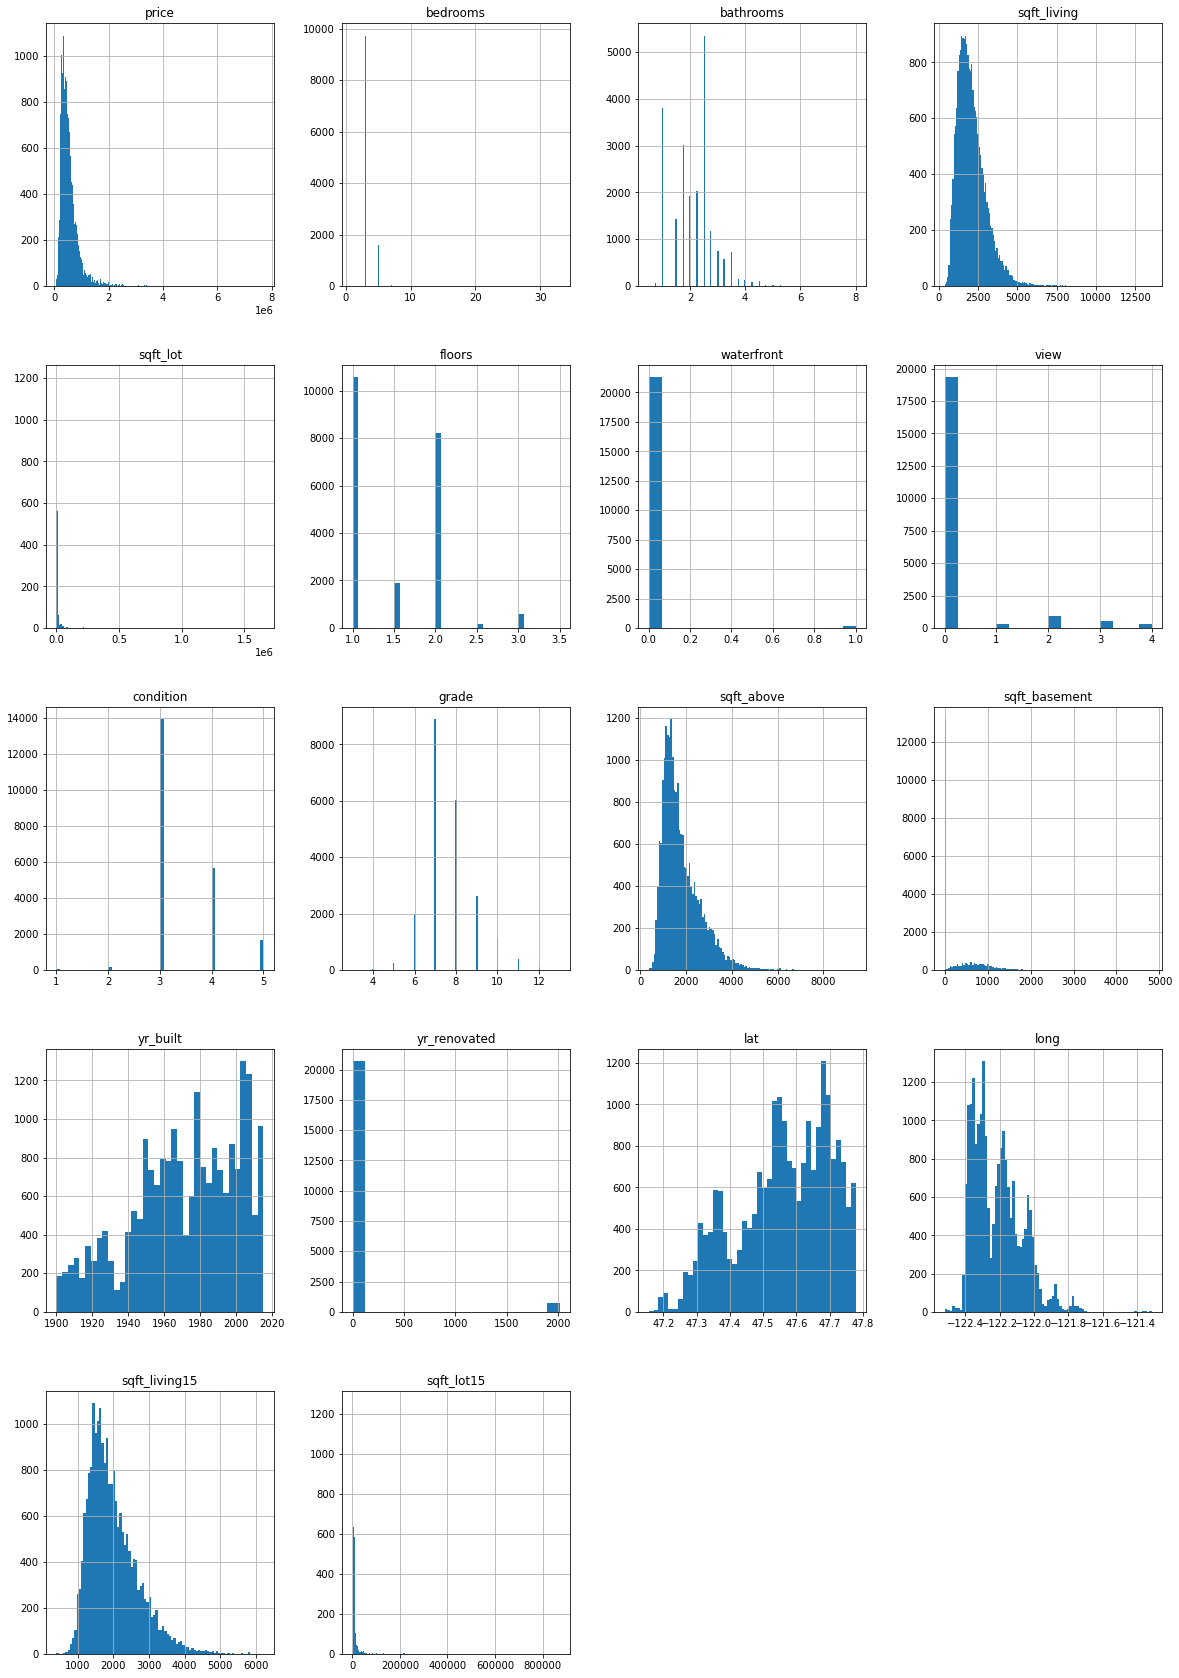

In [38]:
# Investigating histograms

df_1.hist(figsize=(20, 30), bins='auto')

In [39]:
# Commented out because of the git push problems
"""
**Based on the histograms above**
> 1. The following variables should be considered categorical:
>>Waterfront<br>
Condition<br>
View<br>
> 2. sqft_basement, sqft_lot, sqft_lot15, and yr_renovated have a large number of zeros and are strong candidates for removal of outliers and/or engineered variables<br>
> 3. Latitudes and Longitudes can be used as descriptors of a geographic location of a property. However, I think there is  a better variable to describe the location of a property, a distance from the center of the city, which can be calculated from geocoordinates.<br>
    >4. The target variable, the price of the property, has a strong positive skew attributed to outliers in the higher price bracket. The strategy is to **remove the outliers and to transform the variable** to make it more normally distributed
"""

'\n**Based on the histograms above**\n> 1. The following variables should be considered categorical:\n>>Waterfront<br>\nCondition<br>\nView<br>\n> 2. sqft_basement, sqft_lot, sqft_lot15, and yr_renovated have a large number of zeros and are strong candidates for removal of outliers and/or engineered variables<br>\n> 3. Latitudes and Longitudes can be used as descriptors of a geographic location of a property. However, I think there is  a better variable to describe the location of a property, a distance from the center of the city, which can be calculated from geocoordinates.<br>\n    >4. The target variable, the price of the property, has a strong positive skew attributed to outliers in the higher price bracket. The strategy is to **remove the outliers and to transform the variable** to make it more normally distributed\n'

In [40]:
# Checking for correlations between the variables with Pearson coefficient between 1 and 0.3
# I am using the same approach and reusing the code from Lesson 19

df_coeff=df_1.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_coeff['pairs'] = list(zip(df_coeff.level_0, df_coeff.level_1))
df_coeff.set_index(['pairs'], inplace = True)
df_coeff.drop(columns=['level_1', 'level_0'], inplace = True)
df_coeff.columns = ['cc']
df_coeff.drop_duplicates(inplace=True)
df_coeff[((df_coeff.cc>.3) & (df_coeff.cc <1))]

cc
pairs                                 
(sqft_above, sqft_living)     0.876533
(sqft_living, grade)          0.762477
(grade, sqft_above)           0.756221
(sqft_living, sqft_living15)  0.756186
(bathrooms, sqft_living)      0.755522
(sqft_above, sqft_living15)   0.731887
(sqft_lot, sqft_lot15)        0.717743
(grade, sqft_living15)        0.713178
(sqft_living, price)          0.701875
(sqft_above, bathrooms)       0.686328
(price, grade)                0.668020
(bathrooms, grade)            0.665587
(price, sqft_above)           0.605294
(sqft_living15, price)        0.584549
(bedrooms, sqft_living)       0.579069
(sqft_living15, bathrooms)    0.569453
(price, bathrooms)            0.526229
(sqft_above, floors)          0.522751
(bathrooms, bedrooms)         0.515383
(bathrooms, yr_built)         0.506252
(floors, bathrooms)           0.501803
(yr_built, floors)            0.488935
(sqft_above, bedrooms)        0.480242
(floors, grade)               0.458091
(grade, yr_built)             0.446235
(sqft_living, sqft_basement)  0.428026
(yr_built, sqft_above)        0.422977
(yr_built, long)              0.409173
(sqft_living15, bedrooms)     0.394949
(view, price)                 0.393113
(view, waterfront)            0.381654
(condition, yr_built)         0.365129
(bedrooms, grade)             0.357988
(floors, sqft_living)         0.352868
(long, sqft_above)            0.344161
(long, sqft_living15)         0.334679
(yr_built, sqft_living15)     0.324715
(price, sqft_basement)        0.320842
(yr_built, sqft_living)       0.316646
(price, bedrooms)             0.309453
(price, lat)                  0.305744

 **The variables which have the strongest correlations with the price are**<br>
* sqft_living<br>
* grade<br>
* sqft_above<br>
* sqft_living15<br>
* bathrooms<br>
* view<br>
* bedrooms<br>
*lat

#### Establishing an intermediate dataframe and removing some outliers from it

In [41]:
# Removing extreme values from sqft_lot, sqft_lot15, bathrooms, and price
# On one hand, it can be left to the step of outlier removal, on the other doing it now
# will help a visual investigation of the distributions of the variables mentioned above

df_2=df_1[(df_1.sqft_lot >100) & (df_1.sqft_lot<40000)]

df_2=df_2[(df_2.sqft_lot15 >100) & (df_2.sqft_lot15<40000)]

df_2=df_2[df_2.price < 2500000]

df_2=df_2[df_2.bedrooms < 30]

df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20015 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20015 non-null  datetime64[ns]
 1   price          20015 non-null  float64       
 2   bedrooms       20015 non-null  int64         
 3   bathrooms      20015 non-null  float64       
 4   sqft_living    20015 non-null  int64         
 5   sqft_lot       20015 non-null  int64         
 6   floors         20015 non-null  float64       
 7   waterfront     20015 non-null  int64         
 8   view           20015 non-null  int64         
 9   condition      20015 non-null  int64         
 10  grade          20015 non-null  int64         
 11  sqft_above     20015 non-null  int64         
 12  sqft_basement  20015 non-null  int64         
 13  yr_built       20015 non-null  int64         
 14  yr_renovated   20015 non-null  int64         
 15  lat            2001

In [42]:
# Creating a new categorical variable: month
df_2['month'] = pd.to_datetime(df_2['date']).dt.month

# Creating a new numerical variable: distance (distance from center)
df_2['distance'] = df_2.apply(lambda row: distance_from_center(row.lat,abs(row.long)), axis=1) 

# Creating a new categorical variable: basement_exists (1/0), integer datatype
df_2.loc[(df_2['sqft_basement'] > 50), 'basement_exists'] = 1
df_2.loc[(df_2['sqft_basement'] <= 50), 'basement_exists'] = 0
df_2.basement_exists=df_2.basement_exists.astype('int64')

In [43]:
# Creating a new categorical variable (integer datatype) renovation_done with values [0,1,2,3,4]

# 0 representing renovation never done on houses more than 9 years old (yr_built between 2015 and 2006)
# 1 representing renovation done more than or equal 50 years ago
# 2 representing renovation done between 30 and 49 years ago
# 3 representing renovation done between 29 and 10 years ago
# 4 representing renovation done between 9 and 1 year ago OR houses built less or equal 9 years ago
#   (yr_built between 2015 and 2006)

df_2.loc[((df_2['yr_renovated'] == 0) & (df_2['yr_built'] < 2006)), 'renovation_done'] = 0
df_2.loc[((2015-df_2['yr_renovated'] >= 50) & (df_2['yr_renovated'] != 0)), 'renovation_done'] = 1
df_2.loc[((2015-df_2['yr_renovated'] < 50) & (2015-df_2['yr_renovated'] >= 30)), 'renovation_done'] = 2
df_2.loc[((2015-df_2['yr_renovated'] < 30) & (2015-df_2['yr_renovated'] >= 10)), 'renovation_done'] = 3
df_2.loc[((2015-df_2['yr_renovated'] < 10) | (df_2['yr_built'] >= 2006)), 'renovation_done'] = 4

df_2.renovation_done=df_2.renovation_done.astype('int64')

In [44]:
# Dropping sqft_basement variable
# Dropping latitude & longtitude variable
# Dropping date variable# Resetting index due to removal of records with extreme values in 
# sqft_lot, sqft_lot15, bathrooms and price

df_2=df_2.drop(['sqft_basement','date', 'lat','long','yr_renovated'], axis=1)

df_2=df_2.reset_index(drop=True)

df_2

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  yr_built  sqft_living15  sqft_lot15  month  distance  basement_exists  renovation_done
0      221900.0         3       1.00         1180      5650     1.0           0     0          3      7        1180      1955           1340        5650     10       7.4                0                0
1      538000.0         3       2.25         2570      7242     2.0           0     0          3      7        2170      1951           1690        7639     12       8.0                1                3
2      180000.0         2       1.00          770     10000     1.0           0     0          3      6         770      1933           2720        8062      2      10.2                0                0
3      604000.0         4       3.00         1960      5000     1.0           0     0          5      7        1050      1965           1360        5000     12       6.6                1                0
4      510000.0         3       2.00         1680      8080     1.0           0     0          3      8        1680      1987           1800        7503      2      13.4                0                0
...         ...       ...        ...          ...       ...     ...         ...   ...        ...    ...         ...       ...            ...         ...    ...       ...              ...              ...
20010  360000.0         3       2.50         1530      1131     3.0           0     0          3      8        1530      2009           1530        1509      5       6.5                0                4
20011  400000.0         4       2.50         2310      5813     2.0           0     0          3      8        2310      2014           1830        7200      2       6.7                0                4
20012  402101.0         2       0.75         1020      1350     2.0           0     0          3      7        1020      2009           1020        2007      6       1.7                0                4
20013  400000.0         3       2.50         1600      2388     2.0           0     0          3      8        1600      2004           1410        1287      1      13.2                0                0
20014  325000.0         2       0.75         1020      1076     2.0           0     0          3      7        1020      2008           1020        1357     10       1.8                0                4

[20015 rows x 18 columns]

In [45]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>df_2</b> DataFrame<br><br><b>20015</b> records out of the original <b>21597</b> left
    </div><br>
<div class="alert alert-block alert-danger">
    <b>Index reset</b>
    </div><br>
"""

'\n<div class="alert alert-block alert-success">\n    <b>df_2</b> DataFrame<br><br><b>20015</b> records out of the original <b>21597</b> left\n    </div><br>\n<div class="alert alert-block alert-danger">\n    <b>Index reset</b>\n    </div><br>\n'

#### Plotting numerical variables against the target variable

In [46]:
# Dropping categorical variables to simplify the analysis of the numerical ones

df_num1=df_2.drop(['waterfront','view','condition','basement_exists','renovation_done','month'], axis=1)


In [47]:
# Displaying the Coefficients of Determination and p-values for the remaining variables
r2_p(df_num1)

For price: R2 coefficient is 1.0, p-value is 0.0
For bedrooms: R2 coefficient is 0.3195, p-value is 0.0
For bathrooms: R2 coefficient is 0.4999, p-value is 0.0
For sqft_living: R2 coefficient is 0.6795, p-value is 0.0
For sqft_lot: R2 coefficient is 0.1565, p-value is 7.279024950162686e-110
For floors: R2 coefficient is 0.2657, p-value is 1.2233e-320
For grade: R2 coefficient is 0.6726, p-value is 0.0
For sqft_above: R2 coefficient is 0.5746, p-value is 0.0
For yr_built: R2 coefficient is 0.0348, p-value is 8.471205832359682e-07
For sqft_living15: R2 coefficient is 0.5951, p-value is 0.0
For sqft_lot15: R2 coefficient is 0.1512, p-value is 1.1950868785722046e-102
For distance: R2 coefficient is -0.3432, p-value is 0.0


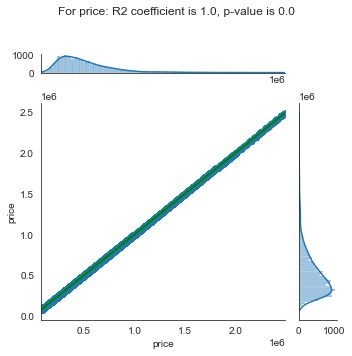

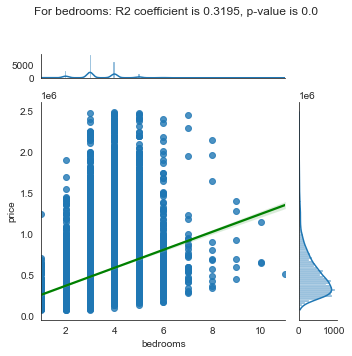

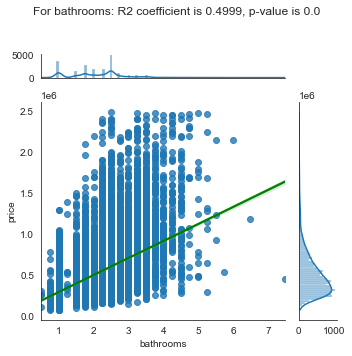

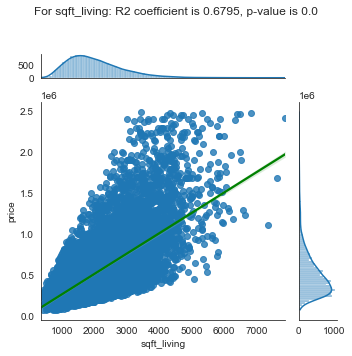

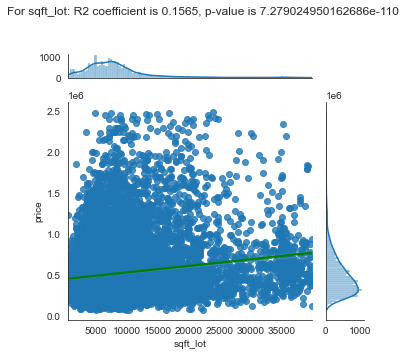

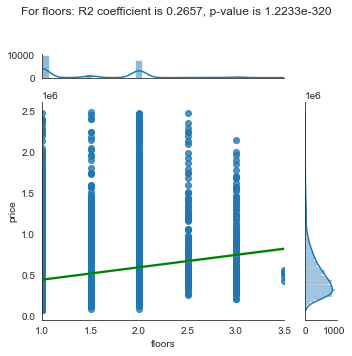

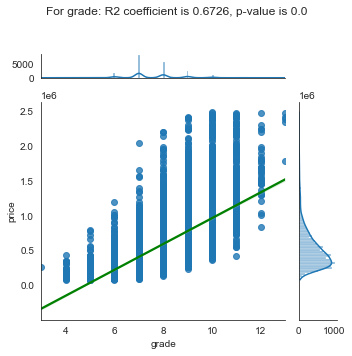

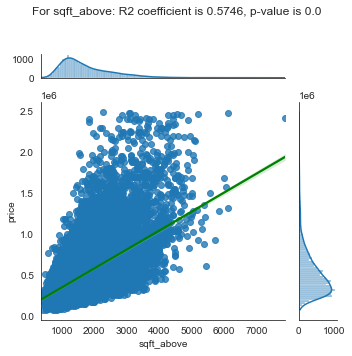

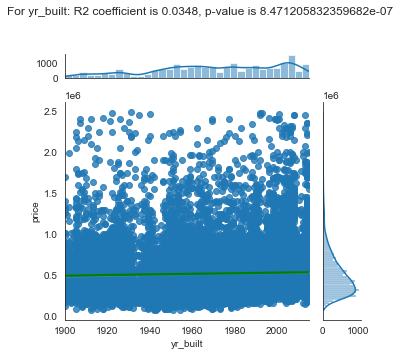

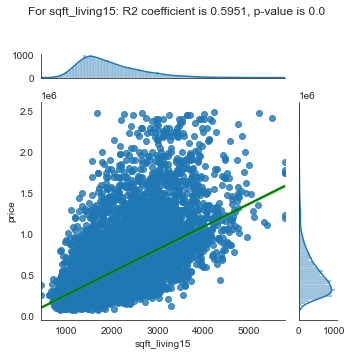

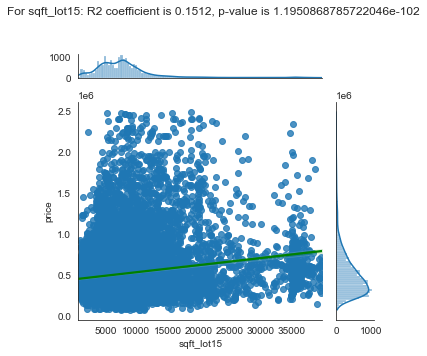

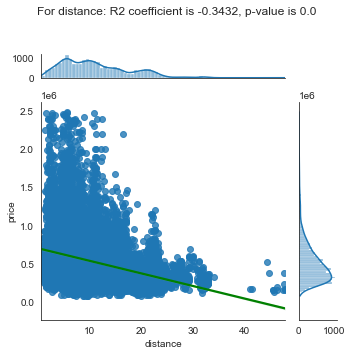

In [48]:
# Joint plot of the original (not altered) numerical variables
jointplot(df_num1)

In [49]:
df_num1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015 entries, 0 to 20014
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20015 non-null  float64
 1   bedrooms       20015 non-null  int64  
 2   bathrooms      20015 non-null  float64
 3   sqft_living    20015 non-null  int64  
 4   sqft_lot       20015 non-null  int64  
 5   floors         20015 non-null  float64
 6   grade          20015 non-null  int64  
 7   sqft_above     20015 non-null  int64  
 8   yr_built       20015 non-null  int64  
 9   sqft_living15  20015 non-null  int64  
 10  sqft_lot15     20015 non-null  int64  
 11  distance       20015 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 1.8 MB


In [50]:
# Removing extreme values from bedrooms, bathrooms, floors, and distance
# The observations with the extreme values of these variables are visually identifiable 

df_num2=df_num1[(df_num1.bedrooms < 9) & (df_num1.bathrooms < 5.5) &(df_num1.distance < 30) 
               & (df_num1.floors<3.5)]
df_num2.drop(['yr_built'], axis=1, inplace=True)
df_num2.reset_index(drop=True, inplace=True)

In [51]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19811 entries, 0 to 19810
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19811 non-null  float64
 1   bedrooms       19811 non-null  int64  
 2   bathrooms      19811 non-null  float64
 3   sqft_living    19811 non-null  int64  
 4   sqft_lot       19811 non-null  int64  
 5   floors         19811 non-null  float64
 6   grade          19811 non-null  int64  
 7   sqft_above     19811 non-null  int64  
 8   sqft_living15  19811 non-null  int64  
 9   sqft_lot15     19811 non-null  int64  
 10  distance       19811 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.7 MB


In [52]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>df_num2</b> DataFrame<br><br><b>19811</b> records out of original <b>21597</b> left
    </div><br>
<div class="alert alert-block alert-danger">
    <b>Index reset</b>
    </div><br>
"""

'\n<div class="alert alert-block alert-success">\n    <b>df_num2</b> DataFrame<br><br><b>19811</b> records out of original <b>21597</b> left\n    </div><br>\n<div class="alert alert-block alert-danger">\n    <b>Index reset</b>\n    </div><br>\n'

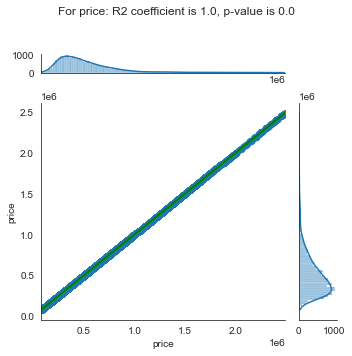

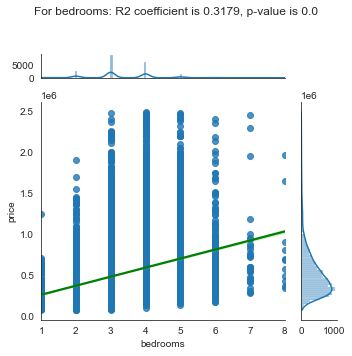

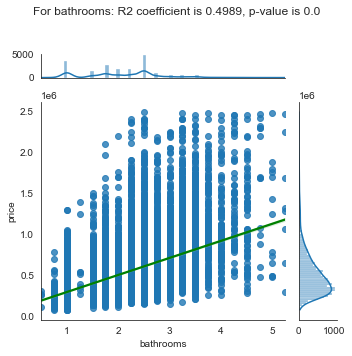

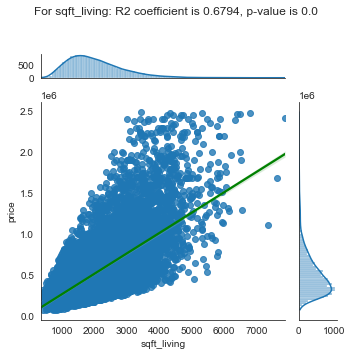

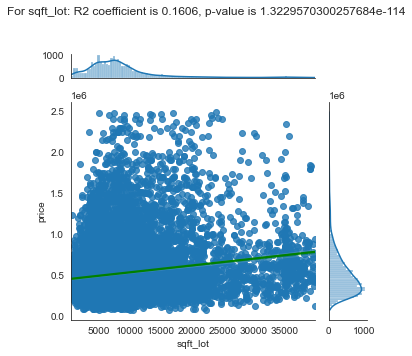

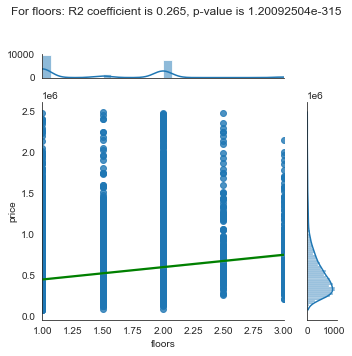

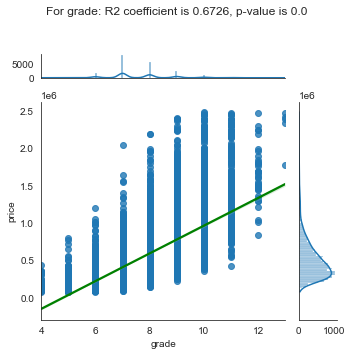

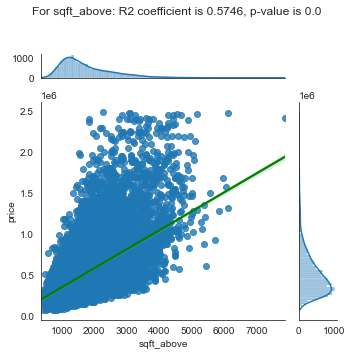

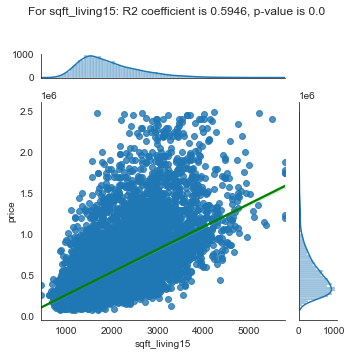

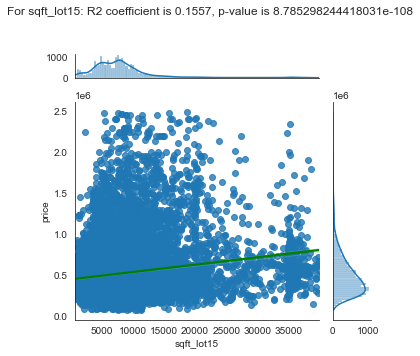

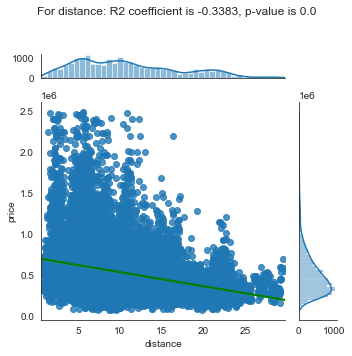

In [53]:
# Joint plot of numerical variables after adjustments
jointplot(df_num2)

In [54]:
r2_p(df_num2)

For price: R2 coefficient is 1.0, p-value is 0.0
For bedrooms: R2 coefficient is 0.3179, p-value is 0.0
For bathrooms: R2 coefficient is 0.4989, p-value is 0.0
For sqft_living: R2 coefficient is 0.6794, p-value is 0.0
For sqft_lot: R2 coefficient is 0.1606, p-value is 1.3229570300257684e-114
For floors: R2 coefficient is 0.265, p-value is 1.20092504e-315
For grade: R2 coefficient is 0.6726, p-value is 0.0
For sqft_above: R2 coefficient is 0.5746, p-value is 0.0
For sqft_living15: R2 coefficient is 0.5946, p-value is 0.0
For sqft_lot15: R2 coefficient is 0.1557, p-value is 8.785298244418031e-108
For distance: R2 coefficient is -0.3383, p-value is 0.0


In [55]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19811 entries, 0 to 19810
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          19811 non-null  float64
 1   bedrooms       19811 non-null  int64  
 2   bathrooms      19811 non-null  float64
 3   sqft_living    19811 non-null  int64  
 4   sqft_lot       19811 non-null  int64  
 5   floors         19811 non-null  float64
 6   grade          19811 non-null  int64  
 7   sqft_above     19811 non-null  int64  
 8   sqft_living15  19811 non-null  int64  
 9   sqft_lot15     19811 non-null  int64  
 10  distance       19811 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.7 MB


#### Visualizing numerical predictors correlation with the price and with each other using heat map

<AxesSubplot:>

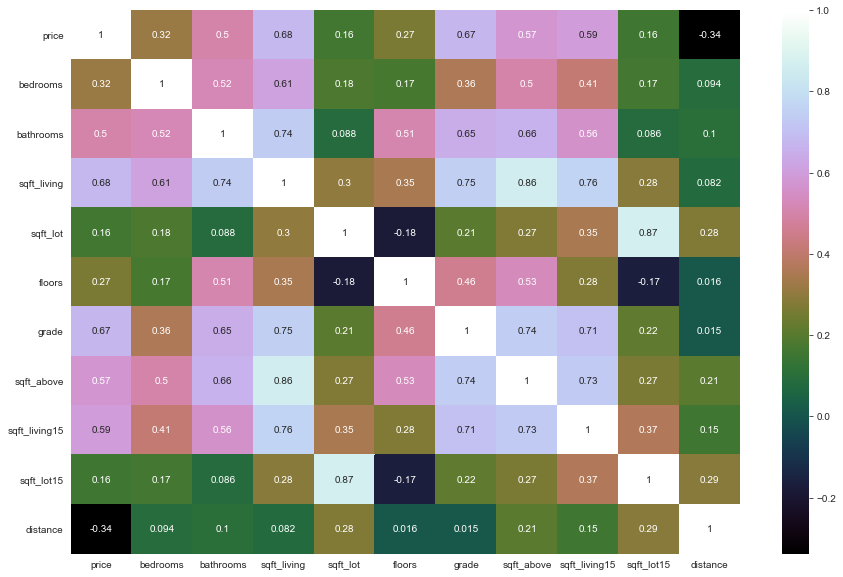

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_num2.corr(), cmap="cubehelix", annot=True)

In [57]:
# Bedrooms is relatively highly correlated with bathrooms and sqft_living; correlations of floors, sqft_lot and sqft_lot15 
# with prices are low. Dropping these variables

df_num3=df_num2.drop(['bedrooms','sqft_lot','sqft_lot15','floors'], axis=1)

<AxesSubplot:>

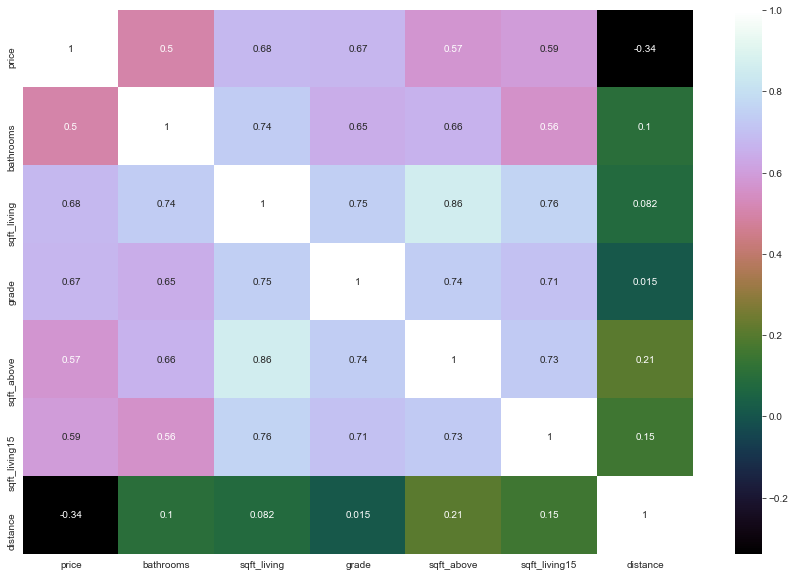

In [58]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_num3.corr(), cmap="cubehelix", annot=True)

In [59]:
r2_p(df_num3)

For price: R2 coefficient is 1.0, p-value is 0.0
For bathrooms: R2 coefficient is 0.4989, p-value is 0.0
For sqft_living: R2 coefficient is 0.6794, p-value is 0.0
For grade: R2 coefficient is 0.6726, p-value is 0.0
For sqft_above: R2 coefficient is 0.5746, p-value is 0.0
For sqft_living15: R2 coefficient is 0.5946, p-value is 0.0
For distance: R2 coefficient is -0.3383, p-value is 0.0


#### Exploring the distribution of the remaining numerical predictors

Column: bathrooms | Skewness = 0.28 | Kurtosis = 0.09
Column: grade | Skewness = 0.73 | Kurtosis = 1.02


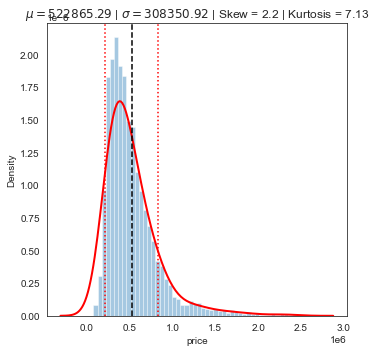

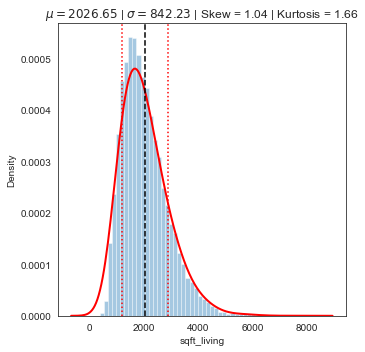

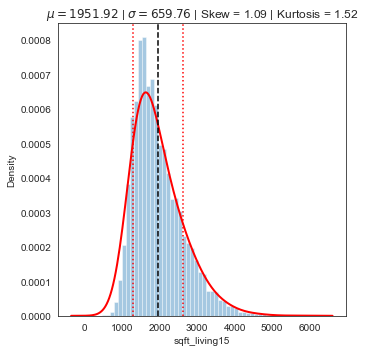

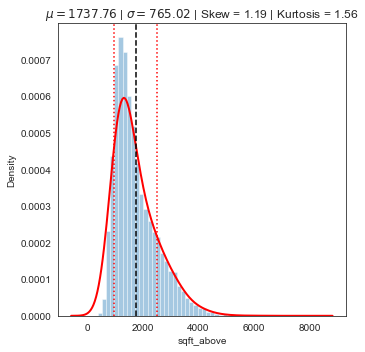

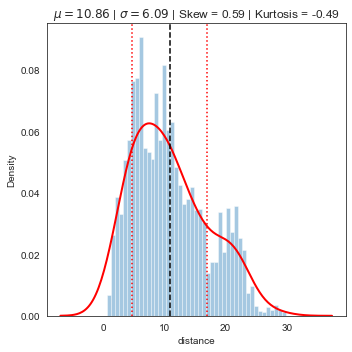

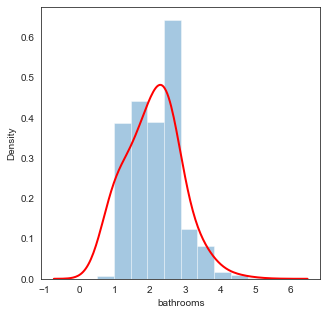

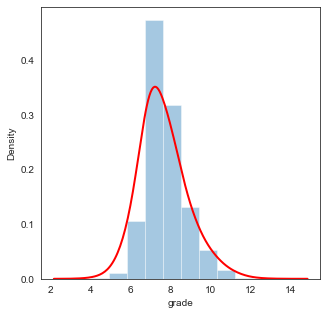

In [60]:
# Plotting KDE and distribution plots of the remaining variables

continuous=['price','sqft_living','sqft_living15','sqft_above','distance']
for col in continuous:
    fig, ax =plt.subplots(figsize=(5, 5))
    distribution(df_num3[col])

discrete=['bathrooms','grade']
for col in discrete:
    fig, ax =plt.subplots(figsize=(5, 5))
    ax = sns.distplot(df_num3[col], bins=10, kde_kws={"color": "r", "lw": 2, "label": "KDE", "bw_adjust": 4})
    skew_val = stats.skew(df_num3[col], bias=False)
    kurt_val = stats.kurtosis(df_num3[col],bias=False)
    print('Column: {} | Skewness = {} | Kurtosis = {}'.
                 format(col, round(skew_val,2), round(kurt_val,2)))

In [61]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info">All but one variable (distance) are left shifted, which is indicated by the skewness values >1, with price has the most skewed distribution. Because the skewness it to the left (positive values), the log transformation might be needed to normalize the variables. Kurtosis values for all variables are different from 0 (Pearson's definition of kurtosis of a normal distribution). <br>
    Price distribution is highly <b>Leptokurtic</b>, other variables are slightly <b>Leptokurtic</b> (sqft_living, sqft_above, sqft_living15, grade), slightly <b>Platykurtic</b> (distance) or almost <b>Mesokurtic</b> (bathrooms)</div>
"""


'\n<div class="alert alert-block alert-info">All but one variable (distance) are left shifted, which is indicated by the skewness values >1, with price has the most skewed distribution. Because the skewness it to the left (positive values), the log transformation might be needed to normalize the variables. Kurtosis values for all variables are different from 0 (Pearson\'s definition of kurtosis of a normal distribution). <br>\n    Price distribution is highly <b>Leptokurtic</b>, other variables are slightly <b>Leptokurtic</b> (sqft_living, sqft_above, sqft_living15, grade), slightly <b>Platykurtic</b> (distance) or almost <b>Mesokurtic</b> (bathrooms)</div>\n'

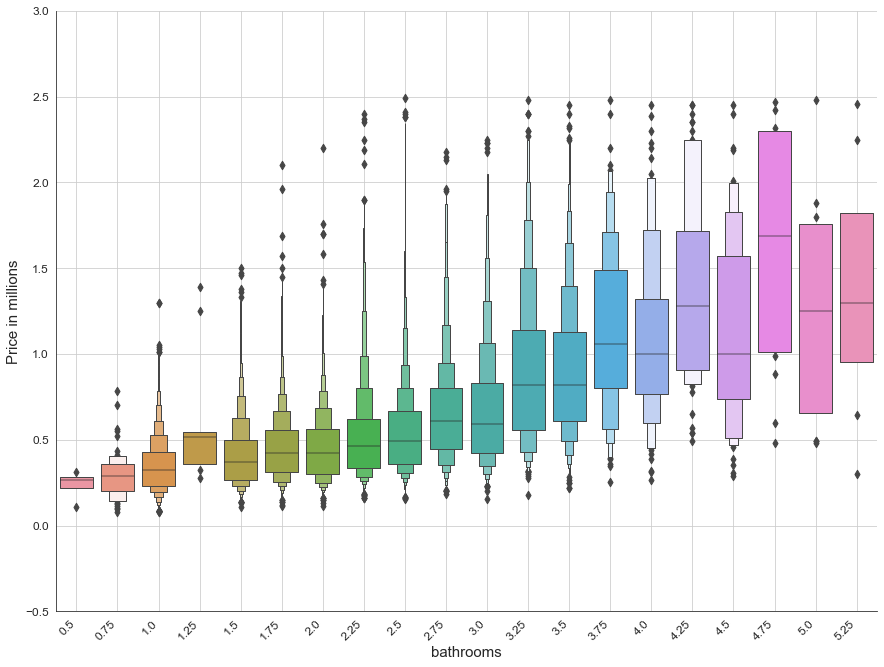

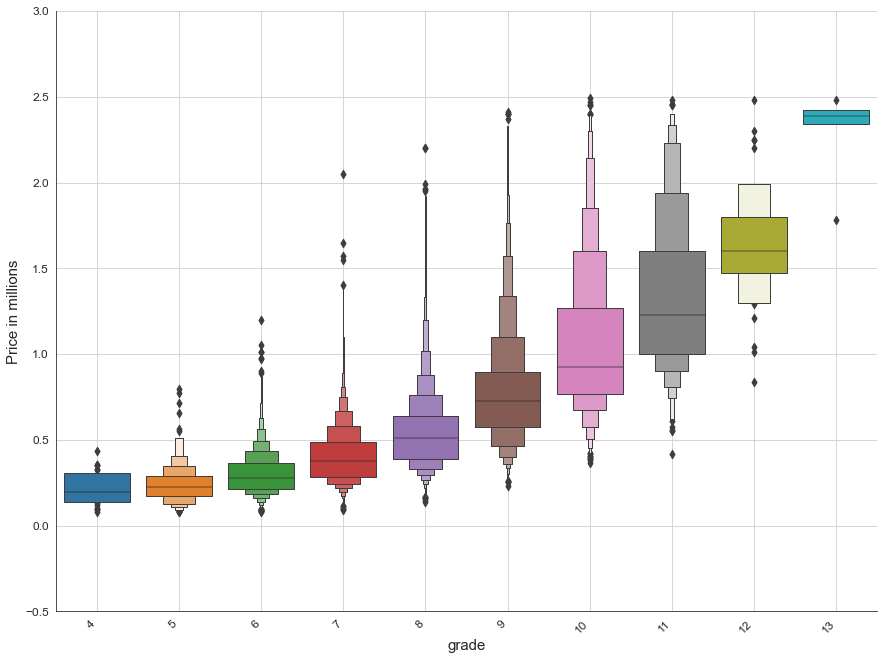

In [62]:
# Diamond box plots for descrete numerical variables

discrete=['bathrooms','grade']
for col in discrete:

    ax = sns.catplot(x=col, y='price', kind="boxen",
            data=df_num3.sort_values(col), height=9, aspect=12/9)
    ax.set_xticklabels(rotation=45, ha='right', fontsize=12)
    ax.set_yticklabels(fontsize=12)
    plt.ylabel('Price in millions', fontsize=15)
    plt.xlabel(col, fontsize=15);
    plt.grid()
    plt.show()

In [63]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> Based on the distribution plots, variable 'bathroom' has a symmetrical distribution (Skewness is 0.28), with a very low kurtosis (0.09) indicative of a <b>Mesokurtic</b> curve (Gaussian distribution has a kurtosis of 0 by Pearson's definition used by scipy.stats.kurtosis method)<br>
Variable 'grade' is slightly skewed to the right (0.73) and relatively low kurtosis, slightly above 1.<br>
The pronounced correlation of these variables with the price is identifiable in the box plots above. The plots show that the numbers of outliers in the distribution of the variables are reasonable. Both variables have a wider range of values in the higher price brackets.</div>
"""

'\n<div class="alert alert-block alert-info"> Based on the distribution plots, variable \'bathroom\' has a symmetrical distribution (Skewness is 0.28), with a very low kurtosis (0.09) indicative of a <b>Mesokurtic</b> curve (Gaussian distribution has a kurtosis of 0 by Pearson\'s definition used by scipy.stats.kurtosis method)<br>\nVariable \'grade\' is slightly skewed to the right (0.73) and relatively low kurtosis, slightly above 1.<br>\nThe pronounced correlation of these variables with the price is identifiable in the box plots above. The plots show that the numbers of outliers in the distribution of the variables are reasonable. Both variables have a wider range of values in the higher price brackets.</div>\n'

### Numerical variables: Exploring Mutual Correlation Coefficients and Variance Inflation Factor

#### Using VIF as an indicator of collinearity between independent variables

In [64]:
calc_vif(df_num3)

variables        VIF
0          price  11.713924
1      bathrooms  21.024526
2    sqft_living  42.036909
3          grade  27.796857
4     sqft_above  26.850680
5  sqft_living15  28.037076
6       distance   6.670397

In [65]:
# Dropping fields that have high VIF. I decided to leave in sqft_living versus sqft_living15 due to the fact that it is
# easier to interpret in a model and it is a feature under control of a property owner (versus sqft_living15 which is
# a charecteristic of a neighborhood)

df_num4=df_num3.drop(['price','sqft_above','sqft_living15'],axis=1)

calc_vif(df_num4)

variables        VIF
0    bathrooms  20.829518
1  sqft_living  16.749281
2        grade  18.971120
3     distance   3.971751

#### Pearson coefficients analysis of the remaining independent variables

In [66]:
df_num4['price']=df_num3['price']

In [67]:
# Displaying R2s for the remaining variables
r2_p(df_num4)

For bathrooms: R2 coefficient is 0.4989, p-value is 0.0
For sqft_living: R2 coefficient is 0.6794, p-value is 0.0
For grade: R2 coefficient is 0.6726, p-value is 0.0
For distance: R2 coefficient is -0.3383, p-value is 0.0
For price: R2 coefficient is 1.0, p-value is 0.0


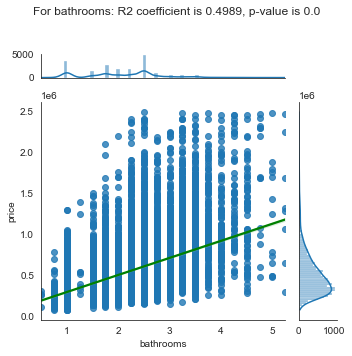

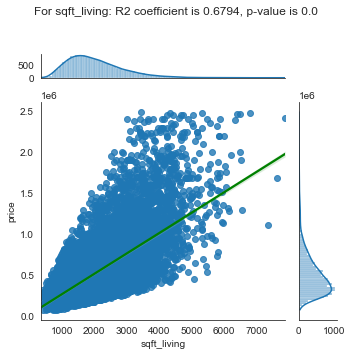

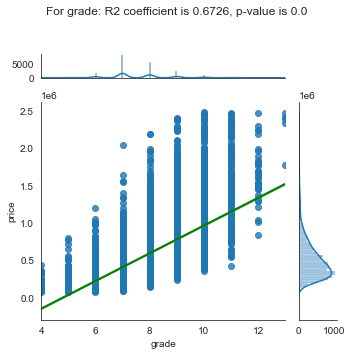

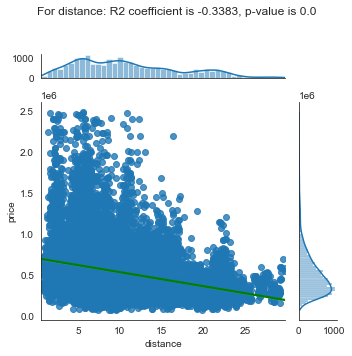

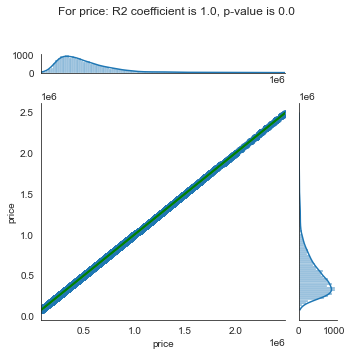

In [68]:
# Displaying correlations between predictors and the target
jointplot(df_num4)

<AxesSubplot:>

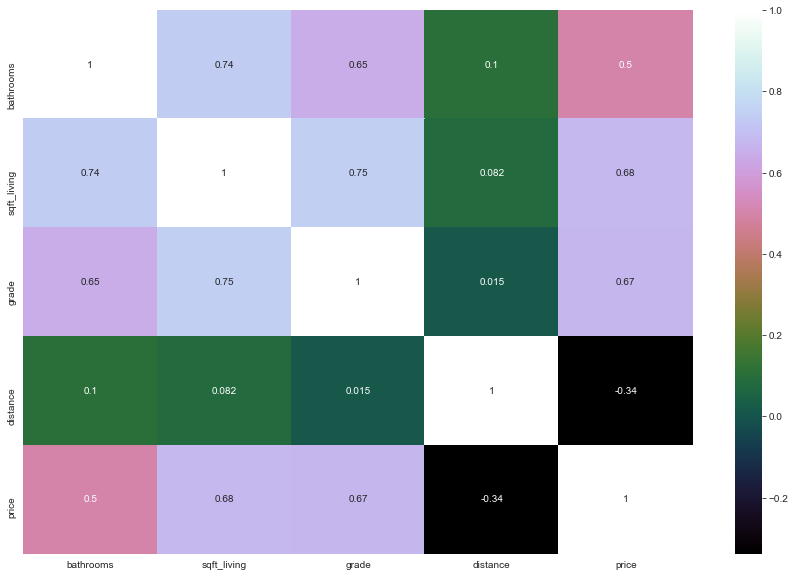

In [69]:
# Using heatmap to visualize mutual relationships between predictors and their correlations with the target
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_num4.corr(), cmap="cubehelix", annot=True)

In [70]:
# Checking for correlations between the variables with pearson coefficient between 1 and 0.3


df_coeff=df_num4.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_coeff['pairs'] = list(zip(df_coeff.level_0, df_coeff.level_1))
df_coeff.set_index(['pairs'], inplace = True)
df_coeff.drop(columns=['level_1', 'level_0'], inplace = True)
df_coeff.columns = ['cc']
df_coeff.drop_duplicates(inplace=True)
df_coeff[((df_coeff.cc>.3) & (df_coeff.cc <1))]

cc
pairs                             
(sqft_living, grade)      0.746576
(bathrooms, sqft_living)  0.737962
(price, sqft_living)      0.679411
(price, grade)            0.672609
(grade, bathrooms)        0.647588
(price, bathrooms)        0.498869
(distance, price)         0.338264

In [71]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-danger">Mutual correlation coefficients between the remaining independent variables are 
slightly higher or below 0.7. I am leaving sqft_living, grade, and bathroom variables in because of their logical connection with a property price despite their multicollinearity (0.74 & 0.73 are above the 0.7 threshold).<br>

Therefore the remaining numerical variables for <u>modeling</u> are<br><br>
<b>1. grade<br>
2. bathrooms<br>
3. sqft_living<br>
4. distance<br></b>
    </div>
    
"""    

'\n<div class="alert alert-block alert-danger">Mutual correlation coefficients between the remaining independent variables are \nslightly higher or below 0.7. I am leaving sqft_living, grade, and bathroom variables in because of their logical connection with a property price despite their multicollinearity (0.74 & 0.73 are above the 0.7 threshold).<br>\n\nTherefore the remaining numerical variables for <u>modeling</u> are<br><br>\n<b>1. grade<br>\n2. bathrooms<br>\n3. sqft_living<br>\n4. distance<br></b>\n    </div>\n    \n'

In [72]:
df_num4.describe()

bathrooms   sqft_living         grade      distance         price
count  19811.000000  19811.000000  19811.000000  19811.000000  1.981100e+04
mean       2.091338   2026.647670      7.615264     10.861961  5.228653e+05
std        0.739792    842.234389      1.116205      6.093693  3.083509e+05
min        0.500000    370.000000      4.000000      0.600000  7.800000e+04
25%        1.500000   1410.000000      7.000000      5.900000  3.200000e+05
50%        2.250000   1880.000000      7.000000      9.900000  4.450000e+05
75%        2.500000   2500.000000      8.000000     14.800000  6.338170e+05
max        5.250000   7880.000000     13.000000     29.800000  2.490000e+06

### Categorical variables: Investigating distributions and the raw correlations between the original, minimally processed predictor and the target (price)

#### Original categorical variables: waterfront, view, condition, basement_exists, renovation_done, month

In [73]:
#Creating a DataFrame with categorical variables

df_cat1 = df_2.filter(['price','waterfront','view','condition','basement_exists','renovation_done','month'], axis=1)


#### Visual investigation of the box plots

In [74]:
df_cat1

price  waterfront  view  condition  basement_exists  renovation_done  month
0      221900.0           0     0          3                0                0     10
1      538000.0           0     0          3                1                3     12
2      180000.0           0     0          3                0                0      2
3      604000.0           0     0          5                1                0     12
4      510000.0           0     0          3                0                0      2
...         ...         ...   ...        ...              ...              ...    ...
20010  360000.0           0     0          3                0                4      5
20011  400000.0           0     0          3                0                4      2
20012  402101.0           0     0          3                0                4      6
20013  400000.0           0     0          3                0                0      1
20014  325000.0           0     0          3                0                4     10

[20015 rows x 7 columns]

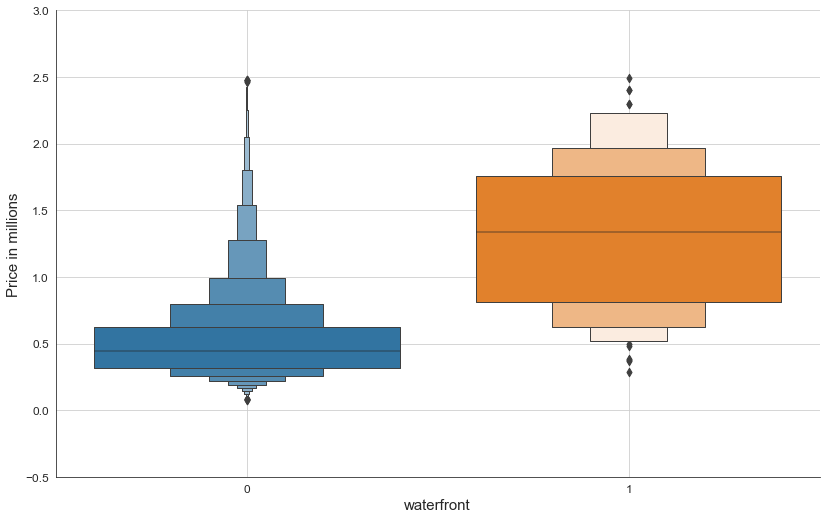

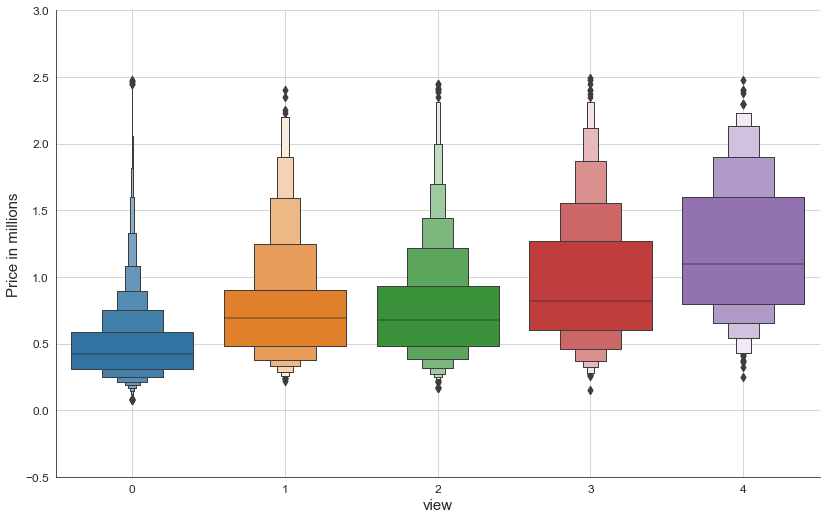

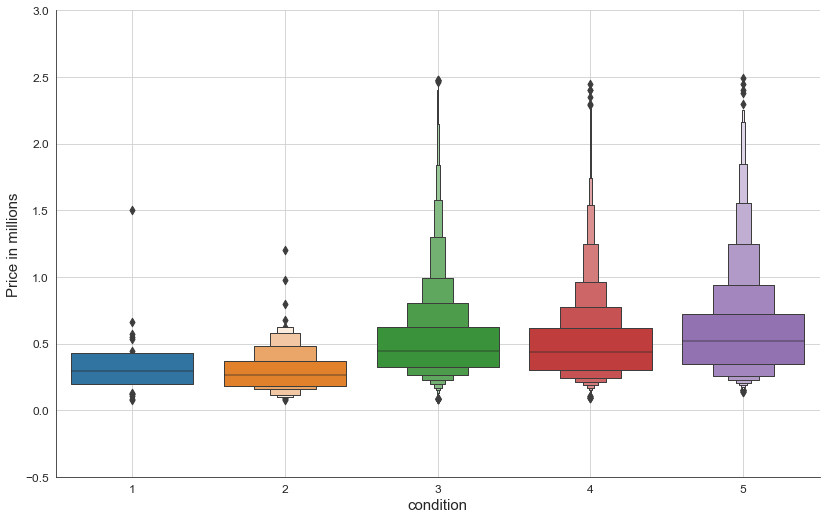

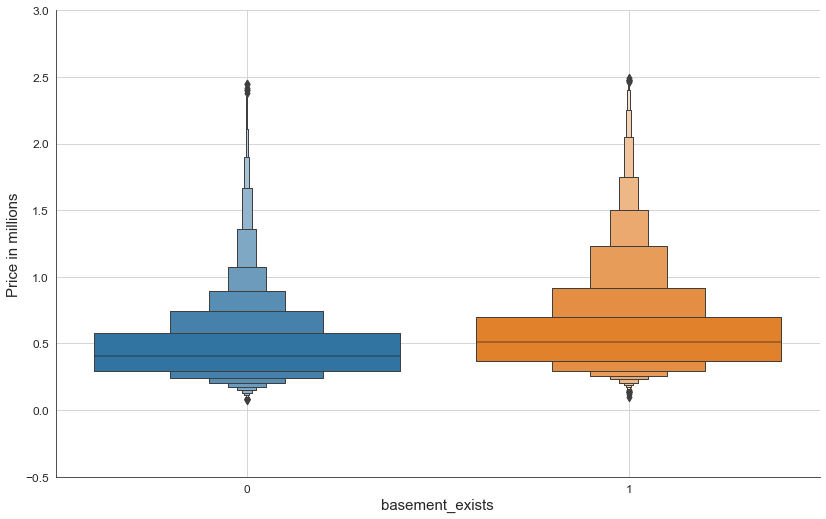

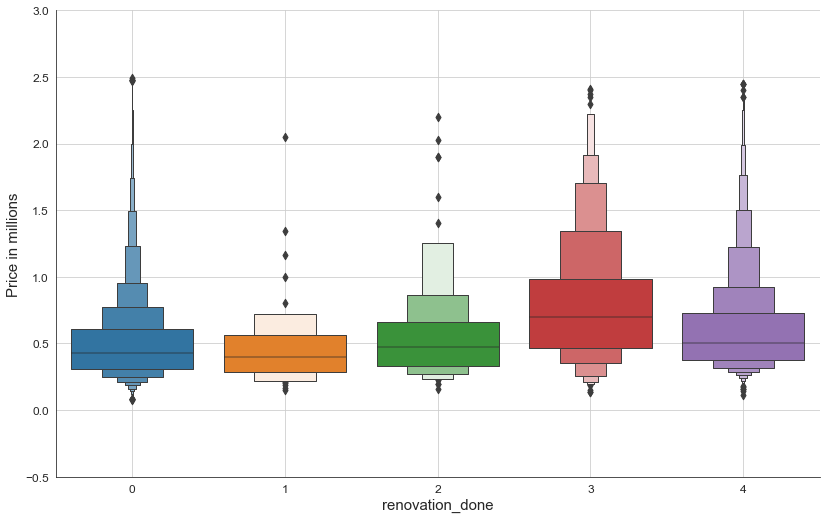

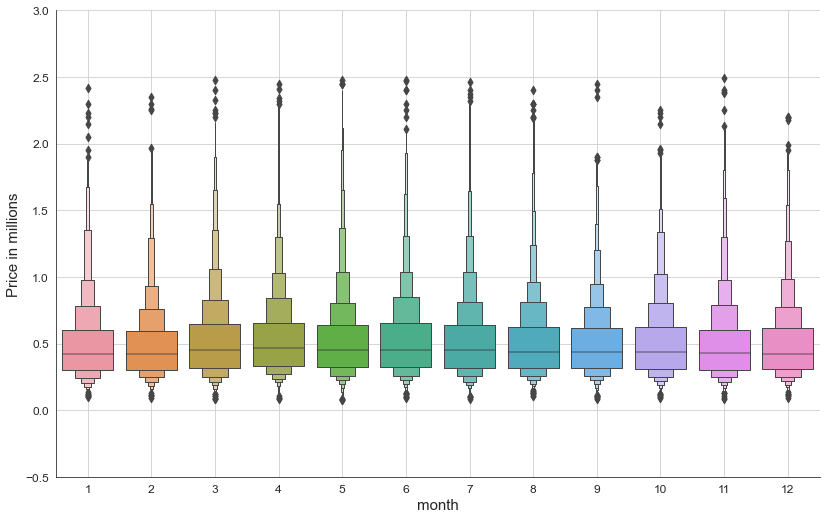

In [75]:
names=['waterfront','view','condition','basement_exists','renovation_done','month']
for col in names:
    boxen_plot(df_cat1,col)

In [76]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> Based on the plots, it is quite clear that 'month', 'condition' and 'basement_exists' variables do not affect the price of the properties and can be dropped from the categorical variables<br>
</div>
"""

'\n<div class="alert alert-block alert-info"> Based on the plots, it is quite clear that \'month\', \'condition\' and \'basement_exists\' variables do not affect the price of the properties and can be dropped from the categorical variables<br>\n</div>\n'

#### Dumming out variables in the categorical DataFrame

In [77]:
# Using OheHotEncoder to dummy categorical out. Based on the boxplots above, I am leaving 
# 'month','basement_exists','condition' variables out, they seem not to have too much effect on the target.
# The reason for removing 'waterfront' variable is a tiny porting of all properties in the dataset.

ohe=OneHotEncoder(drop='first')
df_cat_transform=ohe.fit_transform(df_cat1.drop(['price','month','basement_exists','condition','waterfront'], axis=1))
df_cat1_trsfm=pd.DataFrame(df_cat_transform.todense(), 
                          columns=ohe.get_feature_names(['view','renovation_done']))
df_cat1_trsfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015 entries, 0 to 20014
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   view_1             20015 non-null  float64
 1   view_2             20015 non-null  float64
 2   view_3             20015 non-null  float64
 3   view_4             20015 non-null  float64
 4   renovation_done_1  20015 non-null  float64
 5   renovation_done_2  20015 non-null  float64
 6   renovation_done_3  20015 non-null  float64
 7   renovation_done_4  20015 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


In [78]:
# Adding a price column and resetting the index 
# Due to the removal of the extreme values in numerical values, some rows have Nan price values; these rows are dropped

df_cat1_trsfm['price']=df_num4['price']

df_cat1_trsfm=df_cat1_trsfm[df_cat1_trsfm.price.notna()]

df_cat1_trsfm=df_cat1_trsfm.reset_index()

df_cat1_trsfm=df_cat1_trsfm.drop('index', axis=1)

df_cat1_trsfm

view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4     price
0         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  221900.0
1         0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0  538000.0
2         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  180000.0
3         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  604000.0
4         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  510000.0
...       ...     ...     ...     ...                ...                ...                ...                ...       ...
19806     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  360000.0
19807     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  400000.0
19808     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  402101.0
19809     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  400000.0
19810     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  325000.0

[19811 rows x 9 columns]

In [79]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>df_cat1_trsfm</b> DataFrame<br><br><b>19811</b> records out of original <b>21597</b> left
    </div><br>
<div class="alert alert-block alert-danger">
    <b>Index reset</b>
    </div><br>
"""

'\n<div class="alert alert-block alert-success">\n    <b>df_cat1_trsfm</b> DataFrame<br><br><b>19811</b> records out of original <b>21597</b> left\n    </div><br>\n<div class="alert alert-block alert-danger">\n    <b>Index reset</b>\n    </div><br>\n'

In [80]:
df_cat1_trsfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19811 entries, 0 to 19810
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   view_1             19811 non-null  float64
 1   view_2             19811 non-null  float64
 2   view_3             19811 non-null  float64
 3   view_4             19811 non-null  float64
 4   renovation_done_1  19811 non-null  float64
 5   renovation_done_2  19811 non-null  float64
 6   renovation_done_3  19811 non-null  float64
 7   renovation_done_4  19811 non-null  float64
 8   price              19811 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


# Model

## Data Modeling


### Baseline model

><i><b>“Everything should be made as simple as possible, but no simpler.”</b></i><div style="text-align: right">Albert Einstein</div>

The chosen baseline model is a model with only one numerical variable, grade.

#### Creating a model

In [81]:
## Create the formula and  the model

f  = 'price~grade'

model_baseline = smf.ols(f, df_num4).fit()
model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.637e+04
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:06   Log-Likelihood:            -2.7254e+05
No. Observations:               19811   AIC:                         5.451e+05
Df Residuals:                   19809   BIC:                         5.451e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8.921e+05   1.12e+04    -79.803      0.000   -9.14e+05    -8.7e+05
grade       1.858e+05   1452.448    127.927      0.000    1.83e+05    1.89e+05
==============================================================================
Omnibus:                     7709.438   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46187.116
Skew:                           1.765   Prob(JB):                         0.00
Kurtosis:                       9.595   Cond. No.                         53.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

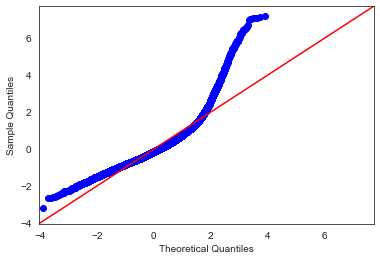

In [82]:
fig = sm.graphics.qqplot(model_baseline.resid,dist=stats.norm,fit=True,line='45')

In [83]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> The baseline model has a coefficient of determination of 0.452, indicating that roughly 45% of the observations fit the model. F-statistics is very high that indicates that the baseline model is a significant improvement of the  "intercept only model"<br>
    The Skewness and the Kurtosis values indicate non-normal distribution of the target variable<br>
    QQ plot is also indicative of the abnormal distribution of the residuals, especially in the upper Quantile
</div>
"""

'\n<div class="alert alert-block alert-info"> The baseline model has a coefficient of determination of 0.452, indicating that roughly 45% of the observations fit the model. F-statistics is very high that indicates that the baseline model is a significant improvement of the  "intercept only model"<br>\n    The Skewness and the Kurtosis values indicate non-normal distribution of the target variable<br>\n    QQ plot is also indicative of the abnormal distribution of the residuals, especially in the upper Quantile\n</div>\n'

### Model 1 (all numerical variables considered significant, see Explore section)

In [84]:
## Create a formula including the remaining numerical variables

variables_to_include = ' + '.join(df_num4.drop('price',axis=1).columns)

## Create the formula and  the model
f  = "price~" + variables_to_include

model_1 = smf.ols(f, df_num4).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     9947.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:06   Log-Likelihood:            -2.6759e+05
No. Observations:               19811   AIC:                         5.352e+05
Df Residuals:                   19806   BIC:                         5.352e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.142e+05   1.04e+04    -30.071      0.000   -3.35e+05   -2.94e+05
bathrooms   -1.725e+04   2599.797     -6.634      0.000   -2.23e+04   -1.22e+04
sqft_living   177.5465      2.610     68.031      0.000     172.431     182.662
grade        9.475e+04   1748.262     54.195      0.000    9.13e+04    9.82e+04
distance    -1.917e+04    209.218    -91.613      0.000   -1.96e+04   -1.88e+04
==============================================================================
Omnibus:                     8098.307   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65266.147
Skew:                           1.762   Prob(JB):                         0.00
Kurtosis:                      11.163   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### QQ plot: to access normality of the target variable

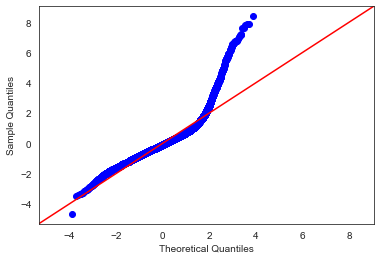

In [85]:
fig = sm.graphics.qqplot(model_1.resid,dist=stats.norm,fit=True,line='45')

In [86]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 
The summary of the model above indicates that<br>
    1. All the independent variables coefficients and the intercept value are significant (p-values< 0.05)<br>
    2. The coefficient of determination (R2) is not very high, but it is significantly higher than R2 of the baseline model. It indicates that about 66.8 percent of the observations fall within the regression line <br>
    3. The skew and the Kurtosis values indicate the highly non-normal distribution of the target variable<br>
    4. The high value of JB coefficient also indicates that the data is highly non-normal <br>
</div>

<div class="alert alert-block alert-info"> 
From the model's QQ plot, it is also quite obvious that the 'price' target variable is not normally distributed. A steep swing up indicates that the higher-priced houses are less likely to fit the baseline model and are more spread out. One possible reason might be <b>an unusually large number of outliers in the dataset</b></div>

<div class="alert alert-block alert-danger"><b>There are two potential approaches that can be taken</b><br>
        1. Normalization by either log or square root transformation<br>
        2. Removal of outliers</div>
"""

'\n<div class="alert alert-block alert-info"> \nThe summary of the model above indicates that<br>\n    1. All the independent variables coefficients and the intercept value are significant (p-values< 0.05)<br>\n    2. The coefficient of determination (R2) is not very high, but it is significantly higher than R2 of the baseline model. It indicates that about 66.8 percent of the observations fall within the regression line <br>\n    3. The skew and the Kurtosis values indicate the highly non-normal distribution of the target variable<br>\n    4. The high value of JB coefficient also indicates that the data is highly non-normal <br>\n</div>\n\n<div class="alert alert-block alert-info"> \nFrom the model\'s QQ plot, it is also quite obvious that the \'price\' target variable is not normally distributed. A steep swing up indicates that the higher-priced houses are less likely to fit the baseline model and are more spread out. One possible reason might be <b>an unusually large number of outli

####  Plot regression results against each regressor: accessing linearity of there relationship with the target and their homoscedasticity 

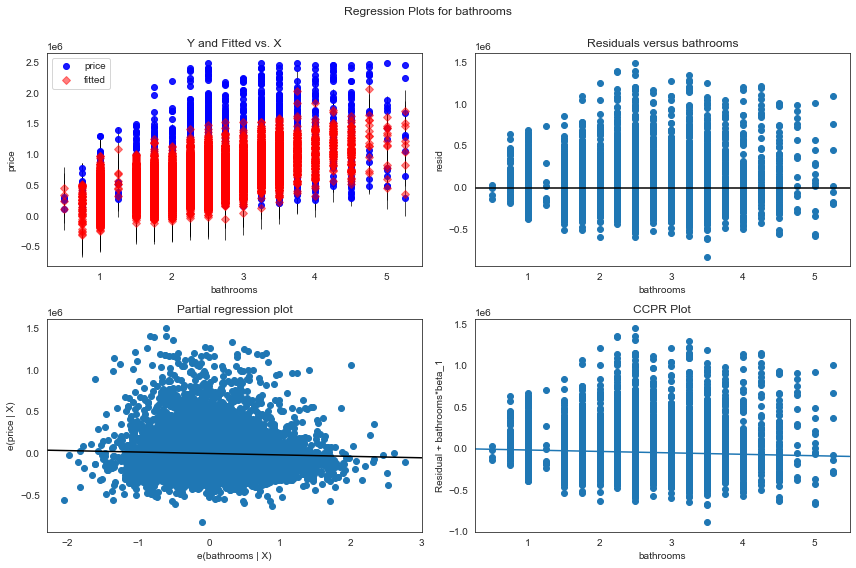

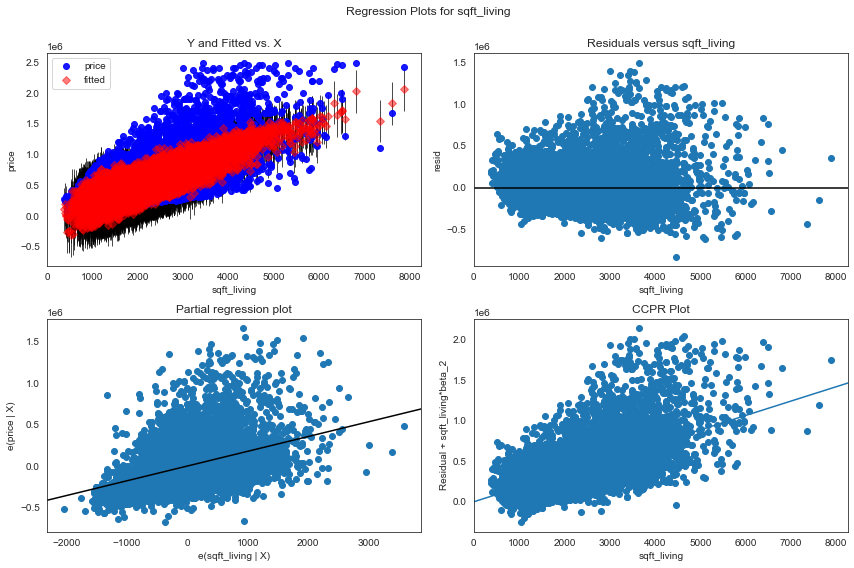

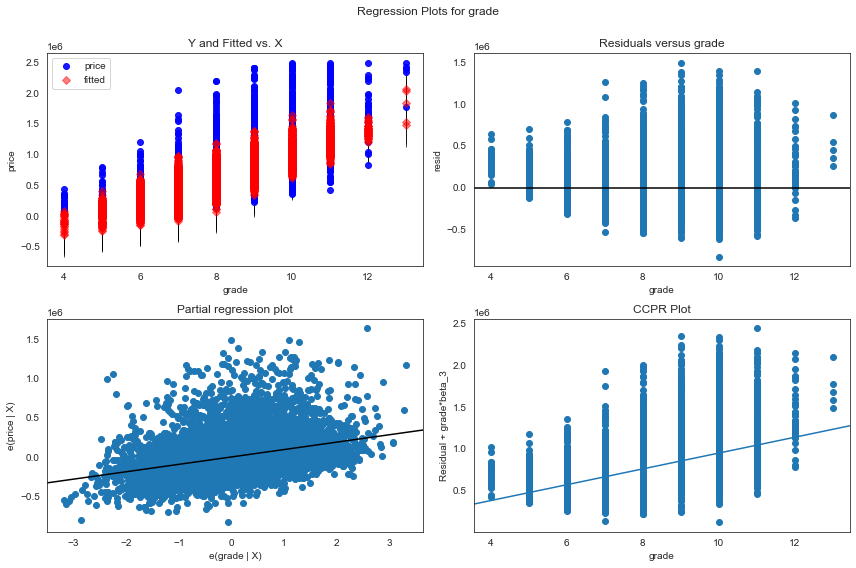

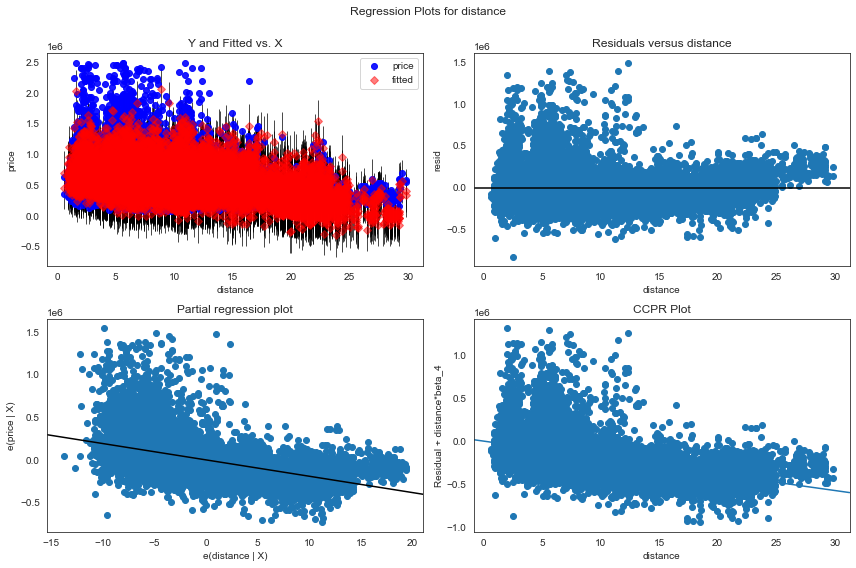

In [87]:
for col in (df_num4.drop('price',axis=1).columns):
    fig = sm.graphics.plot_regress_exog(model_1, col, fig=plt.figure(figsize=(12,8)))

In [88]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> The results indicate that all of the predictors display linear relationship with the target. The distance, sqft_living and bathrooms variables display less  heteroscedasticity than the grade variable does.<br><br></div>
<div class="alert alert-block alert-danger"><b>There might be several appropriate ways to address this issue</b><br>
    1. Log transformation of the target and/or independent variables<br>
    2. Using either Generalized Least Squares or Weighted Least squares<br>
    3. Bootstrapping<br>
    
"""

'\n<div class="alert alert-block alert-info"> The results indicate that all of the predictors display linear relationship with the target. The distance, sqft_living and bathrooms variables display less  heteroscedasticity than the grade variable does.<br><br></div>\n<div class="alert alert-block alert-danger"><b>There might be several appropriate ways to address this issue</b><br>\n    1. Log transformation of the target and/or independent variables<br>\n    2. Using either Generalized Least Squares or Weighted Least squares<br>\n    3. Bootstrapping<br>\n    \n'

### Model 2 (adding categorical variables)

#### Creating a model with all numerical variables and all categorical variables

In [89]:
df_num4

bathrooms  sqft_living  grade  distance     price
0           1.00         1180      7       7.4  221900.0
1           2.25         2570      7       8.0  538000.0
2           1.00          770      6      10.2  180000.0
3           3.00         1960      7       6.6  604000.0
4           2.00         1680      8      13.4  510000.0
...          ...          ...    ...       ...       ...
19806       2.50         1530      8       6.5  360000.0
19807       2.50         2310      8       6.7  400000.0
19808       0.75         1020      7       1.7  402101.0
19809       2.50         1600      8      13.2  400000.0
19810       0.75         1020      7       1.8  325000.0

[19811 rows x 5 columns]

In [90]:
df_cat1_trsfm

view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4     price
0         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  221900.0
1         0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0  538000.0
2         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  180000.0
3         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  604000.0
4         0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  510000.0
...       ...     ...     ...     ...                ...                ...                ...                ...       ...
19806     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  360000.0
19807     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  400000.0
19808     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  402101.0
19809     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  400000.0
19810     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  325000.0

[19811 rows x 9 columns]

In [91]:
# DatyaFrames to concatinate: df_cat1_trsfm AND df_num4
df_num_cat_1 = pd.concat([df_num4, df_cat1_trsfm.drop('price',axis=1)],axis=1)

<AxesSubplot:>

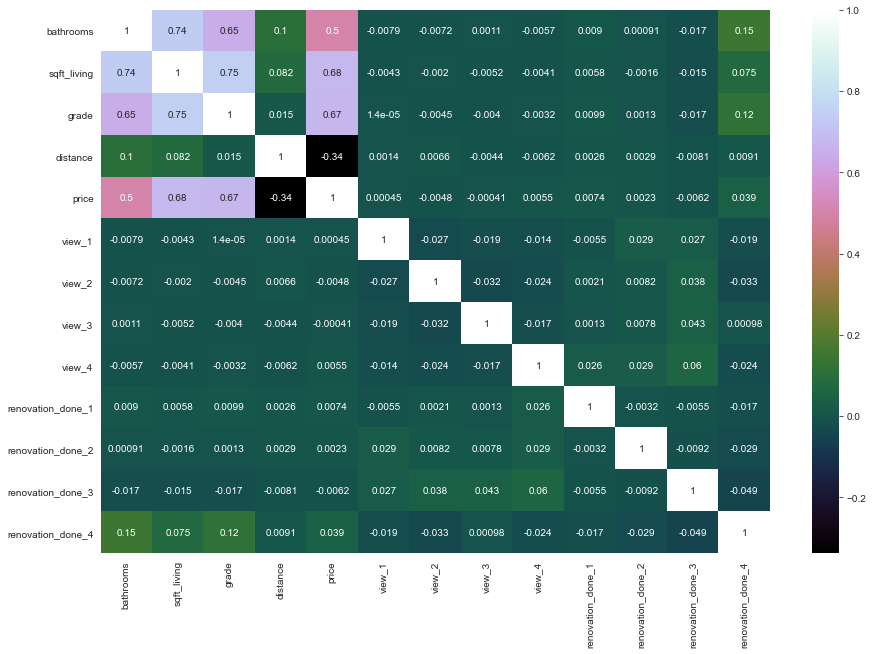

In [92]:
# Visualizing multicollinearity in the new dataset
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_num_cat_1.corr(), cmap="cubehelix", annot=True)

In [93]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info">The matrix indicates no strong correlation between the price and any of the categorical variables. However, renovation_done_4 correlation is slightly higher than the rest of the categorical variables. Conceptually this variables indicative of a recent renovation or a newer property.</div>
<div class="alert alert-block alert-danger">There is no high expectations that adding the categorical variables to the mix will significantly improve the model</div>
"""

'\n<div class="alert alert-block alert-info">The matrix indicates no strong correlation between the price and any of the categorical variables. However, renovation_done_4 correlation is slightly higher than the rest of the categorical variables. Conceptually this variables indicative of a recent renovation or a newer property.</div>\n<div class="alert alert-block alert-danger">There is no high expectations that adding the categorical variables to the mix will significantly improve the model</div>\n'

In [94]:
df_num_cat_1

bathrooms  sqft_living  grade  distance     price  view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4
0           1.00         1180      7       7.4  221900.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
1           2.25         2570      7       8.0  538000.0     0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0
2           1.00          770      6      10.2  180000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
3           3.00         1960      7       6.6  604000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
4           2.00         1680      8      13.4  510000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
...          ...          ...    ...       ...       ...     ...     ...     ...     ...                ...                ...                ...                ...
19806       2.50         1530      8       6.5  360000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19807       2.50         2310      8       6.7  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19808       0.75         1020      7       1.7  402101.0     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19809       2.50         1600      8      13.2  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19810       0.75         1020      7       1.8  325000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0

[19811 rows x 13 columns]

In [95]:
# Create a formula for the numerical variables from the basemodel
# AND the categorical variables from the previous section

variables_to_include = ' + '.join(df_num_cat_1.drop('price',axis=1).columns)

## Create the formula and the model
f  = "price~" + variables_to_include


model_2 = smf.ols(f, df_num_cat_1).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     3328.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:14   Log-Likelihood:            -2.6756e+05
No. Observations:               19811   AIC:                         5.352e+05
Df Residuals:                   19798   BIC:                         5.353e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3.189e+05   1.05e+04    -30.473      0.000   -3.39e+05   -2.98e+05
bathrooms         -1.502e+04   2616.457     -5.740      0.000   -2.01e+04   -9888.816
sqft_living         176.1368      2.615     67.355      0.000     171.011     181.263
grade              9.553e+04   1750.159     54.586      0.000    9.21e+04     9.9e+04
distance          -1.917e+04    208.998    -91.705      0.000   -1.96e+04   -1.88e+04
view_1             5556.1173   1.02e+04      0.547      0.584   -1.43e+04    2.55e+04
view_2            -1185.4496   6242.542     -0.190      0.849   -1.34e+04    1.11e+04
view_3             4061.7300   8636.371      0.470      0.638   -1.29e+04     2.1e+04
view_4             1.425e+04   1.14e+04      1.249      0.212   -8114.035    3.66e+04
renovation_done_1  1.333e+04   2.89e+04      0.462      0.644   -4.32e+04    6.99e+04
renovation_done_2   1.11e+04   1.72e+04      0.644      0.520   -2.27e+04    4.49e+04
renovation_done_3  3143.7672   1.03e+04      0.305      0.761   -1.71e+04    2.34e+04
renovation_done_4 -2.634e+04   3771.177     -6.985      0.000   -3.37e+04    -1.9e+04
==============================================================================
Omnibus:                     8082.328   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64840.177
Skew:                           1.760   Prob(JB):                         0.00
Kurtosis:                      11.134   Cond. No.                     5.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

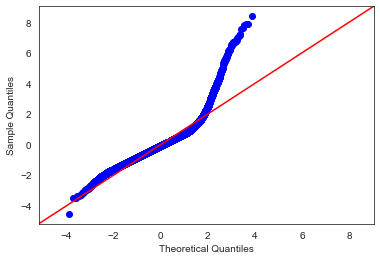

In [96]:
fig = sm.graphics.qqplot(model_2.resid,dist=stats.norm,fit=True,line='45')

<div class="alert alert-block alert-info">The summary indicates a very slight improvement over the previous model, 66.9% versus 66.8% of all of the observations fall within the results of the line formed by the regression equation.<br><br>
    It is also evident that p-values of most of the categorical values are very high, indicating their insignificance in the model. However, because they describe the same feature, I am leaving them in for now<br><br>
The residuals normality did not improve</div>

### Model 3 (preprocessing and removal of outliers)

#### Scaling with Robust Scaler

In [97]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 
I ruled out the scaling of the data in this step of the process because it would not change the statistics of the mode, though the correlation coefficients would become more compatible with each other.
<br><br>I am leaving the snippets in the notebook in case I reconsider.
</div>
<div class="alert alert-block alert-danger"><b>The next step is a removal of ourliers</b><br>
</div>
"""

'\n<div class="alert alert-block alert-info"> \nI ruled out the scaling of the data in this step of the process because it would not change the statistics of the mode, though the correlation coefficients would become more compatible with each other.\n<br><br>I am leaving the snippets in the notebook in case I reconsider.\n</div>\n<div class="alert alert-block alert-danger"><b>The next step is a removal of ourliers</b><br>\n</div>\n'

In [98]:
# Using RobustScaler to scale the data
"""# Using RobustScaler, which transforms the feature vector by subtracting the median and then dividing by the
# interquartile range (%25-75%). It is the most robust to the ourliers

df_for_scalers=df_num_cat_2.copy()

cols=['bathrooms','grade','sqft_living15','distance','waterfront_1','renovation_done_4']
scaler = RobustScaler()
robust_df = scaler.fit_transform(df_for_scalers.drop('price',axis=1))
robust_df = pd.DataFrame(robust_df, columns=cols)

df_num_cat_2.describe()"""

"""robust_df.describe()"""

"""fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('Before Scaling')
  
sns.kdeplot(df_for_scalers['distance'], ax = ax1, color ='blue')

ax2.set_title('After Robust Scaling')
  
sns.kdeplot(robust_df['distance'], ax = ax2, color ='red')


plt.show()"""

"fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5))\nax1.set_title('Before Scaling')\n  \nsns.kdeplot(df_for_scalers['distance'], ax = ax1, color ='blue')\n\nax2.set_title('After Robust Scaling')\n  \nsns.kdeplot(robust_df['distance'], ax = ax2, color ='red')\n\n\nplt.show()"

In [99]:
# Building and summary of the model with scaled data
"""robust_df['price']=df_for_scalers['price']
robust_df.info()


num_cat_var2_robust = ' + '.join(robust_df.drop('price',axis=1).columns)

## Create the formula and the model
f  = "price~" + num_cat_var2_robust


model_num_cat_2_robust = smf.ols(f, robust_df).fit()
model_num_cat_2_robust.summary()

coeffs=model_num_cat_2.params
coeffs.sort_values().round(2)

coeffs=model_num_cat_2_robust.params
coeffs.sort_values().round(2)"""

'robust_df[\'price\']=df_for_scalers[\'price\']\nrobust_df.info()\n\n\nnum_cat_var2_robust = \' + \'.join(robust_df.drop(\'price\',axis=1).columns)\n\n## Create the formula and the model\nf  = "price~" + num_cat_var2_robust\n\n\nmodel_num_cat_2_robust = smf.ols(f, robust_df).fit()\nmodel_num_cat_2_robust.summary()\n\ncoeffs=model_num_cat_2.params\ncoeffs.sort_values().round(2)\n\ncoeffs=model_num_cat_2_robust.params\ncoeffs.sort_values().round(2)'

#### Removal of outliers

##### IQR method

###### Using IQR

In [100]:
df_num_cat_1

bathrooms  sqft_living  grade  distance     price  view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4
0           1.00         1180      7       7.4  221900.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
1           2.25         2570      7       8.0  538000.0     0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0
2           1.00          770      6      10.2  180000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
3           3.00         1960      7       6.6  604000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
4           2.00         1680      8      13.4  510000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
...          ...          ...    ...       ...       ...     ...     ...     ...     ...                ...                ...                ...                ...
19806       2.50         1530      8       6.5  360000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19807       2.50         2310      8       6.7  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19808       0.75         1020      7       1.7  402101.0     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19809       2.50         1600      8      13.2  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19810       0.75         1020      7       1.8  325000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0

[19811 rows x 13 columns]

In [101]:
df_num_cat_2=df_num_cat_1.copy()

# Due to the fact that discrete variables are not suitable for IQR method outlier removal, they are being dropped 
# from the DataFrame. They will be added back to the Dataframe for modeling

df_num_cat_2=df_num_cat_2.drop(['view_1','view_2','view_3','view_4',
                              'renovation_done_1','renovation_done_2','renovation_done_3','renovation_done_4',
                              'grade','bathrooms'], axis=1)

Q1 = df_num_cat_2.quantile(q=.25)
Q3 = df_num_cat_2.quantile(q=.75)
IQR = df_num_cat_2.apply(stats.iqr)

df_num_cat_3 = df_num_cat_2[~((df_num_cat_2 < (Q1-1.5*IQR)) | (df_num_cat_2 > (Q3+1.5*IQR))).any(axis=1)]

df_num_cat_3

sqft_living  distance     price
0             1180       7.4  221900.0
1             2570       8.0  538000.0
2              770      10.2  180000.0
3             1960       6.6  604000.0
4             1680      13.4  510000.0
...            ...       ...       ...
19806         1530       6.5  360000.0
19807         2310       6.7  400000.0
19808         1020       1.7  402101.0
19809         1600      13.2  400000.0
19810         1020       1.8  325000.0

[18619 rows x 3 columns]

In [102]:
df_num_cat_3['grade']=df_num_cat_1['grade']
df_num_cat_3['bathrooms']=df_num_cat_1['bathrooms']
df_num_cat_3['view_1']=df_num_cat_1['view_1']
df_num_cat_3['view_2']=df_num_cat_1['view_2']
df_num_cat_3['view_3']=df_num_cat_1['view_3']
df_num_cat_3['view_4']=df_num_cat_1['view_4']
df_num_cat_3['renovation_done_1']=df_num_cat_1['renovation_done_1']
df_num_cat_3['renovation_done_2']=df_num_cat_1['renovation_done_2']
df_num_cat_3['renovation_done_3']=df_num_cat_1['renovation_done_3']
df_num_cat_3['renovation_done_4']=df_num_cat_1['renovation_done_4']

In [103]:
df_num_cat_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18619 entries, 0 to 19810
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft_living        18619 non-null  int64  
 1   distance           18619 non-null  float64
 2   price              18619 non-null  float64
 3   grade              18619 non-null  int64  
 4   bathrooms          18619 non-null  float64
 5   view_1             18619 non-null  float64
 6   view_2             18619 non-null  float64
 7   view_3             18619 non-null  float64
 8   view_4             18619 non-null  float64
 9   renovation_done_1  18619 non-null  float64
 10  renovation_done_2  18619 non-null  float64
 11  renovation_done_3  18619 non-null  float64
 12  renovation_done_4  18619 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 2.0 MB


In [104]:
df_num_cat_3=df_num_cat_3.reset_index()

df_num_cat_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18619 entries, 0 to 18618
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              18619 non-null  int64  
 1   sqft_living        18619 non-null  int64  
 2   distance           18619 non-null  float64
 3   price              18619 non-null  float64
 4   grade              18619 non-null  int64  
 5   bathrooms          18619 non-null  float64
 6   view_1             18619 non-null  float64
 7   view_2             18619 non-null  float64
 8   view_3             18619 non-null  float64
 9   view_4             18619 non-null  float64
 10  renovation_done_1  18619 non-null  float64
 11  renovation_done_2  18619 non-null  float64
 12  renovation_done_3  18619 non-null  float64
 13  renovation_done_4  18619 non-null  float64
dtypes: float64(11), int64(3)
memory usage: 2.0 MB


In [105]:
df_num_cat_3=df_num_cat_3.drop('index', axis=1)
df_num_cat_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18619 entries, 0 to 18618
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft_living        18619 non-null  int64  
 1   distance           18619 non-null  float64
 2   price              18619 non-null  float64
 3   grade              18619 non-null  int64  
 4   bathrooms          18619 non-null  float64
 5   view_1             18619 non-null  float64
 6   view_2             18619 non-null  float64
 7   view_3             18619 non-null  float64
 8   view_4             18619 non-null  float64
 9   renovation_done_1  18619 non-null  float64
 10  renovation_done_2  18619 non-null  float64
 11  renovation_done_3  18619 non-null  float64
 12  renovation_done_4  18619 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 1.8 MB


In [106]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>df_num_cat_3</b> DataFrame<br><br><b>18619</b> records out of the original <b>21597</b> left
    </div><br>
<div class="alert alert-block alert-danger">
    <b>Index reset</b>
    </div>
"""

'\n<div class="alert alert-block alert-success">\n    <b>df_num_cat_3</b> DataFrame<br><br><b>18619</b> records out of the original <b>21597</b> left\n    </div><br>\n<div class="alert alert-block alert-danger">\n    <b>Index reset</b>\n    </div>\n'

###### Building the model

In [107]:
## Formula is the same, model is for the cleaned DF

variables_to_include_3_1 = ' + '.join(df_num_cat_3.drop('price',axis=1).columns)
f  = "price~" + variables_to_include_3_1


model_3_1 = smf.ols(f, df_num_cat_3).fit()
model_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2672.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:15   Log-Likelihood:            -2.4463e+05
No. Observations:               18619   AIC:                         4.893e+05
Df Residuals:                   18606   BIC:                         4.894e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.397e+05   7752.045    -18.019      0.000   -1.55e+05   -1.24e+05
sqft_living         129.1653      2.028     63.697      0.000     125.191     133.140
distance          -1.527e+04    152.634   -100.023      0.000   -1.56e+04    -1.5e+04
grade              7.293e+04   1291.290     56.478      0.000    7.04e+04    7.55e+04
bathrooms         -7626.9730   1901.298     -4.011      0.000   -1.14e+04   -3900.255
view_1             1295.3996   7317.902      0.177      0.859    -1.3e+04    1.56e+04
view_2            -1419.9738   4457.993     -0.319      0.750   -1.02e+04    7318.099
view_3              454.9216   6141.592      0.074      0.941   -1.16e+04    1.25e+04
view_4             1.163e+04   8208.818      1.417      0.156   -4457.709    2.77e+04
renovation_done_1  3.485e+04   2.08e+04      1.673      0.094   -5972.705    7.57e+04
renovation_done_2  1.589e+04   1.22e+04      1.299      0.194   -8087.988    3.99e+04
renovation_done_3  -907.0686   7331.656     -0.124      0.902   -1.53e+04    1.35e+04
renovation_done_4 -1.562e+04   2714.396     -5.753      0.000   -2.09e+04   -1.03e+04
==============================================================================
Omnibus:                      849.136   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1199.719
Skew:                           0.438   Prob(JB):                    3.05e-261
Kurtosis:                       3.882   Cond. No.                     4.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

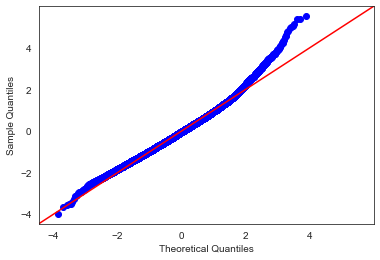

In [108]:
fig = sm.graphics.qqplot(model_3_1.resid,dist=stats.norm,fit=True,line='45')

In [109]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> While the IQR removal of outliers decreased the R squared of the model, it made the distribution more normal (Skew and Kurtosis values are almost within the normality ranges). This fact is also reflected by the QQ plot of the model residuals. Unfortunately, the Coefficient of determination dropped</div>
"""

'\n<div class="alert alert-block alert-info"> While the IQR removal of outliers decreased the R squared of the model, it made the distribution more normal (Skew and Kurtosis values are almost within the normality ranges). This fact is also reflected by the QQ plot of the model residuals. Unfortunately, the Coefficient of determination dropped</div>\n'

##### Z-score method

###### Using Z scores

In [110]:
df_num_cat_1

bathrooms  sqft_living  grade  distance     price  view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4
0           1.00         1180      7       7.4  221900.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
1           2.25         2570      7       8.0  538000.0     0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0
2           1.00          770      6      10.2  180000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
3           3.00         1960      7       6.6  604000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
4           2.00         1680      8      13.4  510000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0
...          ...          ...    ...       ...       ...     ...     ...     ...     ...                ...                ...                ...                ...
19806       2.50         1530      8       6.5  360000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19807       2.50         2310      8       6.7  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19808       0.75         1020      7       1.7  402101.0     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19809       2.50         1600      8      13.2  400000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0
19810       0.75         1020      7       1.8  325000.0     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0

[19811 rows x 13 columns]

In [111]:
df_num_cat_4=df_num_cat_1.copy()

df_num_cat_4=df_num_cat_4.drop(['view_1','view_2','view_3','view_4',
                              'renovation_done_1','renovation_done_2','renovation_done_3','renovation_done_4',
                              'grade','bathrooms'], axis=1)

df_num_cat_4['z_sqft_living']=stats.zscore(df_num_cat_4['sqft_living'])
df_num_cat_4['z_distance']=stats.zscore(df_num_cat_4['distance'])
df_num_cat_4['z_price']=stats.zscore(df_num_cat_4['price'])

df_num_cat_4

sqft_living  distance     price  z_sqft_living  z_distance   z_price
0             1180       7.4  221900.0      -1.005265   -0.568136 -0.976073
1             2570       8.0  538000.0       0.645148   -0.469671  0.049084
2              770      10.2  180000.0      -1.492078   -0.108633 -1.111960
3             1960       6.6  604000.0      -0.079134   -0.699423  0.263131
4             1680      13.4  510000.0      -0.411591    0.416513 -0.041724
...            ...       ...       ...            ...         ...       ...
19806         1530       6.5  360000.0      -0.589694   -0.715834 -0.528195
19807         2310       6.7  400000.0       0.336438   -0.683012 -0.398469
19808         1020       1.7  402101.0      -1.195241   -1.503553 -0.391656
19809         1600      13.2  400000.0      -0.506579    0.383692 -0.398469
19810         1020       1.8  325000.0      -1.195241   -1.487142 -0.641705

[19811 rows x 6 columns]

In [112]:
df_num_cat_5=df_num_cat_4[(abs(df_num_cat_4.z_price) < 3)]

df_num_cat_5=df_num_cat_5[(abs(df_num_cat_5.z_distance) < 3)]

df_num_cat_5=df_num_cat_5[(abs(df_num_cat_5.z_sqft_living) < 3)]
df_num_cat_5

sqft_living  distance     price  z_sqft_living  z_distance   z_price
0             1180       7.4  221900.0      -1.005265   -0.568136 -0.976073
1             2570       8.0  538000.0       0.645148   -0.469671  0.049084
2              770      10.2  180000.0      -1.492078   -0.108633 -1.111960
3             1960       6.6  604000.0      -0.079134   -0.699423  0.263131
4             1680      13.4  510000.0      -0.411591    0.416513 -0.041724
...            ...       ...       ...            ...         ...       ...
19806         1530       6.5  360000.0      -0.589694   -0.715834 -0.528195
19807         2310       6.7  400000.0       0.336438   -0.683012 -0.398469
19808         1020       1.7  402101.0      -1.195241   -1.503553 -0.391656
19809         1600      13.2  400000.0      -0.506579    0.383692 -0.398469
19810         1020       1.8  325000.0      -1.195241   -1.487142 -0.641705

[19261 rows x 6 columns]

In [113]:
df_num_cat_5['grade']=df_num_cat_1['grade']
df_num_cat_5['bathrooms']=df_num_cat_1['bathrooms']
df_num_cat_5['view_1']=df_num_cat_1['view_1']
df_num_cat_5['view_2']=df_num_cat_1['view_2']
df_num_cat_5['view_3']=df_num_cat_1['view_3']
df_num_cat_5['view_4']=df_num_cat_1['view_4']
df_num_cat_5['renovation_done_1']=df_num_cat_1['renovation_done_1']
df_num_cat_5['renovation_done_2']=df_num_cat_1['renovation_done_2']
df_num_cat_5['renovation_done_3']=df_num_cat_1['renovation_done_3']
df_num_cat_5['renovation_done_4']=df_num_cat_1['renovation_done_4']

In [114]:
df_num_cat_5=df_num_cat_5.drop(['z_sqft_living','z_distance','z_price'], axis=1)

In [115]:
df_num_cat_5=df_num_cat_5.reset_index()
df_num_cat_5=df_num_cat_5.drop('index', axis=1)
df_num_cat_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19261 entries, 0 to 19260
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft_living        19261 non-null  int64  
 1   distance           19261 non-null  float64
 2   price              19261 non-null  float64
 3   grade              19261 non-null  int64  
 4   bathrooms          19261 non-null  float64
 5   view_1             19261 non-null  float64
 6   view_2             19261 non-null  float64
 7   view_3             19261 non-null  float64
 8   view_4             19261 non-null  float64
 9   renovation_done_1  19261 non-null  float64
 10  renovation_done_2  19261 non-null  float64
 11  renovation_done_3  19261 non-null  float64
 12  renovation_done_4  19261 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 1.9 MB


In [116]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-success">
    <b>df_num_cat_5</b> DataFrame<br><br><b>19261</b> records out of the original <b>21597</b> left
    </div><br>
<div class="alert alert-block alert-danger">
    <b>Index reset</b>
    </div><br>
"""

'\n<div class="alert alert-block alert-success">\n    <b>df_num_cat_5</b> DataFrame<br><br><b>19261</b> records out of the original <b>21597</b> left\n    </div><br>\n<div class="alert alert-block alert-danger">\n    <b>Index reset</b>\n    </div><br>\n'

##### Building the model

In [117]:
## Formula is the same, model is for the cleaned DF

variables_to_include_3_2 = ' + '.join(df_num_cat_5.drop('price',axis=1).columns)
f  = "price~" + variables_to_include_3_2


model_3_2 = smf.ols(f, df_num_cat_5).fit()
model_3_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     3027.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:15   Log-Likelihood:            -2.5551e+05
No. Observations:               19261   AIC:                         5.110e+05
Df Residuals:                   19248   BIC:                         5.111e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.074e+05   8498.928    -24.399      0.000   -2.24e+05   -1.91e+05
sqft_living         141.6977      2.203     64.311      0.000     137.379     146.016
distance          -1.666e+04    167.636    -99.371      0.000    -1.7e+04   -1.63e+04
grade              8.286e+04   1416.839     58.485      0.000    8.01e+04    8.56e+04
bathrooms         -1.001e+04   2109.297     -4.746      0.000   -1.41e+04   -5875.419
view_1             1.247e+04   8077.275      1.544      0.123   -3357.516    2.83e+04
view_2            -1948.1291   4983.950     -0.391      0.696   -1.17e+04    7820.847
view_3            -3331.9562   6896.935     -0.483      0.629   -1.69e+04    1.02e+04
view_4             1.641e+04   9104.994      1.802      0.072   -1441.323    3.43e+04
renovation_done_1  3.577e+04   2.27e+04      1.576      0.115   -8719.452    8.03e+04
renovation_done_2  1.284e+04   1.37e+04      0.938      0.348    -1.4e+04    3.97e+04
renovation_done_3 -4898.3754   8252.665     -0.594      0.553   -2.11e+04    1.13e+04
renovation_done_4  -2.12e+04   3022.668     -7.014      0.000   -2.71e+04   -1.53e+04
==============================================================================
Omnibus:                     2690.071   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6382.550
Skew:                           0.811   Prob(JB):                         0.00
Kurtosis:                       5.307   Cond. No.                     4.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

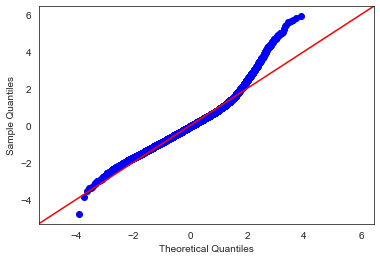

In [118]:
fig = sm.graphics.qqplot(model_3_2.resid,dist=stats.norm,fit=True,line='45')

In [119]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 
The R squared of the model is 0.654 and F-statistics is higher than for the previous model
    <br>The IQR method of outliers removal made the residual distribution more normal than Z-score method due to the former having more strict criteria. The decision is to use the dataset compiled after Z-score outlier removal. 
<br>
</div>
<div class="alert alert-block alert-danger"><b>The next step is Log transformation of the target variable</b><br>
</div>
"""

'\n<div class="alert alert-block alert-info"> \nThe R squared of the model is 0.654 and F-statistics is higher than for the previous model\n    <br>The IQR method of outliers removal made the residual distribution more normal than Z-score method due to the former having more strict criteria. The decision is to use the dataset compiled after Z-score outlier removal. \n<br>\n</div>\n<div class="alert alert-block alert-danger"><b>The next step is Log transformation of the target variable</b><br>\n</div>\n'

### Model 4 (Using log and square root transformations on the target variable)

#### Log Transformation

In [120]:
df_num_cat_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19261 entries, 0 to 19260
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft_living        19261 non-null  int64  
 1   distance           19261 non-null  float64
 2   price              19261 non-null  float64
 3   grade              19261 non-null  int64  
 4   bathrooms          19261 non-null  float64
 5   view_1             19261 non-null  float64
 6   view_2             19261 non-null  float64
 7   view_3             19261 non-null  float64
 8   view_4             19261 non-null  float64
 9   renovation_done_1  19261 non-null  float64
 10  renovation_done_2  19261 non-null  float64
 11  renovation_done_3  19261 non-null  float64
 12  renovation_done_4  19261 non-null  float64
dtypes: float64(11), int64(2)
memory usage: 1.9 MB


In [121]:
# Log transform
df_num_cat_5_log=df_num_cat_5.copy()

df_num_cat_5_log['log_price'] = df_num_cat_5['price'].map(lambda x: np.log(x))
df_num_cat_5_log

sqft_living  distance     price  grade  bathrooms  view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4  log_price
0             1180       7.4  221900.0      7       1.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  12.309982
1             2570       8.0  538000.0      7       2.25     0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0  13.195614
2              770      10.2  180000.0      6       1.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  12.100712
3             1960       6.6  604000.0      7       3.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  13.311329
4             1680      13.4  510000.0      8       2.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  13.142166
...            ...       ...       ...    ...        ...     ...     ...     ...     ...                ...                ...                ...                ...        ...
19256         1530       6.5  360000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  12.793859
19257         2310       6.7  400000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  12.899220
19258         1020       1.7  402101.0      7       0.75     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  12.904459
19259         1600      13.2  400000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  12.899220
19260         1020       1.8  325000.0      7       0.75     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  12.691580

[19261 rows x 14 columns]

In [122]:
df_num_cat_5_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19261 entries, 0 to 19260
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sqft_living        19261 non-null  int64  
 1   distance           19261 non-null  float64
 2   price              19261 non-null  float64
 3   grade              19261 non-null  int64  
 4   bathrooms          19261 non-null  float64
 5   view_1             19261 non-null  float64
 6   view_2             19261 non-null  float64
 7   view_3             19261 non-null  float64
 8   view_4             19261 non-null  float64
 9   renovation_done_1  19261 non-null  float64
 10  renovation_done_2  19261 non-null  float64
 11  renovation_done_3  19261 non-null  float64
 12  renovation_done_4  19261 non-null  float64
 13  log_price          19261 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 2.1 MB


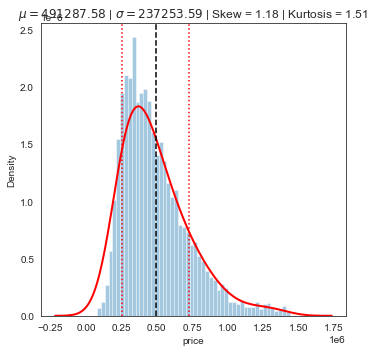

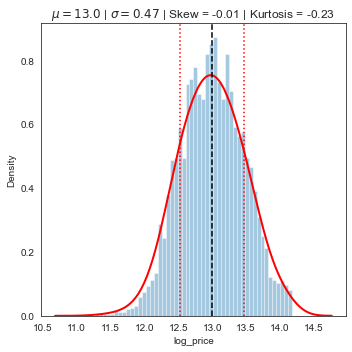

In [123]:
# Histogram of log_price and price
continuous=['price','log_price']
for col in continuous:
    fig, ax =plt.subplots(figsize=(5, 5))
    distribution(df_num_cat_5_log[col])


In [124]:
# Commented out because of the git push problems

"""
<div class="alert alert-block alert-info"> 
The transformation worked well, improving the normality of the 'price' variable. Log_price distribution looks more symmetrical. Skewness improved dramatically (from 1.18 to -0.01, 0 being perfectly symmetrical)<br><br>
 Kurtosis value decreased, making the curve more Mesokurtic (close to a Gaussian curve). It is an expected effect of log transform.
</div>
<div class="alert alert-block alert-danger"><b>The next step is test a square root transformation.</b><br>
</div>"""

'\n<div class="alert alert-block alert-info"> \nThe transformation worked well, improving the normality of the \'price\' variable. Log_price distribution looks more symmetrical. Skewness improved dramatically (from 1.18 to -0.01, 0 being perfectly symmetrical)<br><br>\n Kurtosis value decreased, making the curve more Mesokurtic\xa0(close to a Gaussian curve). It is an expected effect of log transform.\n</div>\n<div class="alert alert-block alert-danger"><b>The next step is test a square root transformation.</b><br>\n</div>'

In [125]:
# Square transform
df_num_cat_5_sqrt=df_num_cat_5.copy()

df_num_cat_5_sqrt['sqrt_price'] = df_num_cat_5['price'].map(lambda x: np.sqrt(x))
df_num_cat_5_sqrt

sqft_living  distance     price  grade  bathrooms  view_1  view_2  view_3  view_4  renovation_done_1  renovation_done_2  renovation_done_3  renovation_done_4  sqrt_price
0             1180       7.4  221900.0      7       1.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  471.062629
1             2570       8.0  538000.0      7       2.25     0.0     0.0     0.0     0.0                0.0                0.0                1.0                0.0  733.484833
2              770      10.2  180000.0      6       1.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  424.264069
3             1960       6.6  604000.0      7       3.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  777.174369
4             1680      13.4  510000.0      8       2.00     0.0     0.0     0.0     0.0                0.0                0.0                0.0                0.0  714.142843
...            ...       ...       ...    ...        ...     ...     ...     ...     ...                ...                ...                ...                ...         ...
19256         1530       6.5  360000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  600.000000
19257         2310       6.7  400000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  632.455532
19258         1020       1.7  402101.0      7       0.75     1.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  634.114343
19259         1600      13.2  400000.0      8       2.50     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  632.455532
19260         1020       1.8  325000.0      7       0.75     0.0     0.0     0.0     0.0                0.0                0.0                0.0                1.0  570.087713

[19261 rows x 14 columns]

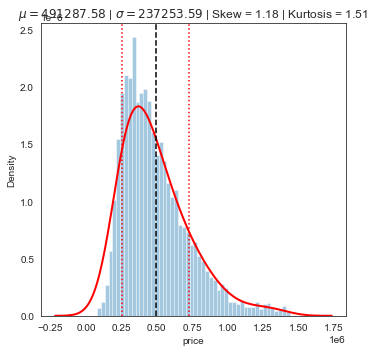

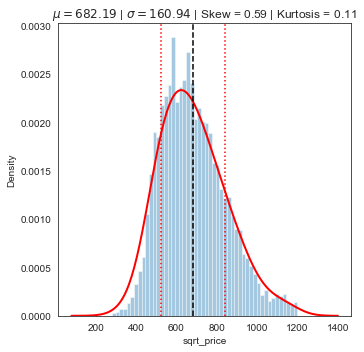

In [126]:
# Histogram of log_price and price
continuous=['price','sqrt_price']
for col in continuous:
    fig, ax =plt.subplots(figsize=(5, 5))
    distribution(df_num_cat_5_sqrt[col])


In [127]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 
The square root transformation also worked well in improving the normality of the 'price' variable. 
sqrt_price distribution looks more symmetrical. Skewness improved dramatically (from 1.18 to -0.59, 0 being perfectly symmetrical)
<br><br>
 However, both of the parameters are worse that the parameters of log_price distribution.
</div>
<div class="alert alert-block alert-danger"><b>The next step is create two separate models and to see if the transformations made a difference</b><br>
</div>"""

'\n<div class="alert alert-block alert-info"> \nThe square root transformation also worked well in improving the normality of the \'price\' variable. \nsqrt_price distribution looks more symmetrical. Skewness improved dramatically (from 1.18 to -0.59, 0 being perfectly symmetrical)\n<br><br>\n However, both of the parameters are worse that the parameters of log_price distribution.\n</div>\n<div class="alert alert-block alert-danger"><b>The next step is create two separate models and to see if the transformations made a difference</b><br>\n</div>'

#### Model using log transformed target variable

In [128]:
## Formula is the same, model is for the cleaned DF

variables_to_include_4_1 = ' + '.join(df_num_cat_5_log.drop(['price','log_price'],axis=1).columns)
f  = "log_price~" + variables_to_include_4_1


model_4_1 = smf.ols(f, df_num_cat_5_log).fit()
model_4_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     3164.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:17   Log-Likelihood:                -2224.4
No. Observations:               19261   AIC:                             4475.
Df Residuals:                   19248   BIC:                             4577.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.6414      0.017    704.222      0.000      11.609      11.674
sqft_living           0.0003   4.29e-06     60.161      0.000       0.000       0.000
distance             -0.0348      0.000   -106.862      0.000      -0.035      -0.034
grade                 0.1599      0.003     58.035      0.000       0.155       0.165
bathrooms             0.0125      0.004      3.052      0.002       0.004       0.021
view_1                0.0120      0.016      0.764      0.445      -0.019       0.043
view_2               -0.0027      0.010     -0.281      0.779      -0.022       0.016
view_3                0.0017      0.013      0.128      0.898      -0.025       0.028
view_4                0.0253      0.018      1.427      0.154      -0.009       0.060
renovation_done_1     0.0788      0.044      1.785      0.074      -0.008       0.165
renovation_done_2     0.0449      0.027      1.688      0.091      -0.007       0.097
renovation_done_3    -0.0161      0.016     -1.002      0.316      -0.048       0.015
renovation_done_4    -0.0340      0.006     -5.782      0.000      -0.046      -0.022
==============================================================================
Omnibus:                      310.255   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.347
Skew:                          -0.167   Prob(JB):                    1.82e-105
Kurtosis:                       3.700   Cond. No.                     4.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model using square root transformed target variable

In [129]:
## Formula is the same, model is for the cleaned DF

variables_to_include_4_2 = ' + '.join(df_num_cat_5_sqrt.drop(['price','sqrt_price'],axis=1).columns)
f  = "sqrt_price~" + variables_to_include_4_2


model_4_2= smf.ols(f, df_num_cat_5_sqrt).fit()
model_4_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     3307.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:17   Log-Likelihood:            -1.1442e+05
No. Observations:               19261   AIC:                         2.289e+05
Df Residuals:                   19248   BIC:                         2.290e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           207.9501      5.598     37.145      0.000     196.977     218.923
sqft_living           0.0938      0.001     64.625      0.000       0.091       0.097
distance            -11.7839      0.110   -106.715      0.000     -12.000     -11.567
grade                56.1638      0.933     60.178      0.000      54.334      57.993
bathrooms            -1.7413      1.389     -1.253      0.210      -4.465       0.982
view_1                6.2009      5.321      1.165      0.244      -4.228      16.630
view_2               -1.1299      3.283     -0.344      0.731      -7.565       5.305
view_3               -0.9735      4.543     -0.214      0.830      -9.878       7.931
view_4                9.9751      5.998      1.663      0.096      -1.781      21.731
renovation_done_1    25.8342     14.951      1.728      0.084      -3.471      55.140
renovation_done_2    12.2778      9.018      1.362      0.173      -5.397      29.953
renovation_done_3    -4.3359      5.436     -0.798      0.425     -14.991       6.319
renovation_done_4   -13.1475      1.991     -6.603      0.000     -17.050      -9.245
==============================================================================
Omnibus:                      571.397   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.310
Skew:                           0.300   Prob(JB):                    3.42e-188
Kurtosis:                       3.846   Cond. No.                     4.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

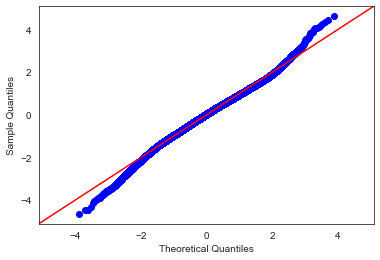

In [130]:
fig = sm.graphics.qqplot(model_4_1.resid,dist=stats.norm,fit=True,line='45')

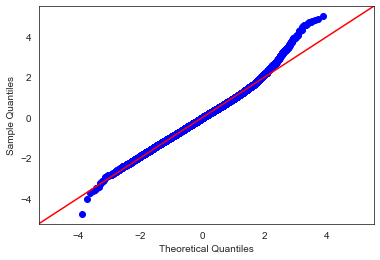

In [131]:
fig = sm.graphics.qqplot(model_4_2.resid,dist=stats.norm,fit=True,line='45')

In [132]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 
Both models have improved the R squared and the F-statistics of the previous models. The residuals of both models display a close-to-normal distribution. Log transformation helped improve the upper part of the distribution, while square root transformation worked better in the lower part of the distribution. 
<br><br>
R squared of the square root transformation-based model is slightly higher, while its kurtosis value is slightly worse than the kurtosis value of the log-transformed price model. The decision is to use the log-transformed target variable.
</div>
<div class="alert alert-block alert-danger"><b>The next step is to remove unnecessary categorical variables, scale the remaining variables, and built the last model with coefficients in the regression model, which are easy to compare and interpret</b><br>
</div>"""


'\n<div class="alert alert-block alert-info"> \nBoth models have improved the R squared and the F-statistics of the previous models. The residuals of both models display a close-to-normal distribution. Log transformation helped improve the upper part of the distribution, while square root transformation worked better in the lower part of the distribution. \n<br><br>\nR squared of the square root transformation-based model is slightly higher, while its kurtosis value is slightly worse than the kurtosis value of the log-transformed price model. The decision is to use the log-transformed target variable.\n</div>\n<div class="alert alert-block alert-danger"><b>The next step is to remove unnecessary categorical variables, scale the remaining variables, and built the last model with coefficients in the regression model, which are easy to compare and interpret</b><br>\n</div>'

In [133]:
# Removing all categorical values with high p-values and renaming the renovation_done_4
# to a more prominent name, reflective of the definition of the field (see Categorical variables subsection 
# in Exploring distributions and correlations section)

df_num_cat_5_log_cropped=df_num_cat_5_log.copy()
df_num_cat_5_log_cropped=df_num_cat_5_log_cropped.drop(['view_1','view_2','view_3','view_4','renovation_done_1',
                                                'renovation_done_2','renovation_done_3'], axis=1)
df_num_cat_5_log_cropped.rename(columns={'renovation_done_4': 'recent_renovation_new'}, inplace=True)

In [134]:
df_num_cat_5_log_cropped

sqft_living  distance     price  grade  bathrooms  recent_renovation_new  log_price
0             1180       7.4  221900.0      7       1.00                    0.0  12.309982
1             2570       8.0  538000.0      7       2.25                    0.0  13.195614
2              770      10.2  180000.0      6       1.00                    0.0  12.100712
3             1960       6.6  604000.0      7       3.00                    0.0  13.311329
4             1680      13.4  510000.0      8       2.00                    0.0  13.142166
...            ...       ...       ...    ...        ...                    ...        ...
19256         1530       6.5  360000.0      8       2.50                    1.0  12.793859
19257         2310       6.7  400000.0      8       2.50                    1.0  12.899220
19258         1020       1.7  402101.0      7       0.75                    1.0  12.904459
19259         1600      13.2  400000.0      8       2.50                    1.0  12.899220
19260         1020       1.8  325000.0      7       0.75                    1.0  12.691580

[19261 rows x 7 columns]

In [135]:
# Standardizing the independent variables. I decided to do it manually due to a better control of the utput


df_num_cat_5_log_cropped_st=df_num_cat_5_log_cropped.copy()


lv_min=df_num_cat_5_log_cropped_st.sqft_living.min()
lv_range=df_num_cat_5_log_cropped_st.sqft_living.max()-df_num_cat_5_log_cropped_st.sqft_living.min()
distance_range=df_num_cat_5_log_cropped_st.distance.max()-df_num_cat_5_log_cropped_st.distance.min()
distance_min=df_num_cat_5_log_cropped_st.distance.min()
bathroom_range=df_num_cat_5_log_cropped_st.bathrooms.max()-df_num_cat_5_log_cropped_st.bathrooms.min()
bathroom_min=df_num_cat_5_log_cropped_st.bathrooms.min()
grade_range=df_num_cat_5_log_cropped_st.grade.max()-df_num_cat_5_log_cropped_st.grade.min()
grade_min=df_num_cat_5_log_cropped_st.grade.min()


df_num_cat_5_log_cropped_st['sqft_living_st']=df_num_cat_5_log_cropped_st.apply(lambda row: round((row.sqft_living-lv_min)/lv_range,3), axis=1)
df_num_cat_5_log_cropped_st['distance_st']=df_num_cat_5_log_cropped_st.apply(lambda row: round((row.distance-distance_min)/distance_range,3), axis=1)
df_num_cat_5_log_cropped_st['bathrooms_st']=df_num_cat_5_log_cropped_st.apply(lambda row: round((row.bathrooms-bathroom_min)/bathroom_range,3), axis=1)
df_num_cat_5_log_cropped_st['grade_st']=df_num_cat_5_log_cropped_st.apply(lambda row: (row.grade-grade_min)/grade_range, axis=1)
#df_num_cat_5_sqrt_cropped_st['recent_renovation_new_str']=df_num_cat_5_sqrt_cropped_st['recent_renovation_new'].astype('str')

df_num_cat_5_log_cropped_st

sqft_living  distance     price  grade  bathrooms  recent_renovation_new  log_price  sqft_living_st  distance_st  bathrooms_st  grade_st
0             1180       7.4  221900.0      7       1.00                    0.0  12.309982           0.194        0.239         0.105     0.375
1             2570       8.0  538000.0      7       2.25                    0.0  13.195614           0.528        0.260         0.368     0.375
2              770      10.2  180000.0      6       1.00                    0.0  12.100712           0.096        0.337         0.105     0.250
3             1960       6.6  604000.0      7       3.00                    0.0  13.311329           0.381        0.211         0.526     0.375
4             1680      13.4  510000.0      8       2.00                    0.0  13.142166           0.314        0.449         0.316     0.500
...            ...       ...       ...    ...        ...                    ...        ...             ...          ...           ...       ...
19256         1530       6.5  360000.0      8       2.50                    1.0  12.793859           0.278        0.207         0.421     0.500
19257         2310       6.7  400000.0      8       2.50                    1.0  12.899220           0.465        0.214         0.421     0.500
19258         1020       1.7  402101.0      7       0.75                    1.0  12.904459           0.156        0.039         0.053     0.375
19259         1600      13.2  400000.0      8       2.50                    1.0  12.899220           0.295        0.442         0.421     0.500
19260         1020       1.8  325000.0      7       0.75                    1.0  12.691580           0.156        0.042         0.053     0.375

[19261 rows x 11 columns]

In [136]:
## Formula is the same, model is for the cleaned DF

variables_to_include_4_3 = ' + '.join(df_num_cat_5_log_cropped_st.drop(
    ['price','log_price','sqft_living','distance','grade','bathrooms'],axis=1).columns)
f  = "log_price~" + variables_to_include_4_3
print(f)
model_4_3= smf.ols(f, df_num_cat_5_log_cropped_st).fit()
model_4_3.summary()

log_price~recent_renovation_new + sqft_living_st + distance_st + bathrooms_st + grade_st


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     7593.
Date:                Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:32:18   Log-Likelihood:                -2228.2
No. Observations:               19261   AIC:                             4468.
Df Residuals:                   19255   BIC:                             4516.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.3621      0.008   1602.897      0.000      12.347      12.377
recent_renovation_new    -0.0345      0.006     -5.875      0.000      -0.046      -0.023
sqft_living_st            1.0747      0.018     60.141      0.000       1.040       1.110
distance_st              -0.9931      0.009   -106.878      0.000      -1.011      -0.975
bathrooms_st              0.0598      0.019      3.072      0.002       0.022       0.098
grade_st                  1.2805      0.022     58.089      0.000       1.237       1.324
==============================================================================
Omnibus:                      310.179   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.427
Skew:                          -0.166   Prob(JB):                    1.75e-105
Kurtosis:                       3.700   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

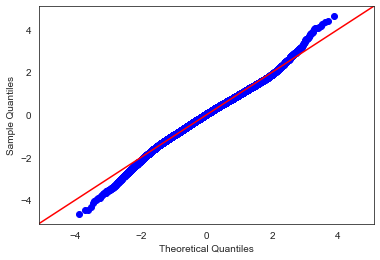

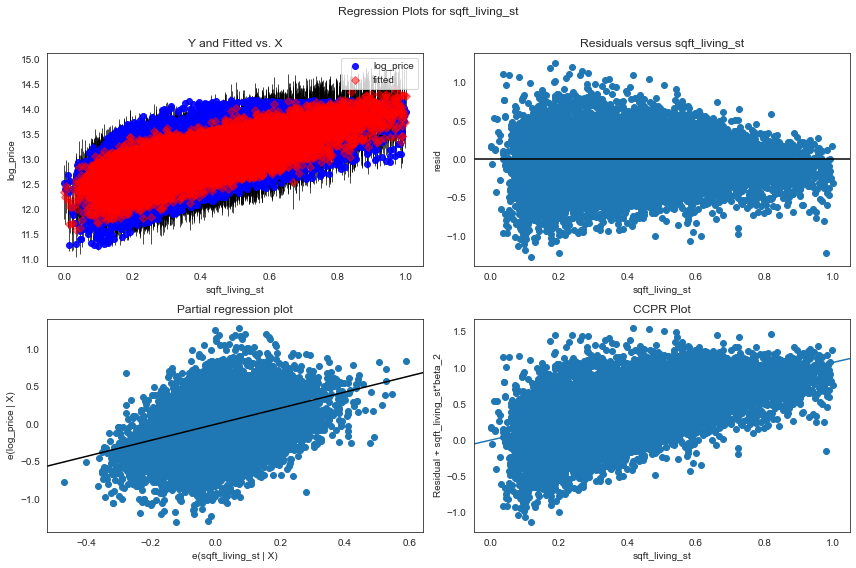

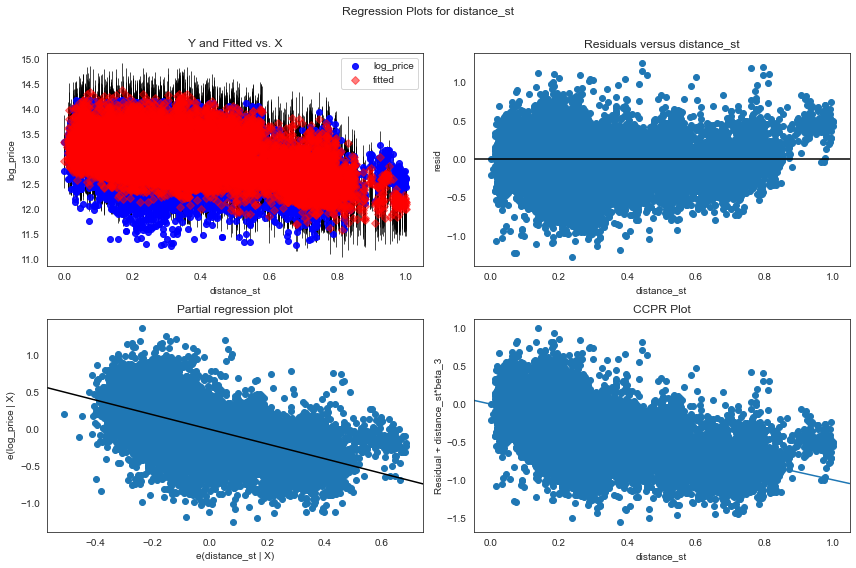

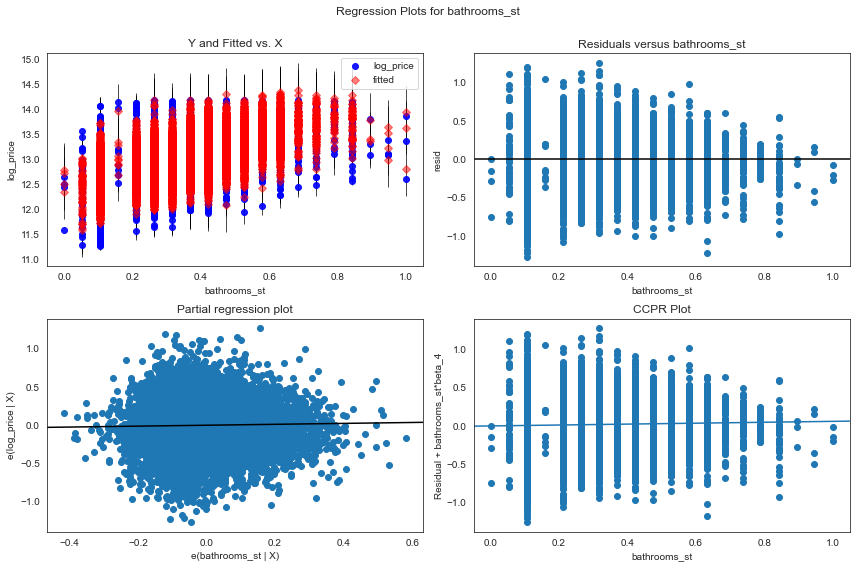

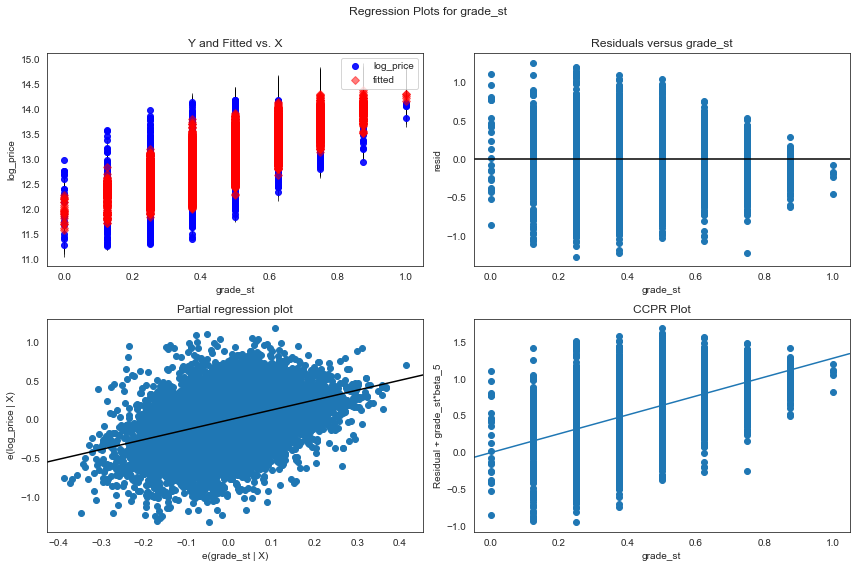

In [137]:
fig = sm.graphics.qqplot(model_4_3.resid,dist=stats.norm,fit=True,line='45')

# Removing variable to simplify the display (categorical variable with only 2 values does not have
# much use when plotted by regress_exog)
# print(df_num_cat_5_log_cropped_st.drop(['price','log_price','recent_renovation_new',
#                                        'sqft_living', 'distance', 'grade', 'bathrooms'],axis=1).columns)


for col in (df_num_cat_5_log_cropped_st.drop(['price','log_price','recent_renovation_new',
                                        'sqft_living', 'distance', 'grade', 'bathrooms'],axis=1).columns):
    fig = sm.graphics.plot_regress_exog(model_4_3, col, fig=plt.figure(figsize=(12,8)))

In [138]:
# Commented out because of the git push problems
"""
<div class="alert alert-block alert-info"> 

The final linear regression model of a log of the price variable versus grade, bathrooms, distance from the center of the city, sqft_living space, and the indicator if a house has been renovated recently or a newer house has a Coefficient of Determination of 0.663. It is indicative of the fact that 66.3% of the sold properties fall within the results of the line formed by the regression equation. F-statistics displays the high value and the overall p-value much lower than the confidence interval 
<br><br>
The independent variables used in the equation display a clear linear relationship with the target and homoscedasticity.
</div>

<div class="alert alert-block alert-danger"><b>The next step is to validate the model by using training and test datasets</b><br>

</div>
"""

'\n<div class="alert alert-block alert-info"> \n\nThe final linear regression model of a log of the price variable versus grade, bathrooms, distance from the center of the city, sqft_living space, and the indicator if a house has been renovated recently or a newer house has a Coefficient of Determination of 0.663. It is indicative of the fact that 66.3% of the sold properties fall within the results of the line formed by the regression equation. F-statistics displays the high value and the overall p-value much lower than the confidence interval \n<br><br>\nThe independent variables used in the equation display a clear linear relationship with the target and homoscedasticity.\n</div>\n\n<div class="alert alert-block alert-danger"><b>The next step is to validate the model by using training and test datasets</b><br>\n\n</div>\n'

### Train the model

In [139]:
# Define X and y
y=df_num_cat_5_log_cropped_st[['log_price']]
X=df_num_cat_5_log_cropped_st.drop(['price','log_price','recent_renovation_new',
                                        'sqft_living', 'distance', 'grade', 'bathrooms'], axis=1)

In [140]:
y

log_price
0      12.309982
1      13.195614
2      12.100712
3      13.311329
4      13.142166
...          ...
19256  12.793859
19257  12.899220
19258  12.904459
19259  12.899220
19260  12.691580

[19261 rows x 1 columns]

In [141]:
X

sqft_living_st  distance_st  bathrooms_st  grade_st
0               0.194        0.239         0.105     0.375
1               0.528        0.260         0.368     0.375
2               0.096        0.337         0.105     0.250
3               0.381        0.211         0.526     0.375
4               0.314        0.449         0.316     0.500
...               ...          ...           ...       ...
19256           0.278        0.207         0.421     0.500
19257           0.465        0.214         0.421     0.500
19258           0.156        0.039         0.053     0.375
19259           0.295        0.442         0.421     0.500
19260           0.156        0.042         0.053     0.375

[19261 rows x 4 columns]

In [142]:
# Split the data into training and test sets. Use the default split size
# X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

print(len(X_train), len(X_test), len(y_train), len(y_test))

13482 5779 13482 5779


In [143]:
# Fit the model to train data
linreg = LinearRegression()
model=linreg.fit(X_train, y_train)

# Calculate predictions on training and test sets for y_hat
y_hat_train=linreg.predict(X_train)
y_hat_test=linreg.predict(X_test)

# Calculate residuals
train_residuals=y_hat_train-y_train
test_residuals=y_hat_test-y_test

# Calculate training and test RMSE
train_mse = mean_squared_error(y_train, y_hat_train, squared=False)
test_mse = mean_squared_error(y_test, y_hat_test, squared=False)
print('Train MSE:', round(train_mse,3))
print('Test MSE:', round(test_mse,3))

Train MSE: 0.272
Test MSE: 0.272


In [144]:
print(model.coef_, model.intercept_, model.score(X_test, y_test))

[[ 1.07971047 -0.9891889   0.04547509  1.26484854]] [12.36601493] 0.6718738822346366


### Validation

In [145]:
price_target=df_num_cat_5_log_cropped_st[['log_price']]
price_predictors= df_num_cat_5_log_cropped_st.drop(['price','log_price','recent_renovation_new',
                                        'sqft_living', 'distance', 'grade', 'bathrooms'], axis=1)

In [146]:
metrics.r2_score(price_target, linreg.predict(price_predictors))

0.6628669814917774

In [147]:
metrics.mean_absolute_error(price_target, linreg.predict(price_predictors))

0.21292952976823826

In [148]:
mean_squared_error(price_target, linreg.predict(price_predictors))

0.07392658991485863

In [149]:
# Commented out because of the git push problems
"""
>Train MSE: 0.272<br>
Test MSE: 0.272<br>
Are equal down to the third decimal digit indicating a good agreement between the training and the test sets<br><br>
<b>R</b> squared for for the prediction on the full dataset is the same as in model_4_3: 0.663<br>
<b>Mean Absolute Error</b> for the prediction on the full dataset is 0.213 which is not great but acceptable. The best possible theoretical value is 0.<br>
<b>Mean Squared Error</b> for the prediction on the full dataset is 0.074. The best possible theoretical value is 0.
"""


'\n>Train MSE: 0.272<br>\nTest MSE: 0.272<br>\nAre equal down to the third decimal digit indicating a good agreement between the training and the test sets<br><br>\n<b>R</b> squared for for the prediction on the full dataset is the same as in model_4_3: 0.663<br>\n<b>Mean Absolute Error</b> for the prediction on the full dataset is 0.213 which is not great but acceptable. The best possible theoretical value is 0.<br>\n<b>Mean Squared Error</b> for the prediction on the full dataset is 0.074. The best possible theoretical value is 0.\n'

In [150]:
# Not sure if the results of this function are indicative of anything, but leaving it here for a possible future use
"""mse, bias, var = bias_variance_decomp(model, X_train.values, y_train.values.flatten(), 
                                      X_test.values, y_test.values, num_rounds=200, random_seed=1, loss='mse')
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)"""

"mse, bias, var = bias_variance_decomp(model, X_train.values, y_train.values.flatten(), \n                                      X_test.values, y_test.values, num_rounds=200, random_seed=1, loss='mse')\n# summarize results\nprint('MSE: %.3f' % mse)\nprint('Bias: %.3f' % bias)\nprint('Variance: %.3f' % var)"

# iNterpret

In [151]:
%%latex

\begin{align}\ln\left( {Price} \right) = 12.366 + 1.265 \cdot \left( grade \right) + 
1.080 \cdot \left( sqft\_living \right) - 0.989 \cdot \left( distance \right) 
+ 0.060 \cdot \left( bathrooms \right) - 0.035 \cdot \left( recent\_renovation\_new \right) \end{align}


<IPython.core.display.Latex object>

In [152]:
# Commented out because of the git push problems
"""
The final model has a reasonable predictive ability tested in the final step of the model validation. MSE, MAE, and R2 score along with the model p-values for all predictors indicate a good fit.<br><br>
The most influential predictor is a **building grade**, following by a **living space footage**. Both factors are **positively correlated** with the price of the property. Both factors are within property owners' control when they are renovating their houses.<br>A **distance** from the center of the city is **negatively correlated** with the price of property, meaning the further away a property is, the lower is the price. It is not a controllable variable but is helpful for home buyers if the living space and the number of bedrooms/bathrooms are important.<br> A **number of bathrooms** has a **positive effect** on the price of a property, but it is not as strong as the first two factors. This fact indicates that the convenience of having multiple bathrooms is essential for potential buyers and should be taken into account when owners are planning a renovation.<br>
The last predictor in the model is an indicator of whether a property **has been renovated recently or a new construction**. It is very **weakly negatively correlated** with the price variable. The negative correlation (reduction of the price) might be related to the following factors: newer properties, on the average, are of less building quality.<br>
**The intercept** of the model is a **bias** of the model and can be interpreted as an offset of the model due to other factors not taken into account for various reasons.
"""

"\nThe final model has a reasonable predictive ability tested in the final step of the model validation. MSE, MAE, and R2 score along with the model p-values for all predictors indicate a good fit.<br><br>\nThe most influential predictor is a **building grade**, following by a **living space footage**. Both factors are **positively correlated** with the price of the property. Both factors are within property owners' control when they are renovating their houses.<br>A **distance** from the center of the city is **negatively correlated** with the price of property, meaning the further away a property is, the lower is the price. It is not a controllable variable but is helpful for home buyers if the living space and the number of bedrooms/bathrooms are important.<br> A **number of bathrooms** has a **positive effect** on the price of a property, but it is not as strong as the first two factors. This fact indicates that the convenience of having multiple bathrooms is essential for potentia

# Conclusions and Recommendation

In [153]:
# Commented out because of the git push problems

"""
**Recommendations to property owners planning a renovation to their properties:**
* Increase the living space of your property
* Do the renovation with higher building quality
* Consider adding a bathroom

**Recommendations to potential buyers:**
* Look for properties further away from the city center to make the best out of your property buying budget
* Properties in some zipcodes of the city are more affordable than others at the same distance from the city center
* Properties in some zipcodes of the city are more affordable than others with a better view, more considerable property lots, and with older houses of better quality construction if these factors are essential to a buyer

**Limitations of the model:**
* The original dataset does not include other important factors, and therefore the model is biased
* Multiple linear regression models, while easily interpretable, are limited in their predictive ability
* Some variables in the dataset are strongly correlated with each other, and that affect the predictive power of the model

**Suggestion for future improvements**:
* Add variables to the original dataset like kitchen renovation, average commute time, crime index, average nearby public school quality, etc.
* Update the dataset with more current data
"""

'\n**Recommendations to property owners planning a renovation to their properties:**\n* Increase the living space of your property\n* Do the renovation with higher building quality\n* Consider adding a bathroom\n\n**Recommendations to potential buyers:**\n* Look for properties further away from the city center to make the best out of your property buying budget\n* Properties in some zipcodes of the city are more affordable than others at the same distance from the city center\n* Properties in some zipcodes of the city are more affordable than others with a better view, more considerable property lots, and with older houses of better quality construction if these factors are essential to a buyer\n\n**Limitations of the model:**\n* The original dataset does not include other important factors, and therefore the model is biased\n* Multiple linear regression models, while easily interpretable, are limited in their predictive ability\n* Some variables in the dataset are strongly correlated 

# Appendix

### Visualization

In [154]:
df_test=X_test.copy()
df_test['log_price']=y_test['log_price']
df_test['recent_renovation_new']=df_num_cat_5_log_cropped_st['recent_renovation_new']
df_test['sqft_living']=df_num_cat_5_log_cropped_st['sqft_living']
df_test['distance']=df_num_cat_5_log_cropped_st['distance']
df_test['grade']=df_num_cat_5_log_cropped_st['grade']
df_test['bathrooms']=df_num_cat_5_log_cropped_st['bathrooms']
df_test['price']=df_test.apply(lambda row: math.exp(row.log_price), axis=1)
df_test['recent_renovation_new_str']=df_test['recent_renovation_new'].astype('str')
#df_test=df_test.reset_index(drop='index')
df_test

sqft_living_st  distance_st  bathrooms_st  grade_st  log_price  recent_renovation_new  sqft_living  distance  grade  bathrooms      price recent_renovation_new_str
4977            0.317        0.088         0.263     0.375  12.860999                    0.0         1690       3.1      7       1.75   385000.0                       0.0
8676            0.233        0.646         0.105     0.375  12.415523                    0.0         1340      19.0      7       1.00   246600.0                       0.0
9682            0.451        0.246         0.526     0.375  13.507626                    0.0         2250       7.6      7       3.00   735000.0                       0.0
2046            0.129        0.351         0.105     0.375  12.631340                    0.0          910      10.6      7       1.00   306000.0                       0.0
18744           0.511        0.740         0.421     0.625  13.262125                    1.0         2500      21.7      9       2.50   575000.0                       1.0
...               ...          ...           ...       ...        ...                    ...          ...       ...    ...        ...        ...                       ...
12600           0.528        0.126         0.421     0.500  13.825461                    0.0         2570       4.2      8       2.50  1010000.0                       0.0
8951            0.621        0.232         0.368     0.750  14.100690                    0.0         2960       7.2     10       2.25  1330000.0                       0.0
14452           0.137        0.179         0.105     0.375  12.739638                    0.0          940       5.7      7       1.00   341000.0                       0.0
10710           0.336        0.779         0.421     0.375  12.767116                    0.0         1770      22.8      7       2.50   350500.0                       0.0
8312            0.252        0.270         0.263     0.125  12.345835                    0.0         1420       8.3      5       1.75   230000.0                       0.0

[5779 rows x 12 columns]

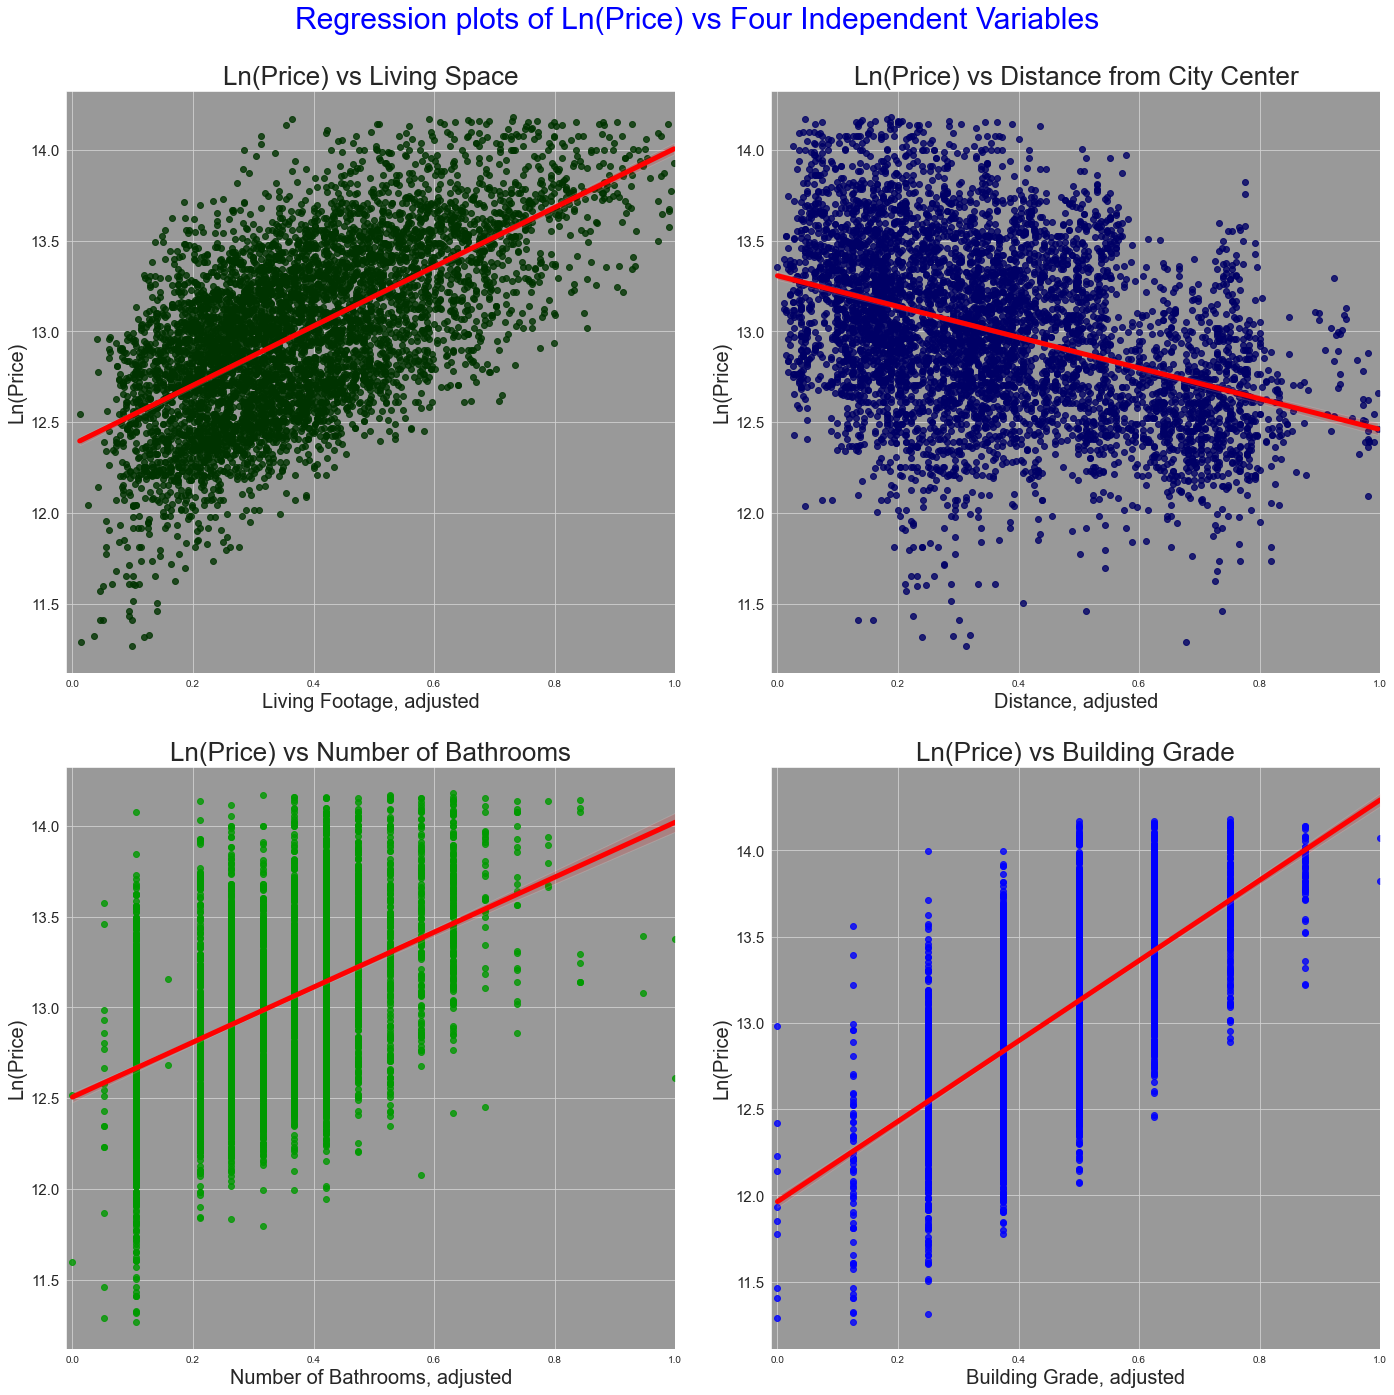

In [155]:
# Regplots for all four variables

sns.set_style("darkgrid", {"axes.facecolor": ".6"})
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

g1=sns.regplot(data=df_test, x="sqft_living_st", y="log_price", color="#003300", fit_reg=True,
               ax=axes[0,0], line_kws={"color": "red", "lw":5});
g2=sns.regplot(data=df_test, x="distance_st", y="log_price", color="#000066", 
               ax=axes[0,1], line_kws={"color": "red", "lw":5});
g3=sns.regplot(data=df_test, x="bathrooms_st", y="log_price", color="#009900", 
               ax=axes[1,0], line_kws={"color": "red", "lw":5});
g4=sns.regplot(data=df_test, x="grade_st", y="log_price", color="#0000ff", 
               ax=axes[1,1], line_kws={"color": "red", "lw":5});

axes[0,0].set_title("Ln(Price) vs Living Space", fontsize=26);
axes[0,0].set_ylabel('Ln(Price)', fontsize=20)
axes[0,0].set_xlabel('Living Footage, adjusted', fontsize=20)
axes[0,0].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) for x in g1.get_yticks()]
axes[0,0].set_yticklabels(ylabels, size=15)
axes[0,0].grid(color='lightgrey')

axes[0,1].set_title("Ln(Price) vs Distance from City Center", fontsize=26);
axes[0,1].set_ylabel('Ln(Price)', fontsize=20)
axes[0,1].set_xlabel('Distance, adjusted', fontsize=20)
axes[0,1].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) for x in g2.get_yticks()]
axes[0,1].set_yticklabels(ylabels, size=15)
axes[0,1].grid(color='lightgrey')

axes[1,0].set_title("Ln(Price) vs Number of Bathrooms", fontsize=26);
axes[1,0].set_ylabel('Ln(Price)', fontsize=20)
axes[1,0].set_xlabel('Number of Bathrooms, adjusted', fontsize=20)
axes[1,0].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) for x in g3.get_yticks()]
axes[1,0].set_yticklabels(ylabels, size=15)
axes[1,0].grid(color='lightgrey')

axes[1,1].set_title("Ln(Price) vs Building Grade", fontsize=26);
axes[1,1].set_ylabel('Ln(Price)', fontsize=20)
axes[1,1].set_xlabel('Building Grade, adjusted', fontsize=20)
axes[1,1].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) for x in g4.get_yticks()]
axes[1,1].set_yticklabels(ylabels, size=15)
axes[1,1].grid(color='lightgrey')

plt.suptitle("Regression plots of Ln(Price) vs Four Independent Variables", size=30, c="Blue")
plt.tight_layout(pad=3)


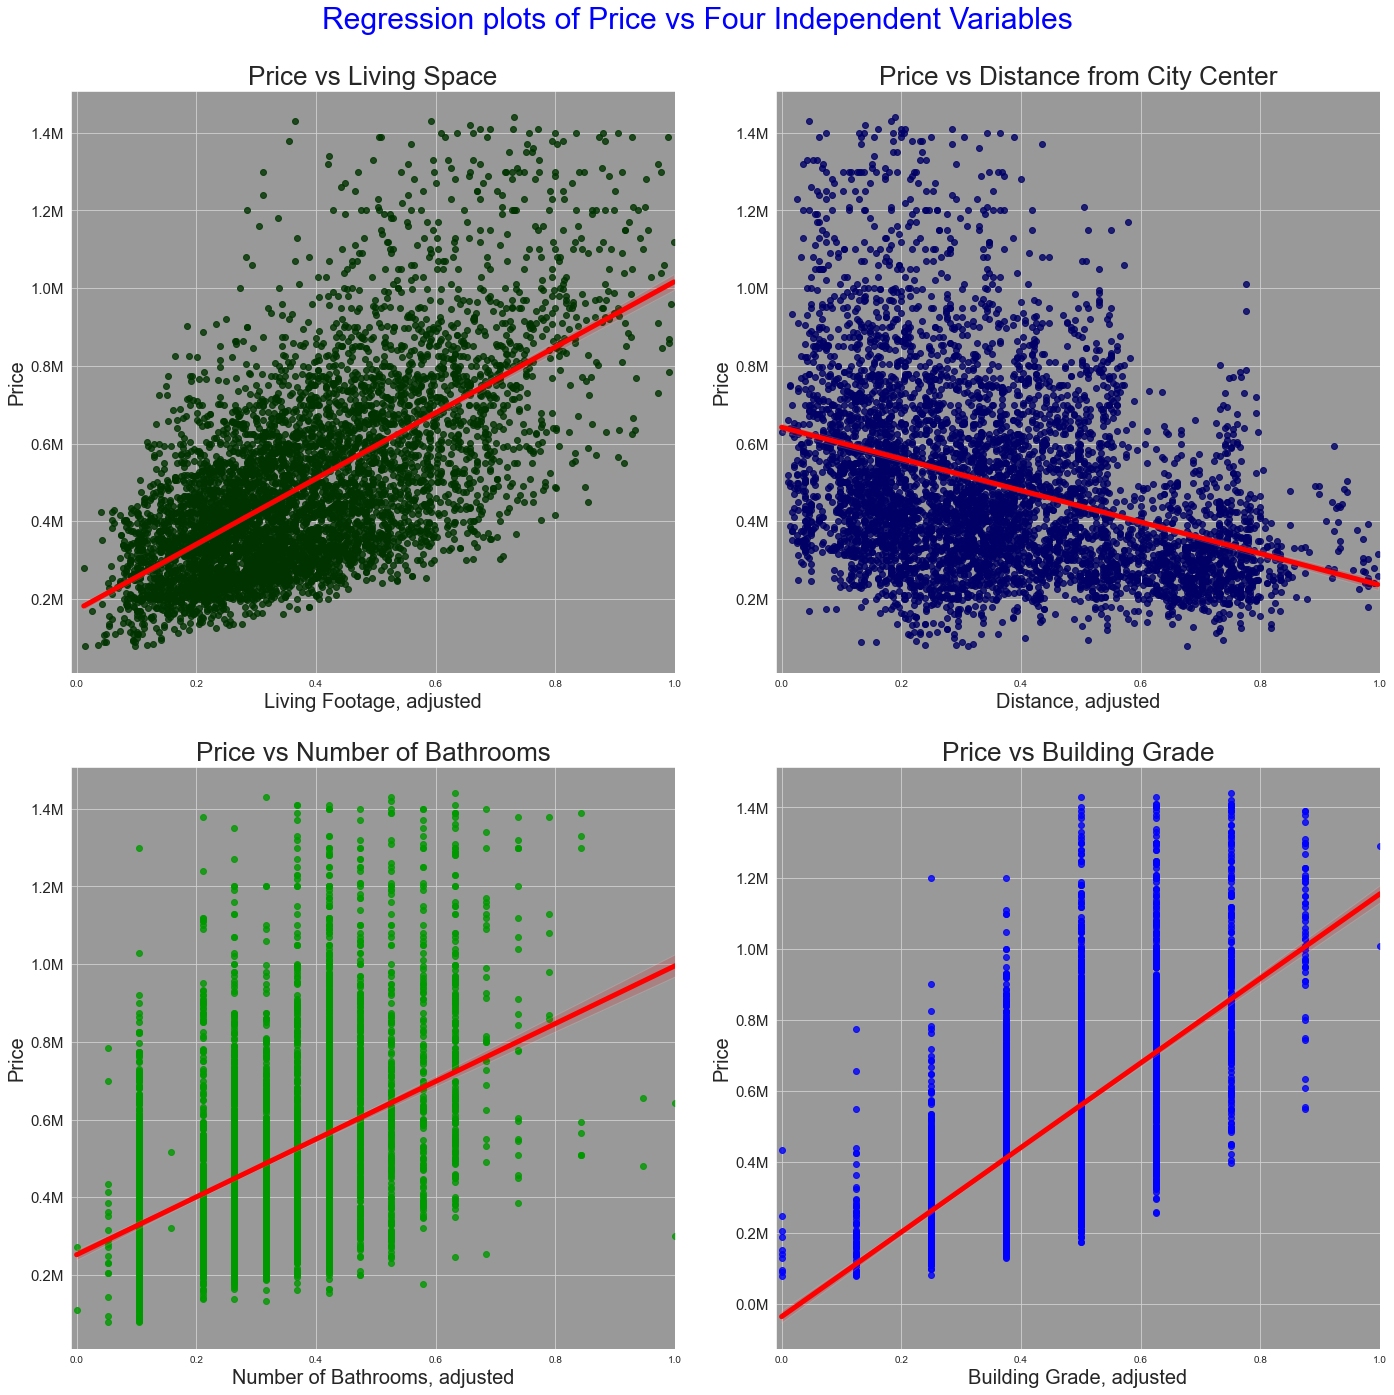

In [156]:
# Regplots for all four variables

sns.set_style("darkgrid", {"axes.facecolor": ".6"})
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

g1=sns.regplot(data=df_test, x="sqft_living_st", y="price", color="#003300", fit_reg=True,
               ax=axes[0,0], line_kws={"color": "red", "lw":5});
g2=sns.regplot(data=df_test, x="distance_st", y="price", color="#000066", 
               ax=axes[0,1], line_kws={"color": "red", "lw":5});
g3=sns.regplot(data=df_test, x="bathrooms_st", y="price", color="#009900", 
               ax=axes[1,0], line_kws={"color": "red", "lw":5});
g4=sns.regplot(data=df_test, x="grade_st", y="price", color="#0000ff", 
               ax=axes[1,1], line_kws={"color": "red", "lw":5});

axes[0,0].set_title("Price vs Living Space", fontsize=26);
axes[0,0].set_ylabel('Price', fontsize=20)
axes[0,0].set_xlabel('Living Footage, adjusted', fontsize=20)
axes[0,0].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g1.get_yticks()/1000000]
axes[0,0].set_yticklabels(ylabels, size=15)
axes[0,0].grid(color='lightgrey')

axes[0,1].set_title("Price vs Distance from City Center", fontsize=26);
axes[0,1].set_ylabel('Price', fontsize=20)
axes[0,1].set_xlabel('Distance, adjusted', fontsize=20)
axes[0,1].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g2.get_yticks()/1000000]
axes[0,1].set_yticklabels(ylabels, size=15)
axes[0,1].grid(color='lightgrey')

axes[1,0].set_title("Price vs Number of Bathrooms", fontsize=26);
axes[1,0].set_ylabel('Price', fontsize=20)
axes[1,0].set_xlabel('Number of Bathrooms, adjusted', fontsize=20)
axes[1,0].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g3.get_yticks()/1000000]
axes[1,0].set_yticklabels(ylabels, size=15)
axes[1,0].grid(color='lightgrey')

axes[1,1].set_title("Price vs Building Grade", fontsize=26);
axes[1,1].set_ylabel('Price', fontsize=20)
axes[1,1].set_xlabel('Building Grade, adjusted', fontsize=20)
axes[1,1].set_xlim(-0.01, 1.0)
ylabels = ['{:,.1f}'.format(x) + 'M' for x in g4.get_yticks()/1000000]
axes[1,1].set_yticklabels(ylabels, size=15)
axes[1,1].grid(color='lightgrey')


plt.suptitle("Regression plots of Price vs Four Independent Variables", size=30, c="Blue")
plt.tight_layout(pad=3)


In [157]:
# Commented out because of the git push problems
"""fig = px.scatter(df_test, x='sqft_living', y='price',  trendline='lowess', trendline_color_override='blue',
                 color='grade', size='distance',width=1000, height=800, size_max=20, 
                 color_continuous_scale=px.colors.sequential.Blackbody_r,
                 labels={
                     "price": "Price",
                     "sqft_living": "Living Space (sq ft)",
                     "grade": "Building Grade"
                  },
                title="Correlation: Property Price vs Living Space Footage",  template = "plotly_dark")

fig.update_traces(marker=dict(
            line=dict(
                color='coral',
                width=0.5
            )))
fig.update_layout(
    font_family="Arial",
    font_size=18,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white",

)
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()
"""

'fig = px.scatter(df_test, x=\'sqft_living\', y=\'price\',  trendline=\'lowess\', trendline_color_override=\'blue\',\n                 color=\'grade\', size=\'distance\',width=1000, height=800, size_max=20, \n                 color_continuous_scale=px.colors.sequential.Blackbody_r,\n                 labels={\n                     "price": "Price",\n                     "sqft_living": "Living Space (sq ft)",\n                     "grade": "Building Grade"\n                  },\n                title="Correlation: Property Price vs Living Space Footage",  template = "plotly_dark")\n\nfig.update_traces(marker=dict(\n            line=dict(\n                color=\'coral\',\n                width=0.5\n            )))\nfig.update_layout(\n    font_family="Arial",\n    font_size=18,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white",\n\n)\nfig.update_layout(\n    title={\n        \'y\':0.95,\n        \'x\':0.5,\n        \'xanchor\': \'center\',\n        \'y

In [158]:
# Commented out because of the git push problems
"""fig = px.scatter(df_test, x='bathrooms', y='price', color_continuous_scale=px.colors.sequential.Blackbody_r,
                 size='sqft_living',size_max=20,
                 trendline='lowess', trendline_color_override='blue', color='grade',
                 width=1000, height=800, labels={
                     "price": "Price",
                     "bathrooms": "Number of bathrooms",
                     "grade": "Building Grade"
                 },
                title="Correlation: Property Price vs Number of Bathrooms",
                 template = "plotly_dark")


fig.update_traces(marker=dict(
            line=dict(
                color='coral',
                width=0.5
            )))
fig.update_layout(
    font_family="Arial",
    font_size=18,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white",

)

fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()
"""

'fig = px.scatter(df_test, x=\'bathrooms\', y=\'price\', color_continuous_scale=px.colors.sequential.Blackbody_r,\n                 size=\'sqft_living\',size_max=20,\n                 trendline=\'lowess\', trendline_color_override=\'blue\', color=\'grade\',\n                 width=1000, height=800, labels={\n                     "price": "Price",\n                     "bathrooms": "Number of bathrooms",\n                     "grade": "Building Grade"\n                 },\n                title="Correlation: Property Price vs Number of Bathrooms",\n                 template = "plotly_dark")\n\n\nfig.update_traces(marker=dict(\n            line=dict(\n                color=\'coral\',\n                width=0.5\n            )))\nfig.update_layout(\n    font_family="Arial",\n    font_size=18,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white",\n\n)\n\nfig.update_layout(\n    title={\n        \'y\':0.95,\n        \'x\':0.5,\n        \'xanchor\': \'center\

In [159]:
# Commented out because of the git push problems
"""fig = px.scatter(df_test, x='distance', y='price',  trendline='lowess', trendline_color_override='blue',
                 color='grade', size='bathrooms',width=1000, height=800, size_max=20, 
                 color_continuous_scale=px.colors.sequential.Blackbody_r,
                 labels={
                     "price": "Price",
                     "distance": "Distance",
                     "grade": "Building Grade"
                  },
                title="Correlation: Property Price vs Distance from the City Center",  template = "plotly_dark")

fig.update_traces(marker=dict(
            line=dict(
                color='coral',
                width=0.5
            )))
fig.update_layout(
    font_family="Arial",
    font_size=18,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white",

)
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()
"""

'fig = px.scatter(df_test, x=\'distance\', y=\'price\',  trendline=\'lowess\', trendline_color_override=\'blue\',\n                 color=\'grade\', size=\'bathrooms\',width=1000, height=800, size_max=20, \n                 color_continuous_scale=px.colors.sequential.Blackbody_r,\n                 labels={\n                     "price": "Price",\n                     "distance": "Distance",\n                     "grade": "Building Grade"\n                  },\n                title="Correlation: Property Price vs Distance from the City Center",  template = "plotly_dark")\n\nfig.update_traces(marker=dict(\n            line=dict(\n                color=\'coral\',\n                width=0.5\n            )))\nfig.update_layout(\n    font_family="Arial",\n    font_size=18,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white",\n\n)\nfig.update_layout(\n    title={\n        \'y\':0.95,\n        \'x\':0.5,\n        \'xanchor\': \'center\',\n        \'yanchor\'

In [160]:
# Commented out because of the git push problems
"""fig = px.scatter(df_test, x='sqft_living', y='price',  trendline='ols', trendline_color_override='yellow',
                 color='recent_renovation_new_str', width=1000, height=800, size_max=20, 
                 labels={
                     "price": "Price",
                     "sqft_living": "Living Space (sq ft)",
                     "recent_renovation_new_str": "Newer(1)/Older(0)"
                  },
                title="Correlation: Property Price vs Living Space Footage of newer vs older properties",
                 template = "plotly_dark")

fig.update_traces(marker=dict(
            line=dict(
                color='coral',
                width=0.5
            )))
fig.update_layout(
    font_family="Arial",
    font_size=18,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white",

)
fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()
"""

'fig = px.scatter(df_test, x=\'sqft_living\', y=\'price\',  trendline=\'ols\', trendline_color_override=\'yellow\',\n                 color=\'recent_renovation_new_str\', width=1000, height=800, size_max=20, \n                 labels={\n                     "price": "Price",\n                     "sqft_living": "Living Space (sq ft)",\n                     "recent_renovation_new_str": "Newer(1)/Older(0)"\n                  },\n                title="Correlation: Property Price vs Living Space Footage of newer vs older properties",\n                 template = "plotly_dark")\n\nfig.update_traces(marker=dict(\n            line=dict(\n                color=\'coral\',\n                width=0.5\n            )))\nfig.update_layout(\n    font_family="Arial",\n    font_size=18,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white",\n\n)\nfig.update_layout(\n    title={\n        \'y\':0.95,\n        \'x\':0.5,\n        \'xanchor\': \'center\',\n        \'yancho

In [161]:
# Commented out because of the git push problems
"""fig = px.scatter_3d(df_test, x='bathrooms', z='grade', y='sqft_living',
              color='price', size='distance', size_max=50, opacity=1, width=1000, height=800,
                   color_continuous_scale=px.colors.sequential.Blackbody_r, 
                   labels={
                     "bathrooms": "Number of Bathrooms",
                     "sqft_living": "Living Space (sq ft)",
                     "grade": "Grade",
                       "price": "Price"
                  },
                title="3D plot: Living Space Footage, Number of Bathrooms and Grade of Sold Properties",
                   template = "plotly_dark")

fig.update_traces(marker=dict(
            line=dict(
                color='coral',
                width=0.5
            )))
fig.update_layout(
    font_family="Arial",
    font_size=16,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white"
)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()"""

'fig = px.scatter_3d(df_test, x=\'bathrooms\', z=\'grade\', y=\'sqft_living\',\n              color=\'price\', size=\'distance\', size_max=50, opacity=1, width=1000, height=800,\n                   color_continuous_scale=px.colors.sequential.Blackbody_r, \n                   labels={\n                     "bathrooms": "Number of Bathrooms",\n                     "sqft_living": "Living Space (sq ft)",\n                     "grade": "Grade",\n                       "price": "Price"\n                  },\n                title="3D plot: Living Space Footage, Number of Bathrooms and Grade of Sold Properties",\n                   template = "plotly_dark")\n\nfig.update_traces(marker=dict(\n            line=dict(\n                color=\'coral\',\n                width=0.5\n            )))\nfig.update_layout(\n    font_family="Arial",\n    font_size=16,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white"\n)\nfig.update_layout(\n    title={\n        \'y\':0.

In [162]:
# Commented out because of the git push problems
"""df_cut_off=df.copy()
df_cut_off=df_cut_off[(df_cut_off['price']<1500000)]

fig = px.scatter_mapbox(df_cut_off, lat="lat", lon="long", color="price", 
                  color_continuous_scale=px.colors.sequential.Plasma, zoom=10, 
                        mapbox_style='open-street-map', width=900, height=900,
                        title="Properties Sold in King County in 2014-2015",
                   template = "plotly_dark")

fig.update_layout(
    font_family="Arial",
    font_size=20,
    font_color="white",
    title_font_family="Arial",
    title_font_color="white"
)
fig.update_layout(
    title={
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
})


fig.show()
"""

'df_cut_off=df.copy()\ndf_cut_off=df_cut_off[(df_cut_off[\'price\']<1500000)]\n\nfig = px.scatter_mapbox(df_cut_off, lat="lat", lon="long", color="price", \n                  color_continuous_scale=px.colors.sequential.Plasma, zoom=10, \n                        mapbox_style=\'open-street-map\', width=900, height=900,\n                        title="Properties Sold in King County in 2014-2015",\n                   template = "plotly_dark")\n\nfig.update_layout(\n    font_family="Arial",\n    font_size=20,\n    font_color="white",\n    title_font_family="Arial",\n    title_font_color="white"\n)\nfig.update_layout(\n    title={\n        \'y\':0.98,\n        \'x\':0.5,\n        \'xanchor\': \'center\',\n        \'yanchor\': \'top\',\n})\n\n\nfig.show()\n'

In [163]:
# Commented out because of the git push problems
"""df_zipcode_viz=df.groupby('zipcode').mean()

df_zipcode_viz=df_zipcode_viz.reset_index()

df_zipcode_viz=df_zipcode_viz.drop(['id','sqft_above','sqft_basement','yr_renovated','lat','long'], axis=1)
df_zipcode_viz
"""

"df_zipcode_viz=df.groupby('zipcode').mean()\n\ndf_zipcode_viz=df_zipcode_viz.reset_index()\n\ndf_zipcode_viz=df_zipcode_viz.drop(['id','sqft_above','sqft_basement','yr_renovated','lat','long'], axis=1)\ndf_zipcode_viz\n"

In [164]:
# Commented out because of the git push problems
"""KC_zip_json=json.load(open('data/wa_washington_zip_codes_geo.min.json', 'r'))
"""

"KC_zip_json=json.load(open('data/wa_washington_zip_codes_geo.min.json', 'r'))\n"

In [165]:
# Commented out because of the git push problems
"""map_choropleth_zip(df_zipcode_viz, 'price', "Average Prices of Sold Properties per Zipcode (King County, 2014-2015)", 
                   "Price")
                   """

'map_choropleth_zip(df_zipcode_viz, \'price\', "Average Prices of Sold Properties per Zipcode (King County, 2014-2015)", \n                   "Price")\n                   '

In [166]:
# Commented out because of the git push problems
"""map_choropleth_zip(df_zipcode_viz, 'sqft_lot', "Average Lot Size of Sold Properties per Zipcode (King County, 2014-2015)",
                   "Lot size (sq ft)")
                   """

'map_choropleth_zip(df_zipcode_viz, \'sqft_lot\', "Average Lot Size of Sold Properties per Zipcode (King County, 2014-2015)",\n                   "Lot size (sq ft)")\n                   '

In [167]:
# Commented out because of the git push problems
"""map_choropleth_zip(df_zipcode_viz, 'yr_built', "Average Year Built of Sold Properties per Zipcode (King County, 2014-2015)", 
                   "Year Built")
                   """

'map_choropleth_zip(df_zipcode_viz, \'yr_built\', "Average Year Built of Sold Properties per Zipcode (King County, 2014-2015)", \n                   "Year Built")\n                   '

In [168]:
# Commented out because of the git push problems
"""map_choropleth_zip(df_zipcode_viz, 'view', "Average View Category of Sold Properties per Zipcode (King County, 2014-2015)", 
                   "View Category")
                   """

'map_choropleth_zip(df_zipcode_viz, \'view\', "Average View Category of Sold Properties per Zipcode (King County, 2014-2015)", \n                   "View Category")\n                   '

In [169]:
# Commented out because of the git push problems
"""map_choropleth_zip(df_zipcode_viz, 'sqft_living', "Average Living Space of Sold Properties per Zipcode (King County, 2014-2015)", 
                   "Living Space (sq ft) ")
                   """

'map_choropleth_zip(df_zipcode_viz, \'sqft_living\', "Average Living Space of Sold Properties per Zipcode (King County, 2014-2015)", \n                   "Living Space (sq ft) ")\n                   '

In [170]:
!conda info


     active environment : learn-env
    active env location : C:\Users\elena\anaconda3\envs\learn-env
            shell level : 2
       user config file : C:\Users\elena\.condarc
 populated config files : C:\Users\elena\.condarc
          conda version : 4.9.2
    conda-build version : 3.20.5
         python version : 3.8.5.final.0
       virtual packages : __cuda=11.1=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\elena\anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\Users\elena\anaconda3\pkgs
             